### Στοιχεία ομάδας (Ομάδα 1):

```
Neural Networks - Lab 2
Creators : 
Αναστάσης Αγγλογάλλος
Παναγιώτης Κοκκινάκης
Νικόλας Μπέλλος
```

**Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση.**
1. Σύστημα συστάσεων βασισμένο στο περιεχόμενο
2. Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

*Ημερομηνία εκφώνησης της άσκησης: 29 Νοεμβρίου 2022*



# 1. Προετοιμασία

In [1]:
!pip install --upgrade pip
# !pip install --upgrade numpy
!pip install numpy==1.22.0
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib
!pip install jinja2==3.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import joblib
import pandas as pd
import numpy as np

## Process Dataset (Read & Format)

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [3]:
# Read all movies in the dataset (all_data)|
dataset_url = "https://drive.google.com/uc?export=download&id=1zo13kUAf-MDMPZmBDxq1FxWtZY01lsxD"
all_data = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3)

In [4]:
# Print arrray inline
pd.set_option('expand_frame_repr', False)

print(all_data.head())

          0   1                          2                                                  3                                                  4                                                  5
0    975900   1             Ghosts of Mars  "Thriller",  "Science Fiction",  "Horror",  "A...  0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...  Set in the second half of the 22nd century, th...
1   9363483   4           White Of The Eye  "Thriller",  "Erotic thriller",  "Psychologica...  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...  A series of murders of rich young women throug...
2    261236   5          A Woman in Flames                                            "Drama"  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...  Eva, an upper class housewife, becomes frustra...
3  18998739   7  The Sorcerer's Apprentice  "Family Film",  "Fantasy",  "Adventure",  "Wor...  0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...  Every hundred years, the evil Morgana  returns...
4   6631279  13     

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [5]:
team_seed_number = 1

# This dataframe has 5000 columns. Each column matches a movie from the Carnegie Mellon Movie Dataset. By selecting a row you select a random selection of 5000 movies.
movie_seeds_url = "https://drive.google.com/uc?export=download&id=1g6F4TCHrs2wgtdOk7D3gtONaeirNt_Vo"
data_partitions = pd.read_csv(movie_seeds_url, header=None)

# Select the 5000 movies that correspond to our team seed number
my_index = data_partitions.iloc[team_seed_number,:].values
print("Chosen movies: ", my_index)

# Movie Characteristics (5000 movies)
titles = all_data.iloc[:, [2]].values[my_index] # movie titles (string)
categories = all_data.iloc[:, [3]].values[my_index] # movie categories (string)
bins = all_data.iloc[:, [4]] 
catbins = bins[4].str.split(',', expand=True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries =  all_data.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

Chosen movies:  [ 1083 17845 12307 ...  7582  3437 21049]


- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe **corpus_df** που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [6]:
ID = 999
print("Title : " , titles[ID] , "\n")
print("Categories of movie : ", categories[ID], "\n")
print("Categories of movie (Binary Form)\n",catbins[ID], "\n")
print("Description of movie : ",corpus[ID], "\n")

Title :  ['The Woman in Black'] 

Categories of movie :  ['"Thriller",  "Drama",  "Horror",  "Supernatural"'] 

Categories of movie (Binary Form)
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## 1.1 Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import gensim
import scipy as sp
from tqdm import tqdm
import csv
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Inspect if there are anomalies in the corpus texts
for i in range(0,5):
  print(corpus[i])

Senthil Kumar ([[Prasanna  and Malini ([[Sneha  are a happily married couple in New Jersey, living life like any other born-in-India, arrived-in-the-US couple do. He submerges himself in the office and eats sambhar rice at home and she never misses a bhajan at the temple and shops at Indian stores. They have a daughter Rithika , 10 years old, the apple of their eyes  They have just settled down in a new, spacious home about which Malini, understandably, has fears. The couple squabble amicably about everything from her perpetual laundry and cooking; while Senthil argues with friends about the significance of viboothi  and takes his family on weekend trips and birthday parties. It is a normal, happy life in the US until Robertson  arrives, to paint the basement. Now, things are never the same at home again. Robertson's unusually kind behaviour towards children sets off warning bells in your head especially when he is shown to be a pedophile who exercises like mad within the confines of h

In [ ]:
# Punctuation removal
def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words

In [ ]:
# STOPWORDS
stopwords_all = stopwords.words('english') + list(gensim.parsing.preprocessing.STOPWORDS)

# + NAMES
names_file = open('/content/names.txt','r')
stopwords_names = [line.strip().lower() for line in names_file.readlines()]
stopwords_film = ['film','movie', 'story', 'opens', 'begins', 'starts', 'started', 'centres', 'plot', 'based', 'about']
stopwords_all = stopwords_all + stopwords_names + stopwords_film

# + PUNCTUATION
stopwords_all = stopwords_all + list(string.punctuation)

print(len(stopwords_all))

18798


In [ ]:
def process_document(document):
  #1 Extract words (delimiter: non-displayable characters)
  words = nltk.word_tokenize(document.lower())
  #2 Remove stopwords + punctuation
  filtered_words = [word for word in words if word not in stopwords_all]
  filtered_words = thorough_filter(filtered_words)
  #3 Remove short & numeric words
  filtered_words = [word for word in filtered_words if len(word) > 3 and word.isnumeric()!=True and word.find('0')==-1 and word.find('www')==-1]
  #4 Use Stemming / Lemmatization
  # filtered_words = [PorterStemmer().stem(word) for word in filtered_words]
  filtered_words = [WordNetLemmatizer().lemmatize(word) for word in filtered_words]
  
  return filtered_words

In [ ]:
corpus_processed = [process_document(document) for document in tqdm(corpus, position=0)]

 20%|█▉        | 999/5000 [01:23<04:19, 15.41it/s]

KeyboardInterrupt: ignored

In [ ]:
# Example output
print(corpus_processed[0])

**ALTERNATIVE - Import the tokenized corpus**

In [ ]:
# ONE TIME USE | Export corpus_processed array to csv
# with open('corpus_processed.csv', 'w') as file:
#   write = csv.writer(file)
#   write.writerows(corpus_processed)

In [ ]:
# Upload the processed corpus (instead of calculating again)
from google.colab import files
uploaded = files.upload()

 20%|█▉        | 999/5000 [01:40<04:19, 15.41it/s]

Saving corpus_processed.csv to corpus_processed.csv


In [ ]:
# # import csv
file = open("/content/corpus_processed.csv", "r")
corpus_processed = list(csv.reader(file, delimiter=","))
file.close()

In [ ]:
# Converts each item from list of words to string
corpus_str = [' '.join(document) for document in corpus_processed]

## 1.2 Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer # https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# create sparse tf_idf representation
vectorizer = TfidfVectorizer()
corpus_tf_idf_plain = vectorizer.fit_transform(corpus_str).toarray()

In [ ]:
# Shape of the TF-IDF matrix (N: number of movies x M: number of words in vocabulary)
print("Shape (movies, words): ", corpus_tf_idf_plain.shape)

Shape (movies, words):  (5000, 39216)


Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

## 1.3 Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [ ]:
# (target_movie: ID of the movie you want recommendations for, max_recommendations: how many recommendations do you want, corpus_type: a 2D matrix containing a vector for each movie)
def content_recomender(target_movie, max_recommendations, corpus_type=corpus_tf_idf_plain):
  similarities = []
  # Get the corresponding target_movie arrray (1D) from the tf-idf matrix (2D)
  target_movie_array = corpus_type[target_movie]
  # Calculate the cosine distance for every other movie
  for i in range(5000): # corpus_type.shape[0] == 5000
    movie_arrray = corpus_type[i]
    similarities.append(1 - sp.spatial.distance.cosine(target_movie_array, movie_arrray))
  # Sort the similarities
  similarities_sorted = np.argsort(similarities)[::-1]
  return similarities_sorted[1:max_recommendations+1] # Exclude the first result (because it is the target_movie)

In [ ]:
# HELPER FUNCTIONS TO DISPLAY EACH MOVIE
def display_movie(movie_id): # Displays move as a DataFrame
  movie_dict = {
      'ID' : movie_id,
      'Title' : titles[movie_id],
      'Categories' : categories[movie_id],
      'Summary' : summaries[movie_id]
  }
  movie_df = pd.DataFrame(movie_dict)
  # Display options
  pd.set_option('display.max_colwidth', None)
  display(movie_df.style.hide(axis="index").set_properties(**{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]))

def display_recommendations(target_movie, recommendations): # Displays the Target Movie as well as the Recommendations
  print("------------------------ TARGET MOVIE ------------------------")
  display_movie(target_movie)
  print("\n\n--------------------- RECOMMENDED MOVIES ---------------------")
  for movie in recommendations:
    display_movie(movie)
  

In [ ]:
# Produce recommendations 
target_movie = 0
n_recommendations = 5
recommendations = content_recomender(target_movie, n_recommendations, corpus_tf_idf_plain)
print(recommendations)

[ 603 3044 2432 1930 3290]


In [ ]:
# Display the recommendations
display_recommendations(target_movie, recommendations)

------------------------ TARGET MOVIE ------------------------


ID,Title,Categories,Summary
0,Achamundu Achamundu,"""Thriller"", ""Drama""","Senthil Kumar ([[Prasanna and Malini ([[Sneha are a happily married couple in New Jersey, living life like any other born-in-India, arrived-in-the-US couple do. He submerges himself in the office and eats sambhar rice at home and she never misses a bhajan at the temple and shops at Indian stores. They have a daughter Rithika , 10 years old, the apple of their eyes They have just settled down in a new, spacious home about which Malini, understandably, has fears. The couple squabble amicably about everything from her perpetual laundry and cooking; while Senthil argues with friends about the significance of viboothi and takes his family on weekend trips and birthday parties. It is a normal, happy life in the US until Robertson arrives, to paint the basement. Now, things are never the same at home again. Robertson's unusually kind behaviour towards children sets off warning bells in your head especially when he is shown to be a pedophile who exercises like mad within the confines of his home, always moving on towards his next target. How the couple save their child forms the rest of the story."




--------------------- RECOMMENDED MOVIES ---------------------


ID,Title,Categories,Summary
603,Under the Lighthouse Dancing,"""Romantic drama"", ""Romance Film"", ""Drama"", ""World cinema""","Three couples travel to Rottnest Island near Perth, Western Australia for the weekend. One of the couples announces that they intend to get married and when the bride-to-be tells the others that she is terminally ill, they make sure the wedding takes place that weekend."


ID,Title,Categories,Summary
3044,It's Alive,"""Monster movie"", ""Horror""","In Los Angeles, Frank Davis ([[John P. Ryan and his wife Lenore are expecting their second child. Frank is a successful public relations consultant and his wife is a stay-at-home mom for their first child, Chris . The couple had avoided having a child for several years while Lenore took contraceptive pills. When the child is ready to be born, they leave Chris with a family friend, Charley and head to the hospital. Their second child is born monstrously deformed, with fangs and claws. Immediately after birth, one of the doctors attempts to suffocate the child. The child kills the doctors and nurses, and flees through a skylight. Lenore is left alive, screaming for her child as a horrified Frank discovers the carnage. Frank and Lenore are allowed to leave the hospital while the police investigate the killings. Unknown to anyone, the child is making its way to the Davis home, killing people it comes across, including a musician and a milkman. As the killings continue, the press and the police hound Frank and Lenore. When talking with medical researchers investigating the case, Frank is reminded of watching Frankenstein and Karloff's portrayal of the monster. He looks at the child as related to the monster and comes to see himself as Dr. Frankenstein, the true monster as he created the original creature. Frank denies the child is his son, and joins the hunt for the murderous infant. Meanwhile, the doctor who prescribed the prescription drugs to Lenore is contacted by a pharmaceutical executive. The executive acknowledges that the child is a genetic monstrosity that may have been created due to the prescription drugs. He tells the doctor that the child needed to be totally destroyed to prevent research that might point to its origin. After Frank is called to a local school where a break-in has been reported and a police officer is found killed, the infant makes it way to the Davis home where Lenore accepts the child as her son and hides him in the basement. Missing his family, Chris runs away from Charley's house to go back home, and Charley follows him. Frank discovers that Lenore is hiding the infant, and Lenore pleads with him, saying the child is just scared and frightened and would not hurt the family. Frank takes a gun into the basement, still intent on killing the deformed infant where he finds Chris talking to his little brother, saying he will protect him. Frank yells for Chris to move and shoots at the child, hitting it. The infant runs out of the basement and leaps at the just-arrived Charley and bites his neck, killing him. The child flees as Frank shoots again. Lenore runs into the basement screaming at Frank, who yells that her son just killed Charley. He slaps his wife, telling her to take his son back upstairs while he hunts the murderous infant. The police contact Frank and inform him that the child has been tracked to the sewers. Frank takes a rifle into the sewer to hunt the infant. While in the sewer, Frank catches sight of the child and leaves as the cops continue searching. As Frank nears the child, he realizes that the child is simply frightened and will not hurt him. He apologizes for hurting the child, and picks up the crying infant. Wrapping the baby in his coat, Frank tries to escape the police, but is confronted as he exits the sewers by a mob of armed cops intent on killing the child. He pleads for the cops to take the child away and study him, but to let him live. As the fertility doctor screams for the police to just open fire and kill them, the child leaps from Frank's arms and attacks the doctor. The cops open fire, killing both the infant and the doctor. As the Davises are taken home by the police, a call comes in from HQ, telling the detective that another deformed baby has been born in Seattle."


ID,Title,Categories,Summary
2432,Musafir,"""Drama""","For any young married couple, moving into their new house is a very special feeling. The feeling gets more special if the young couple has eloped and married. Something similar happened with Shakuntala and her husband. The landlord helps the couple move to the rented house. The young couple moves to this house which incidentally is the main protagonist of the film. While Shakuntala makes the house into a beautiful home, her husband gets busy with work. She meets the neighboring tea vendor and meets the next door auntie whose favourite pastime is to gossip about developments in others' homes. The couple experiences the sound of violin in the night and ask the tea-stall-owner about it in the morning, who tells that it is being played by a mad man-Pagla Babu.Since, the couple had eloped Shakuntala wanted that her parents-in-law accept her as their daughter-in-law. This is what happens and her in laws somehow search the young couple and they are more than happy to meet Shakuntala. Finally, Shakuntala and her husband go with them and vacate the house. In between Shakuntala grows some seeds in the garden. The landlord again puts the hoarding of TOLET on the house The next tenants in the house is a family headed by an old man.The other members are his elder widowed daughter-in-law and younger son Bhanu. The daughter in law is pregnant and we are told that her husband had just died. Bhanu is finishing his college and simultaneously looking for job whereas his old father is somehow managing the expenses. Although there is sadness in the home yet Bhanu with his wit and humour maintains a light atmosphere for his sister-in-law. The next door aunty again comes and chats on and on.Bhanu also hears the violin and when asks about it from tea-vendor is told about Pagla Babu. The problems of the family as Bhanu fails to get a job landing the family in dire consequences. He gets frustrated and this leads to his clash with his father. On feeling humiliated Bhanu finally drinks poison before sleeping. However the poison is adulterated and Bhanu wakes up when the entire family is mourning. He gets the news that he has finally got a job in some other city. The pregnant lady also delivers a child. The family is happy and they move to another city vacating the house. We see that the seed which Shakuntala sown has germinated. The landlord again puts the hoarding of TOLET on the house. Note: This part of the movie is adorned with a lovely song by Kishore, ""Munna Bada Pyaara, Ammi Ka Dulara"". The next inhabitants are a barrister and his widowed sister Uma . Uma has a small handicapped son . The neighbourhood aunty again visits the home. Like the previous tenants this family also hears the sound of violin in night. The child is too attracted by the music and when he comes to know from the tea-vendor about Pagla Babu, he insists on meeting him. However the vendor tells the child that Pagla babu does not meet anyone. However, the child does not listen and insists on meeting the mysterious violinist. The Pagla Babu does appear to meet the child.Uma is shocked to realize that Pagla Babu is none other than Raja, her ex-lover. Raja however does not make it evident and interacts fondly with the child. In a very short span an amazing bond is developed between Raja and the child. Initially, Uma is very uncomfortable with this bonding but slowly she accepts it. We come to know that Raja is suffering from cancer and the dreaded disease is in its advanced stage. Ironically, Raja who is on verge of dying pumps life in the child and fills his dark world with hope. He also tells the child that he will start walking once there will be a flower in the garden. On knowing about Raja, Uma’s brother is very furious. There is a clash between them. Slowly, Raja reaches final stage and Uma takes care of him.Eventually he dies and the child starts walking. Meanwhile, in the garden, the germinated seed finally blossoms into 

ID,Title,Categories,Summary
1930,Claudine,"""Romantic drama"", ""Romance Film"", ""Drama"", ""Comedy""","The film tells the story of Claudine Price , a single Black Harlem mother, living on welfare with six children, who finds love with a garbage collector, Rupert Marshall , who she calls ""Roop"". The pair's relationship becomes complicated because of a number of factors. Among these are that the couple do not want to marry because they would not be able to support the children without welfare, and that the kids themselves, particularly eldest son Charles , are apprehensive of Rupert, and believe that he will leave their mother just like her previous husbands had. Claudine and Rupert meet while both of them are at work. Rupert asks Claudine out on a date with him and Claudine accepts. When Rupert becomes invited inside Claudine’s apartment, the children are rude and vulgar towards Rupert. This is also the first time the audience meets the children and sees the inside of Claudine’s slum-like apartment. Later on in the film, the audience finds out that Claudine receives financial aid from the government through the welfare program. Throughout the film, Miss Kabak, the social worker, visits Claudine at her home and asks her if she is employed and if she is dating anyone. Claudine always denies Miss Kabak the truth and lies to her about being unemployed and single. If Claudine tells the truth and says that she is employed, the amount of financial aid she receives from the welfare program would decrease or she could also no longer receive any more financial aid. If Claudine dates anyone and receives gifts from her boyfriend, the social worker has to deduct any money or gifts Claudine is receiving from whomever she is dating. Then, later on in the film, Rupert receives a letter from the government relating to financial issues. Rupert becomes so upset about this that he disappears for a couple of days and loses contact with everyone. He moves out of his apartment, does not show up to work, and does not show up to the Father’s Day celebration the children had prepared for him. Charles eventually finds him drunk at a bar and angrily confronts him. Charles is angry at Rupert because he left his mother without any explanation. Out of the anger Charles felt for Rupert, he engages in a physical fight with him. After the incident at the bar, Rupert eventually shows up outside of Claudine’s apartment and speaks to her. After some time, the couple talk things over and make up. After several hardships and debating over whether they should marry because of financial issues relating to welfare, the couple decide to marry. They hold a wedding ceremony but it is interrupted when Charles runs inside the apartment in the middle of the ceremony while the police are chasing after him. The couple and the rest of the children run after Charles, leave the ceremony, and board the police wagon. The film ends on a cheery note with the entire family, along with Rupert, walking happily hand in hand through the neighborhood."


ID,Title,Categories,Summary
3290,Wedding Night,"""Drama"", ""Comedy""","After winning a contest Florence and Nicolas set out to get married in Niagara Falls accompanied by their family and friends. No sooner do they arrive than the situation turns sour, and the couple decides to call the whole thing off. Stuck in an unfamiliar town with their respective relatives, Florence and Nicolas have their illusions shattered regarding love and living as a couple. In their own ways the members of both families try to reconcile the ex-future husband and wife, but things are not so simple."


## 1.4 Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




In [ ]:
target_movie = 0
n_reccomendations = 5

In [ ]:
# Trial 1: Median Values
opt_vectorizer_1 = TfidfVectorizer(
    min_df = 10,
    max_df = 0.5,
    max_features = 5000, 
    strip_accents = 'ascii',
)
corpus_tf_idf_opt_1 = opt_vectorizer_1.fit_transform(corpus_str).toarray()
# Produce recommendations
recommendations_opt_1 = content_recomender(target_movie, n_reccomendations, corpus_tf_idf_opt_1)

In [ ]:
# Trial 2: Lower max_df
opt_vectorizer_2 = TfidfVectorizer(
    min_df = 10,
    max_df = 0.2,
    max_features = 5000, 
    strip_accents = 'ascii',
)
corpus_tf_idf_opt_2 = opt_vectorizer_2.fit_transform(corpus_str).toarray()
# Produce recommendations
recommendations_opt_2 = content_recomender(target_movie, n_reccomendations, corpus_tf_idf_opt_2)

In [ ]:
# Trial 3: Higher min_df
opt_vectorizer_3 = TfidfVectorizer(
    min_df = 20,
    max_df = 0.5,
    max_features = 5000, 
    strip_accents = 'ascii',
)
corpus_tf_idf_opt_3 = opt_vectorizer_3.fit_transform(corpus_str).toarray()
# Produce recommendations
recommendations_opt_3 = content_recomender(target_movie, n_reccomendations, corpus_tf_idf_opt_3)

In [ ]:
# Trial 4: Lower max_features
opt_vectorizer_4 = TfidfVectorizer(
    min_df = 10,
    max_df = 0.5,
    max_features = 1000, 
    strip_accents = 'ascii',
)
corpus_tf_idf_opt_4 = opt_vectorizer_4.fit_transform(corpus_str).toarray()
# Produce recommendations
recommendations_opt_4 = content_recomender(target_movie, n_reccomendations, corpus_tf_idf_opt_4)

/usr/local/lib/python3.8/dist-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [ ]:
# Display the recommendations
display_recommendations(target_movie, recommendations_opt_2)

------------------------ TARGET MOVIE ------------------------


ID,Title,Categories,Summary
0,Achamundu Achamundu,"""Thriller"", ""Drama""","Senthil Kumar ([[Prasanna and Malini ([[Sneha are a happily married couple in New Jersey, living life like any other born-in-India, arrived-in-the-US couple do. He submerges himself in the office and eats sambhar rice at home and she never misses a bhajan at the temple and shops at Indian stores. They have a daughter Rithika , 10 years old, the apple of their eyes They have just settled down in a new, spacious home about which Malini, understandably, has fears. The couple squabble amicably about everything from her perpetual laundry and cooking; while Senthil argues with friends about the significance of viboothi and takes his family on weekend trips and birthday parties. It is a normal, happy life in the US until Robertson arrives, to paint the basement. Now, things are never the same at home again. Robertson's unusually kind behaviour towards children sets off warning bells in your head especially when he is shown to be a pedophile who exercises like mad within the confines of his home, always moving on towards his next target. How the couple save their child forms the rest of the story."




--------------------- RECOMMENDED MOVIES ---------------------


ID,Title,Categories,Summary
3327,Lakshadhikari,"""Drama""","Lakshadhikari Rangayya's right hand man is Sitayya . Rangayya is accused of murdering a diamond merchant and is sent to jail. His son is kidnapped and found by a childless couple Picchayya and Achamma . He is named as Varaprasad. The couple, has a daughter named Leela after sometime. Grown up Varaprasad becomes a doctor, starts a pharmacy with the help of Sitayya. He falls in love with Sitayya's daughter Padma and leads a happy life. Then he finds out that he is not the couple's own son, so he sets out to find his biological parents. In a surprising twist, the now released Rangayya is found to be innocent while the real murderer turns out to be Sitayya."


ID,Title,Categories,Summary
603,Under the Lighthouse Dancing,"""Romantic drama"", ""Romance Film"", ""Drama"", ""World cinema""","Three couples travel to Rottnest Island near Perth, Western Australia for the weekend. One of the couples announces that they intend to get married and when the bride-to-be tells the others that she is terminally ill, they make sure the wedding takes place that weekend."


ID,Title,Categories,Summary
2432,Musafir,"""Drama""","For any young married couple, moving into their new house is a very special feeling. The feeling gets more special if the young couple has eloped and married. Something similar happened with Shakuntala and her husband. The landlord helps the couple move to the rented house. The young couple moves to this house which incidentally is the main protagonist of the film. While Shakuntala makes the house into a beautiful home, her husband gets busy with work. She meets the neighboring tea vendor and meets the next door auntie whose favourite pastime is to gossip about developments in others' homes. The couple experiences the sound of violin in the night and ask the tea-stall-owner about it in the morning, who tells that it is being played by a mad man-Pagla Babu.Since, the couple had eloped Shakuntala wanted that her parents-in-law accept her as their daughter-in-law. This is what happens and her in laws somehow search the young couple and they are more than happy to meet Shakuntala. Finally, Shakuntala and her husband go with them and vacate the house. In between Shakuntala grows some seeds in the garden. The landlord again puts the hoarding of TOLET on the house The next tenants in the house is a family headed by an old man.The other members are his elder widowed daughter-in-law and younger son Bhanu. The daughter in law is pregnant and we are told that her husband had just died. Bhanu is finishing his college and simultaneously looking for job whereas his old father is somehow managing the expenses. Although there is sadness in the home yet Bhanu with his wit and humour maintains a light atmosphere for his sister-in-law. The next door aunty again comes and chats on and on.Bhanu also hears the violin and when asks about it from tea-vendor is told about Pagla Babu. The problems of the family as Bhanu fails to get a job landing the family in dire consequences. He gets frustrated and this leads to his clash with his father. On feeling humiliated Bhanu finally drinks poison before sleeping. However the poison is adulterated and Bhanu wakes up when the entire family is mourning. He gets the news that he has finally got a job in some other city. The pregnant lady also delivers a child. The family is happy and they move to another city vacating the house. We see that the seed which Shakuntala sown has germinated. The landlord again puts the hoarding of TOLET on the house. Note: This part of the movie is adorned with a lovely song by Kishore, ""Munna Bada Pyaara, Ammi Ka Dulara"". The next inhabitants are a barrister and his widowed sister Uma . Uma has a small handicapped son . The neighbourhood aunty again visits the home. Like the previous tenants this family also hears the sound of violin in night. The child is too attracted by the music and when he comes to know from the tea-vendor about Pagla Babu, he insists on meeting him. However the vendor tells the child that Pagla babu does not meet anyone. However, the child does not listen and insists on meeting the mysterious violinist. The Pagla Babu does appear to meet the child.Uma is shocked to realize that Pagla Babu is none other than Raja, her ex-lover. Raja however does not make it evident and interacts fondly with the child. In a very short span an amazing bond is developed between Raja and the child. Initially, Uma is very uncomfortable with this bonding but slowly she accepts it. We come to know that Raja is suffering from cancer and the dreaded disease is in its advanced stage. Ironically, Raja who is on verge of dying pumps life in the child and fills his dark world with hope. He also tells the child that he will start walking once there will be a flower in the garden. On knowing about Raja, Uma’s brother is very furious. There is a clash between them. Slowly, Raja reaches final stage and Uma takes care of him.Eventually he dies and the child starts walking. Meanwhile, in the garden, the germinated seed finally blossoms into 

ID,Title,Categories,Summary
2335,My Darling Is a Foreigner,"""Comedy film""","The movie was about the trials and tribulations of an interracial couple living in Japan, Saori Oguri and Tony László."


ID,Title,Categories,Summary
3222,The Good and the Bad,"""Drama""","From 1935 to 1945, the happiness of a couple turns to sadness when their Traction Avant is used by the gang des Tractions Avant."


## 1.5 Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**.

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων (word-embeddings)



**Εμφυτεύματα του Gensim-data**

Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [ ]:
pip install --upgrade numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 41.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.0
    Uninstalling numpy-1.22.0:
      Successfully uninstalled numpy-1.22.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.1 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.1 which is incompatible.


In [ ]:
# !pip install --upgrade gensim
import numpy
import gensim.downloader

Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

**Άλλα εμφυτεύμαατα**

Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



**Παρατηρήσεις**

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
# Available W2V models
# https://github.com/RaRe-Technologies/gensim-data#:~:text=org/legal.html-,Models,-name
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
# Load Word2Vec model
# w2v_model = gensim.downloader.load("conceptnet-numberbatch-17-06-300")
w2v_model = gensim.downloader.load("word2vec-google-news-300")

In [ ]:
# Get w2v embeddings size
w2v_vector_size = w2v_model.vector_size
print("Model vector size:", w2v_vector_size)

Model vector size: 300


In [ ]:
# Choose the best tfidf model
corpus_tf_idf_opt_final = corpus_tf_idf_opt_2 # 2D array
opt_vectorizer_final = opt_vectorizer_2       # Vectorizer object

In [ ]:
# Get the chosen features of the tfidf model
tfidf_features = opt_vectorizer_final.get_feature_names_out()
print(tfidf_features)

['12' '13' '15' ... 'youth' 'zombie' 'zone']


In [ ]:
def build_tfw2v(corpus, vectors, embeddings_size):
  embeddings = []       # final list of movie embeddings
  for i, movie in tqdm(enumerate(corpus)):
    tfidf_sum = 0
    # tfidf_sum = sum(corpus_tf_idf_opt_final[i])         # denominator: sum of tfidf(w) for each word
    w2v_tfidf_prods_sum = np.zeros(embeddings_size) # nominator: sum of products (tfidf * W2V)
    for word in movie:
      if word in vectors.index_to_key:
        w2v = vectors[word]                                 # get w2v of word (vector)
        tf_idf_index = np.where(tfidf_features == word)[0]  # get tdidf of word (number)
        if (tf_idf_index.size): # (if the word does not exist the returned list will be empty)
          tf_idf = corpus_tf_idf_opt_final[i][tf_idf_index[0]]
          tfidf_sum += tf_idf
          w2v_tfidf_prods_sum += (w2v * tf_idf)
    
    w2v_d = w2v_tfidf_prods_sum / tfidf_sum                 # calculate final W2V(d) of movie
    embeddings.append(w2v_d)

  return embeddings


In [ ]:
corpus_w2v = build_tfw2v(corpus_processed, w2v_model, w2v_vector_size) 

3672it [41:49,  1.26it/s]<ipython-input-41-19ad43de125a>:16: RuntimeWarning: invalid value encountered in true_divide
  w2v_d = w2v_tfidf_prods_sum / tfidf_sum                 # calculate final W2V(d) of movie
5000it [55:54,  1.49it/s]


In [ ]:
# Save the corpus_w2v object (list of vectors)
joblib.dump(corpus_w2v, 'corpus_w2v.pkl')

['corpus_w2v.pkl']

In [ ]:
# Load the corpus_w2v object
corpus_w2v = joblib.load("corpus_w2v.pkl")

In [ ]:
# Results of the recommender with tfidf + w2v
target_movie = 0
n_recommendations = 5
recommendations_w2v = content_recomender(target_movie, n_recommendations, corpus_w2v)
display_recommendations(target_movie, recommendations_w2v)

------------------------ TARGET MOVIE ------------------------


ID,Title,Categories,Summary
0,Achamundu Achamundu,"""Thriller"", ""Drama""","Senthil Kumar ([[Prasanna and Malini ([[Sneha are a happily married couple in New Jersey, living life like any other born-in-India, arrived-in-the-US couple do. He submerges himself in the office and eats sambhar rice at home and she never misses a bhajan at the temple and shops at Indian stores. They have a daughter Rithika , 10 years old, the apple of their eyes They have just settled down in a new, spacious home about which Malini, understandably, has fears. The couple squabble amicably about everything from her perpetual laundry and cooking; while Senthil argues with friends about the significance of viboothi and takes his family on weekend trips and birthday parties. It is a normal, happy life in the US until Robertson arrives, to paint the basement. Now, things are never the same at home again. Robertson's unusually kind behaviour towards children sets off warning bells in your head especially when he is shown to be a pedophile who exercises like mad within the confines of his home, always moving on towards his next target. How the couple save their child forms the rest of the story."




--------------------- RECOMMENDED MOVIES ---------------------


ID,Title,Categories,Summary
3673,Eito Prem,"""Romance Film"", ""War film""",A love story DURING the war of 1971.http://glitz.bdnews24.com/binodonKhoborDetails.php?bindnewid1


ID,Title,Categories,Summary
3722,"Come Rain, Come Shine","""Drama""","The film opens with a 9-minute long take of a married couple riding in a car together. After several minutes of small talk, the woman tells the man that she's leaving him for another man. The rest of the film takes place in the couple's home during a rainstorm on their last day together, as the husband helps his wife pack. Various quiet, introspective scenes show them doing things such as making coffee, smoking a cigarette, and reminiscing over nostalgic items. While eating together, the woman asks the man why he isn't angry with her, saying that he has a right to be. The man says that he knows she doesn't change her mind when she decides on something and feels that he is partially to blame for their rift. She then accuses the man of being selfish for acting as ""the perfect man"" during their breakup. Their conversation is interrupted by the meowing of a lost kitten outside. They bring it inside, but it escapes and hides elsewhere in the house. Soon, their neighbors come looking for the kitten and are invited inside. Strained conversation ensues, and the neighbors inform the couple that the rain has flooded the roads, preventing travel to Seoul. The husband answers a phone call from his wife's new lover and passes it to her. She tells him she'll have to put off leaving until the next day due to the flooding. He asks her, ""Is there anything holding you back?"" To which she doesn't answer. The neighbors leave without the kitten, telling the couple to call them when it comes out. Now unable to go to their planned dinner reservation, the couple prepares dinner together. The man begins sniffling while cutting onions, and goes to the bathroom to wash his eyes, silently standing while letting the faucet run. The film ends with the kitten coming out of hiding and the woman telling it that everything is going to be okay."


ID,Title,Categories,Summary
3997,Just Married,"""World cinema"", ""Musical"", ""Drama"", ""Comedy"", ""Romantic drama"", ""Romance Film"", ""Bollywood""","Five couples are on their honeymoon at Ooty and share the same hotel. All of them are pretty newly wed, except for one couple who are celebrating their wedding anniversary. Together the couples take many tours and visit sites together in Ooty and get to know each other on a personal level. Slowly and steadily a host of stories open up about each of them. Abhay Sachdeva and Ritika Khanna : Two people brought together by the system of arranged marriage. Abhay is ready to work things out and open himself out to Ritika but Ritika is holding back, which causes a little tension and confusion in their life. Rishab and Anu : He is with the love of his life and they seem to be totally head over heels in love with each other and are the envy of most other couples. Only to surprise everyone at the end. Kirron Kher and Satish Shah: Are here to celebrate their anniversary and always seem to be fighting each other in public. The fact is that they love each other a lot but their expression of it is just different. Arjun Kohli/A.K. and Sarah : He has been out of the country for a long time and is living with his girlfriend of another nationality. He had proposed to her in the past but the offer was rejected. Shoaib and Ananya : Ananya is Shoaib's sister's best friend and had an eternal crush on him. She eventually convinced him to marry her. But Shoaib is unable to think of Ananya as anything but his sister's friend. They are working on trying to resolve their differences."


ID,Title,Categories,Summary
191,Tingu Rangadu,"""Family Film"", ""Action"", ""Drama"", ""Comedy""","Rangadu is a carefree guy who lives with his grandmother and his cousin. One day he escapes from his house and landsup in a city. He gets into Ramchandra Rao ’s house claiming to be his son, through his extra-marital relationship. Ramachandra Rao refuses to believe him, but his wife Janaki lets him stay in their house. The couple test Rangadu in all possible ways but he never succumbs to any thing. Janaki’s cousin brother Bhupati stays in their house with his children, Nutan Prasad and Geeta and takes care of all their business affairs. He plans to let childless couple, Ramachandrarao and Janaki, adopt his son, so that he can grab their property.Unable to withstand Rangadu’s claim as their son, Bhushanam too tries every trick possible to kick him out of the house, but fails. Meanwhile Rangadu manages to win over the couple’s hearts and they decide to adopt him as their son. His grandmother gets this news and rushes to see him.Here, she reveals that Rangadu is Ramachandrarao’s elder brother’s son and how the couple saved Rangadu’s mother. Bhushanam traps the family and tries to grab the property, but Rangadu rescues everyone..and in the effort, his cousin Radha gets killed. Chiru’s action, especially his timing in comedy, and his fights standout in this movie.The climax fight, where chiru is dragged by horses was well shot and Chiranjeevi displays his skill in few breathtaking shots. Overall a neat entertainer for every movie lover."


## 1.6 Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nit-picking:](https://en.wikipedia.org/wiki/Nitpicking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

### Προεπεξεργασία:

Αρχικά μετατρέψαμε όλους τους χαρακτήρες στα corpus σε πεζά. Στη συνέχεια αφαιρέσαμε όλα τα συνηθισμένα stopwords, καθώς και συχνά ονόματα και ειδικά stopwords που συναντώνται σε συνόψεις ταινιών. Φιλτράραμε τα κείμενα, για αριθμούς, σημεία στίξης και άλλους χαρακτήρες και αφαιρέσαμε σύντομες λέξεις (από 3 γράμματα και κάτω). Τέλος εφαρμόσαμε lemmatization για να πάρουμε τα corpus στην τελική τους μορφή. 

### Βελτιστοποίηση της TfidfVectorizer


Έχουμε εφαρμόσει προεπεξεργασία σε κάθε σύνοψη ξεχωριστά, οπότε η προσπάθεια μας για τη βελτιστοποίηση του TfidfVectorizer περιορίζεται στο να κρατήσουμε τις πιο σημαντικές σημασιολογικά λέξεις. Για το λόγο αυτό "παίζουμε" με τις παραμέτρους min_df και max_df, δηλαδή τη μέγιστη και ελάχιστη συχνότητα εμφάνισης λέξεων στο κείμενο. Με τον τρόπο αυτό μπορούμε να αποκλείσουμε λέξεις που εμφανίζονται πάρα πολύ συχνά, όπως ονόματα, τοποθεσίες ή άλλους όρους που μπορεί να εμφανίζονται πάρα πολύ συχνά χωρίς να είναι σημαντικόι για την πλοκή, καθώς και όρους που εμφανίζονται λίγες φορές και δεν έχουν ουσιαστική συνεισφορά στο περιεχόμενο της σύνοψης. Ακόμη θέτουμε διάφορες τιμές στην παράμετρο max_features, για να μειώσουμε τη διαστατικότητα του πίνακα που προκύπτει. Τέλος θέτουμε την τιμή True στην παράμετρο strip_accents ώστε να απαλείψουμε τυχόν ορθογραφικά και λέξεις με ασυνήθιστη ορθογραφία που μπορεί να μπερδεύουν το μοντέλο.

### Cherry-picking:
Παραθέτουμε παρακάτω 3 παραδείγματα στα οποία οι ταινίες τις οποίες πρότεινε ο βελτιστοποιημένος recommender είναι σχετικές με την ταινία-στόχο.

Στην πρώτη περίπτωση έχουμε την ταινία Il Divo, η οποία πραγματεύεται τη ζωή του Ιταλού πολιτικού Guilio Andreotti. Οι προτάσεις είναι όλες είτε βιογραφίες πολιτικού περιεχομένου, είτε πολιτικά δράματα.

In [ ]:
target_movie_cp_1 = 11

recommendations_opt_2 = content_recomender(target_movie_cp_1, n_reccomendations, corpus_tf_idf_opt_2)
display_recommendations(target_movie_cp_1, recommendations_opt_2)

------------------------ TARGET MOVIE ------------------------


ID,Title,Categories,Summary
11,Il Divo,"""Biography"", ""Art film"", ""World cinema"", ""Drama"", ""Biopic [feature]"", ""Political drama""","As the film opens, Guilio Andreotti gives an inner monologue observing how he has managed to survive his tumultuous political career while his various detractors have died. A montage shows the murders of various people connected to Andreotti, including journalist Mino Pecorelli, Carabinieri general Carlo Alberto Dalla Chiesa, bankers Michele Sindona and Roberto Calvi, and former prime minister Aldo Moro. The story of Giulio Andreotti, a seven-time prime minister of Italy notorious for his alleged ties to the Mafia. The narration spans the period from Andreotti's seventh election in 1992, to his failed bid for the presidency of the Italian Republic, to the Tangentopoli bribe scandal, until his trial in 1995."




--------------------- RECOMMENDED MOVIES ---------------------


ID,Title,Categories,Summary
2203,Patriotic Martyr An Jung-gun,"""Historical fiction"", ""Drama"", ""Historical drama""","A film biography of An Jung-geun, a Korean independence activist who assassinated Itō Hirobumi, the first Prime Minister of Japan.Synopsis based on"


ID,Title,Categories,Summary
2549,Desiya Geetham,"""Drama""","Keeping in line with his two earlier films he came up with 'Desiyageetham' which created a controversy while in the making. In walks Nasser wearing dark glasses etc. as Chief Minister resembling Karunanidhi, the then Chief Minister. The film is about a Chief minister and his family being kidnapped and taken to a remote village making them undergo the hardships of village life to learn about it. Murali played the role of a villager who was looking for revolutionary means to correct the political system in Tamil Nadu. The basic line of the story was that the leaders should understand and know the difficulties faced by his subjects. The dialogues were acidic and an indictment of the government. Reports had it that Tamil Nadu Chief Minister was very unhappy over it. The lead role was played by Murali, who lead the four youths for correcting the political system. Nasser played the role of the Chief MInister. The role of the Chief Minister's Family was played by Sathyapriya, Rambha and Hari. Nagesh and Vijaykumar played the role of old freedom fighters who inspire the young revolutionaries."


ID,Title,Categories,Summary
1517,Irandu Mugam,"""Action""","Parthasarathy is the son of a cook and a political science graduate. He aspires to become a Minister. His mimicry skills get him acquainted with the Chief Minister, who comes to his village for a meeting. He impresses him to become local leader of the party. This incurs him the wrath of Thamizh Sakthi , a leader of the same party, who wants to promote his younger brother. Turn of events lead to Thamizh Sakthi helping Parthasarathy become MLA with a promise that he should be with him and support him in all shady deals. As it happens Parthasarathy now becomes a Minister. Their corrupt ways earn them money. There is one Pavithra daughter of opposition leader who is in love with Parthasarathy. Meanwhile, enters Sarveswaran , an IAS officer, who is committed to clean the political system. He has a bad past. He hatches a conspiracy and succeeds in reforming Parthasarathy. The duo now starts to work for the welfare of the people and also bring to book the greedy and corrupt."


ID,Title,Categories,Summary
4600,Japan Sinks,"""Thriller"", ""Japanese Movies"", ""World cinema"", ""Doomsday film"", ""Disaster"", ""Tokusatsu"", ""Natural disaster""","Submersible pilot Toshio Onodera wakes up pinned inside his car in Numazu after an earthquake wreaks havoc in the city and nearby Suruga Bay. As aftershock triggers an explosion, a rescue helicopter led by Reiko Abe saves him and a young girl named Misaki. In Tokyo, geologists around the world become concerned about Japan; one predicts that the country will sink within 40 years. Japanese geoscientist Yusuke Tadokoro doubts the prediction and analyzes rocks in Kyushu, Hokkaido, and Mangaia in the Cook Islands, where he hypothesizes that the rock came from the ancient continent of Japan after it split from Pangaea thousands of years ago. Tadokoro realizes Japan will sink in 338.54 days instead of the original 40-year estimate. Tadokoro reports his theory to the Cabinet, recommending immediate action, but none of the ministers are convinced. He is ejected from the chamber, but not before he angrily explains to everyone how Japan will sink, with the destruction of the Fossa Magna and the eruption of Mt Fuji as the climax. The next day, Prime Minister Yamamoto goes to China to try arranging a resettlement for Japanese refugees and appoints a close colleague, Saori Takamori, as disaster management minister. Tadokoro's predictions come to light: in Hokkaido, the Daisetsuzan volcano range bursts along with Mount Aso. The eruption destroys Yamamoto's plane while Kumamoto City's residents flee in terror. Takamori panics when she finds out about the prime minister's death. Earthquakes and volcanic eruptions rock southwest Japan, affecting a large-scale evacuation now under way. As the economy collapses, the government declares a state of emergency but de facto Prime Minister Kyosuke Nozaki announces that Japan will take five years to sink. Because of Nozaki's indifference to the situation, Takamori runs to Tadokoro's laboratory, where he proposes using experimental N2 explosives drilled into the crust to separate the land from the megalith pulling it down. The minister, who is actually Tadokoro's ex-wife, calls for help from drillships around the world. Misaki, Reiko's family and the rest of Tokyo's populace is evacuated. Onodera confesses his true feelings for Reiko and wants her to go to England with him. An aftershock finally destroys the Kinki region and the Tokyo evacuees are nearly killed by a massive landslide, with people falling into the valley below as Misaki is rescued by Reiko's family and they witness a crowded bridge collapse. Yuki Tatsuya, Onodera's fellow submersible pilot, dies in an attempt to activate the warheads from a central module. Onodera takes his place using an old submersible brought out of museum storage and spends a night with Reiko before the operation. Although he locates the detonation module, a sudden landslide damages his submersible to the point that it is running on emergency power. Onodera uses all the remaining power to move into position and install the detonator. Mount Fuji begins to erupt. Toshio succeeds in his task and calmly awaits his doom. The warheads explode, creating a chain of explosions along the seafloor, saving Japan. The success of the mission reaches Takamori aboard the amphibious carrier Shimokita, which has been converted as the Japanese government's temporary headquarters. Although she recommends that Nozaki address the refugees, her colleagues want her to do it instead, given her leadership during the crisis. She announces that people can finally return and holds a moment of silence in honor of Tatsuya and Onodera's sacrifice. In Fukushima Prefecture, Toshio's mother, who wanted to remain at her house until the end, is overjoyed when she sees birds return- a sign of his success. Reiko rescues her family as they look towards a bright sunrise, before the credits start rolling, showing a new Japan."


Στη δεύτερη περίπτωση έχουμε την ταινία Dead Men Walking, μια ταινία τρόμου με zombies. Όλες οι προτάσεις είναι είτε άλλες ταινίες τρόμου, είτε κι αυτές zombie movies.

In [ ]:
target_movie_cp_1 = 4997

recommendations_opt_2 = content_recomender(target_movie_cp_1, n_reccomendations, corpus_tf_idf_opt_2)
display_recommendations(target_movie_cp_1, recommendations_opt_2)

Στην τρίτη περίπτωση έχουμε την πολεμική ταινία Carter's Army που διαδραματίζεται στο Β'ΠΠ. Όλες οι προτάσεις είναι είτε πολεμικές ταινίες της ίδιας ή κοντινής περιόδου, ή ντοκιμαντέρ για τον Β'ΠΠ.

In [ ]:
target_movie_cp_1 = 379

recommendations_opt_2 = content_recomender(target_movie_cp_1, n_reccomendations, corpus_tf_idf_opt_2)
display_recommendations(target_movie_cp_1, recommendations_opt_2)

### Nit-picking:
Παραθέτουμε παρακάτω 3 παραδείγματα στα οποία οι ταινίες τις οποίες πρότεινε ο βελτιστοποιημένος recommender δεν είναι σχετικές με την ταινία-στόχο για διάφορους λόγους.

Στην πρώτη περίπτωση έχουμε την Superhero movie Justice League of America. Μόνο μια εκ των προτάσεων είναι επίσης Superhero movie, ενώ οι υπόλοιπες είναι εντελώς διαφορετικές κατηγορίες.

In [ ]:
target_movie_cp_1 = 2567

recommendations_opt_2 = content_recomender(target_movie_cp_1, n_reccomendations, corpus_tf_idf_opt_2)
display_recommendations(target_movie_cp_1, recommendations_opt_2)

------------------------ TARGET MOVIE ------------------------


ID,Title,Categories,Summary
2567,Justice League of America,"""Action"", ""Fantasy"", ""Adventure""","The protagonist, Tori Olafsdotter , a meteorologist working at the Eno Meteorological Institute who will later become Ice. New Metro is then attacked by a tornado being controlled by a terrorist calling himself the Weatherman . The Flash diffuses the tornado using his speed while the other members of the JLA use their powers to save civilians. Tori stumbles upon a hidden device in the lab where she works. While investigating its use, she spills water on it and it strikes her with strange blue electricity. She is unharmed and leaves the lab for home freezing everything she touches. En route she sees a man drowning, when she attempts to rescue him the water freezes around her. That night she is abducted by the JLA and interrogated, believing her to be the Weatherman. They release her and Tori believes it was all simply a bad dream. The JLA suspect that Tori's timid work colleague Arliss Hopke is The Weatherman. New Metro is then attacked again, this time by golf ball-sized hailstones, but Fire melts them all. The JLA infiltrate a party at the Eno Meteorological Institute looking for evidence that Arliss Hopke is The Weatherman. Tori then discovers that it is in fact her boss, Dr Eno who is The Weatherman. Tori takes this knowledge to the JLA and they in turn take her to their secret command center, an alien spacecraft hidden underwater. The JLA's leader J'onn J'onzz introduces himself to Tori and the other members of the League reveal their secret identities. At this point Tori discovers that The Atom is actually a man with whom she has been flirting. The JLA attempt to train Tori to hone her freezing powers without much success. After another heroic act by the JLA, Martin Walters watches a news broadcast about the incident and sees that Fire is wearing earrings that he earlier gave B.B. as a gift. When he next sees her, Martin tells B.B. that he knows her secret identity, but B.B. secretly alerts the JLA to her predicament. J'onn then arrives on the scene disguised as Fire, claiming to know B.B. as a close friend and to have been lent the earrings. Martin is left embarrassed by his 'mistake' and B.B. takes the opportunity to break up with him, although she assures him that he's a nice guy and that he will find true love someday. The Weatherman issues a demand of $20 million or he will engulf New Metro in a tidal wave. He then attacks the Watchtower using a heat ray. The JLA escape and devise a plan to stop the wave, leaving Tori behind. The JLA's attempt to stop the tidal wave is unsuccessful, and it is Tori who stops it by turning it into ice. Later, the other heroes go to Tori's house to apologise for leaving her behind and repeat their offer to join the team, offering her a costume and suggesting she adopt the codename 'Ice'. Tori forgives them and the group return to their ordinary lives,including Barry Allen starting a new job, B.B. meeting up again with Martin and Ray and Tori spending the day together. The film ends with the Weatherman already hatching his escape from prison and Tori joining the JLA."




--------------------- RECOMMENDED MOVIES ---------------------


ID,Title,Categories,Summary
1706,Star Trek VI: The Undiscovered Country,"""Thriller"", ""Science Fiction"", ""Family Film"", ""Adventure""",[[File:St6-excelsior and shock wave.png|thumb|left|The USS Excelsior weathers the shock wave generated by the explosion of Praxis. The effects team struggled to create a wave that felt enormous compared to the size of the ship.


ID,Title,Categories,Summary
2360,Tank Girl,"""Science Fiction"", ""Action"", ""Comedy""","Set in a dystopian 2033, a comet has hit the Earth, and altered the climate turning it into a dry and arid wasteland. There has been no rain for over 11 years - water is extremely scarce, and what little is available is controlled by the Water & Power company, led by Kesslee . Water & Power are opposed by the almost mythical ""Rippers"", a mysterious group that no one can find. Rebecca - Tank Girl - , is a member of a small community that has set up their own water well in the basement of a house. Learning of this, Water & Power attacks, killing most in the house and capturing Rebecca and a young girl named Sam. Imprisoned, Rebecca is repeatedly brutalized by Kesslee, who wishes to break her spirit, brainwashing her into working for him. Between intellectual jousts with Kesslee, Rebecca befriends Jet Girl - an otherwise unnamed mechanic who works on Water & Power's vehicles. Water & Power identify a Ripper subgate, and send in Rebecca to locate the actual entrance to their base. The Rippers ambush Water & Power, killing almost all present - except for Kesslee who is critically injured and Rebecca. Jet girl flys in shortly after the attack in a hijacked W&P jet to rescue Rebecca and tell her she wants to escape the clutches of W&P. Rebecca and Jet steal a tank and jet respectively, compounding the reasoning behind their names. In their vehicles Tank Girl and Jet Girl encounter a desert outlaw who informs them that Sam has been taken to the Liquid Silver brothel, and allows them to modify their vehicles in her workshop so as to enter Liquid Silver without arousing suspicion. Tank Girl and Jet Girl infiltrate Liquid Silver, successfully rescuing Sam, but Water & Power are somehow alerted to their presence and they again kidnap Sam, planning on using her as a lure for Tank Girl and Jet Girl. Tank Girl and Jet Girl find the Rippers base and persuade the Rippers to help defeat their common enemy - Water & Power. Whilst Booga and Donner are attracted to Tank Girl and Jet Girl respectively, a suspicious Ripper T-Saint demands that they carry out a training mission to establish their credentials and sincerity first. Tank Girl and Jet Girl successfully complete their task, retrieving the cargo - suspected to be guns, but are in fact crates weighted with sand - all except for one which contains the desiccated corpse of the Ripper creator Johnny Prophet, suggesting that Kesslee again knew of the Rippers plans. Enraged, the Rippers agree to assist Tank Girl and Jet Girl in their mission to rescue Sam and simultaneously bring down Water & Power. Breaking into groups, Tank Girl assaults by land while the Rippers and Jet Girl infiltrate by air. They reunite briefly and during a shootout the Ripper Deetee sacrifices himself to destroy the generators which plunges Water & Power into darkness allowing the remaining Rippers to decimate the Water & Power personnel. Jet Girl kills Sgt. Small, who previously had been sexually harassing her, while Tank Girl attempts to rescue Sam, who has been placed down ""The Pipe"", a tube that gets narrower near the bottom, trapping the victim inside. The pipe is slowly filling with water, meaning that Sam will drown ironically in a world short of water. Kesslee appears - none the worse for his previous injuries - and reveals that Tank Girl herself has been his source of information - he has been monitoring a tracking dart implanted into her earlier. Initially outclassed by Kesslee's cybernetically repaired body, Tank Girl eventually gains the upper hand by shorting out his body with water, and using beer cans as artillery shells fired from her eponymous tank. She eventually kills him with his own preferred weapon - a water extraction device that once stabbed into the victim extracts all the water from the body, leaving nothing but a desiccated husk behind. In an animated epilogue the group reunites, fading to Tank Girl and 

ID,Title,Categories,Summary
1358,Blue Crush,"""Sports"", ""Coming of age"", ""Drama"", ""Romantic drama"", ""Romance Film"", ""Teen""","Anne Marie , Eden , and Lena are best friends. Anne Marie and her friends have been raising her 14-year-old sister, Penny , ever since their mother took off to Las Vegas with a boyfriend, who was not comfortable with the idea of bringing the two girls along. While Penny is at school, Anne Marie, Eden, and Lena work as maids at a large resort hotel, but more importantly, they are surfers. Anne Marie rises every morning before dawn to train for her surfing comeback. She was once considered a rising star in women's surfing and competed as a youth, but a bad wipeout and near-drowning incident temporarily halted her career and left her with deep-seated fears. Her friends, especially Eden, have encouraged her to try it again. Anne Marie has been invited to join in an upcoming surf competition at the famed North Shore surf spot, Pipeline. She hopes to gain the attention of sponsors and get herself and her friends out of the near-poverty they are living in. As the Pipeline competition gets closer, Anne Marie struggles to keep Penny under control and deal with her own personal issues. At work, Anne Marie meets and catches the eye of Matt Tollman , a National Football League quarterback in Hawaii for the Pro Bowl . Matt is there with several of his rowdy teammates and instantly becomes attracted to the surfer. Through a series of ""chance"" encounters, she agrees to teach him how to surf, bringing Lena, Eden, and Penny along for the ride. Her acceptance of a non-local begins to cause friction between her and many of the young men in her surfing social circle. Anne Marie faces more problems when she and Eden argue about Anne Marie's lack of dedication to training for the Pipeline contest due to the sudden appearance of Matt. She also has to hear vicious comments from several of the other football players' wives and girlfriends staying at the hotel about how she is undergoing the ""Matt Tollman makeover"" while attending a luau at the resort. Anne Marie confronts Matt about their situation, and soon resolves to step up her game as she finally commits herself to the Pipeline Masters. On the day of Pipeline, Anne Marie wipes out during her first heat, but advances to the next heat after narrowly beating pro surfer Kate Skarratt. She is shaken, but Matt tells her a story about his first game as a quarterback and helps her regain her wavering confidence. Determined, but still afraid, Anne Marie returns to the water. Competing in the same heat is Keala Kennelly, one of the first professional female surfers, playing herself. While Keala surfs the first few sets of waves without wipe-outs, Anne Marie still has inhibitions about riding one, visions of another near-drowning incident holding her back. Keala finishes her turn, then paddles out and takes Anne Marie under her wing and encourages her to take the best wave of the day, on which Anne Marie manages to score perfectly. Although she does not advance to the next heat, she has regained her lost confidence, but more importantly, attracted the notice of sponsors, one of which includes an offer to join the Billabong women's surf team."


Στη δεύτερη περίπτωση έχουμε την ταινία Desire and Hell at Sunset Motel. Λόγω της σύντομης περιγραφής, το μοντέλο δεν έχει επαρκή δεδομένα για την πλοκή, οπότε οι ταινίες προτάσεις δεν είναι πολύ σχετικές.

In [ ]:
target_movie_cp_1 = 4004

recommendations_opt_2 = content_recomender(target_movie_cp_1, n_reccomendations, corpus_tf_idf_opt_2)
display_recommendations(target_movie_cp_1, recommendations_opt_2)

------------------------ TARGET MOVIE ------------------------


ID,Title,Categories,Summary
4004,Desire and Hell at Sunset Motel,"""Thriller"", ""Mystery"", ""Black comedy"", ""Indie"", ""Comedy""","A husband and wife check in to the titular motel in Anaheim, California in 1955 where affairs and other sexual crimes soon erupt."




--------------------- RECOMMENDED MOVIES ---------------------


ID,Title,Categories,Summary
3445,Thanksgiving,"""Short Film"", ""Drama"", ""Indie""","Yolonda is a young woman fleeing an unwanted commitment. She finds refuge in an isolated motel out of town, which is due for demolition in the morning, and there confronts a mysterious man named Peck , who is the caretaker of the old motel with a strange past."


ID,Title,Categories,Summary
3651,Christine,"""Romance Film"", ""Drama""","A young lieutenant has an affair with a baroness but decides to put an end to it when he meets Christine , a musician's daughter. It ends tragically when the Colonel learns his wife had this affair."


ID,Title,Categories,Summary
2252,"Time, the Comedian","""Silent film"", ""Drama""","Singer Nora left her husband for new flame Larry ; her husband's suicide cools the affair, and the pair meets again when, years later, Larry meets and falls in love with Nora's daughter."


ID,Title,Categories,Summary
4122,Separation City,"""Romantic comedy"", ""Romance Film"", ""Comedy-drama"", ""Comedy""","Simon Joel Edgerton is a decent fellow, married to a lovely woman Danielle Cormack, living comfortably with two children. He has grown tired of the lack of sex and is attracted to a cellist friend of his wife, Katrien, played by Rhona Mitra. Katrien's husband is played by Thomas Kretschmann. The two become fascinated with each other, but don't immediately start an affair. She doesn't want to destroy his greatest appeal, which is that he is upright and reliable. They eventually attempt some meetings, but something always goes wrong. Either he arrives late and the children are coming, or he ejaculates prematurely. Then they discover that they are both going to be in Germany the same week. He books a hotel room in Berlin, where he and his boss are attending a convention, and Katrien comes to his room. But before they manage to have sex, his wife surprises him by showing up also! Katrien escapes to an adjacent room through an interconnecting door and Simon and his wife make violent love, which Katrien hears through the wall, and she gets upset because they were just about to have sex and he is having sex with his wife. Simon's wife sees him sneak into the hallway during a speech and hears Katriens voice on the other end of his phone, figures out what they are doing, and flies back to Wellington angry. She soon asks for a separation. Simon profeses his love to Katrien, but she says she doesn't love him, and he goes back to Wellington to live near to his wife and children, whom he sees often. His wife eventually forgives him and as the movie ends, we find that Katriens accepted a job with an orchestra and lives blocks away from her ex husband who now takes care of the kids. Early on in the film the five or six wives suggest that the men form an encounter group that meets regularly. At least one of the wives makes it a condition that her husband would be allowed back in the house. The discussions are amusing, but the group disbands after a session that turns into a free-for-all fist fight."


ID,Title,Categories,Summary
3538,The Motel,"""Drama"", ""Coming of age"", ""Comedy"", ""Teen"", ""Indie""","Thirteen-year-old Ernest Chin's life is devoted to working at his family's hourly-rate motel, where a steady stream of prostitutes, johns, and various other shady characters come and go. Abandoned by his father, he lives with his mother, grandfather, and younger sister Katie. The film is a loosely assembled series of vignettes examining the difficulty of adolescence. Recurring themes include painful encounters with a bully named Roy and Ernest's persistent feelings of being misunderstood by his family. Ernest also blindly explores his incipient sexuality, which includes nursing a crush on Christine, an older girl who works at a Chinese restaurant nearby. Ernest's life changes after he meets the newest guest at the motel: a self-destructive yet charming Korean-American man named Sam Kim , who is caught in a downward spiral after estrangement from his wife."


Στην τρίτη περίπτωση έχουμε την ινδική ταινία Badhti Ka Naam Dadhi. Οι προτάσεις είναι όλες ταινίες του Bollywood όμως η πλοκή τους δεν είναι σχετική με την ταινία στόχο.

In [ ]:
target_movie_cp_1 = 3079

recommendations_opt_2 = content_recomender(target_movie_cp_1, n_reccomendations, corpus_tf_idf_opt_2)
display_recommendations(target_movie_cp_1, recommendations_opt_2)

------------------------ TARGET MOVIE ------------------------


ID,Title,Categories,Summary
3079,Badhti Ka Naam Dadhi,"""Drama""","The premise of the film is that a multimillionaire, who has no heir, decides to leave his wealth to the person who has the longest beard. What follows is complete mayhem as Kishore Kumar and K.N. Singh plot to outwit one another. As mentioned by Kishore Kumar in beginning of the film, if you use your brain while watching your movie, you will not able to enjoy this movie. Kishore Kumar is famous for movie he likes. He has never cared for critics. His only aim was entertainment."




--------------------- RECOMMENDED MOVIES ---------------------


ID,Title,Categories,Summary
992,Yamakinkarudu,"""Crime Fiction"", ""Action"", ""Drama""",Vijay and Kishore are childhood friends and both work in police department. They put a goon called Jackal behind bars and he vows revenge on them before going to jail. Kishore's sister is in love with vijay. They get married and have a kid. Jackal escapes from jail and kills Kishore. Now its Vijay's turn to bring Jackal and his gang to justice and put an end to their atrocities.


ID,Title,Categories,Summary
3668,Tirugu Leni Manishi,"""Family Film"", ""Action"", ""Drama""","NTR plays Rajasekhar, a young lawyer who starts his practice and wins his first case. He is the son of a bigshot Sasibhushan rao and brother of Padma . Padma falls in love with Kishore who is a singer playing guitar at local clubs. Sasibhushan rao doesn’t accept their love and insult Kishore for his poverty. Padma attempts suicide by consuming sleeping pills but her brother Rajasekhar saves her on time and performs her marriage with Kishore during the absence of their father. Their father gets angry on them but excuses his daughter and gets close to them when she gives birth to a kid. Rajasekhar on the other hand keeps meeting a girl, Rati and her uncle Allu, who cheat people for money. He tries to reform them and employs them in his own office. In an unexpected incident, Rajasekhar realises that his father was related to a smuggling gang who deals with gold and diamonds. His father gets killed but doesn’t reveal anything about the gang. Rajasekhar meets Gangulu who was once helped by his father and tries to take his advice in bursting the gang. In his attempts he is shocked to know that Kishore is involved with the gang. He warns Kishore to quit this and help him to trace their boss. Kishore doesn’t listen to him but when his boss kidnaps his kid and asks him to kill Rajasekhar, Kishore understands where he is standing and decides to turn in favour of his brother-in-law. Both heroes cheat the gang and enter their den to realise that their boss is none other than Gangulu, who was acting all the way by being on Rajasekhar’s side. Movie ends with heroes fighting the gang out and saving Kishore’s child."


ID,Title,Categories,Summary
4797,Chandamama,"""Bollywood"", ""Romance Film"", ""Musical"", ""Comedy"", ""World cinema""","Ranga Rao a widower, landlord, and well- respected man, loves his beloved daughter Mahalakshmi , a sweet, mature, innocent, and somewhat fun-loving girl who loves her father as much as he loves her, more than anything else. His brother also has a daughter Rani and a son . Rani is like a sister to Mahalakshmi and a second daughter to Ranga Rao. Rani is a hyper, whiny, talkative but fun-loving sweet girl. When Mahalakshmi returns from college, Ranga Rao is realizes that she has grown up and decides to fix her marriage with Dhorababu , an innocent, good-natured and rather shy boy. After the engagement, Mahalakshmi reveals a shocking secret to Dhorababu. That in the city, she had fallen in love with Kishore , a mischievous and amiable youth. After spending the night with her, he made it clear that he was not interested in marrying her. Mahalakshmi says that she did not want to lie and cheat Dhorababu, because she knows he is good and deserves better. Dhorababu goes to meet Kishore, where he learns it was all a prank and that Kishore really loves Mahalakshmi. He fakes an accident and brings Kishore to the village under the pretense of a doctor. Mahalakshmi forgives Kishore. Finding out the secret, Rani falls in love with Dhorababu and vice versa. They dare not tell anyone, however. Ranga Rao misunderstands their feelings and fixes Kishore's and Rani's marriage, to take place at the same time as Mahalakshmi's and Dhorababu's. The group decides the only way left is to elope, though Mahalakshmi has mixed feelings about this, as she feels it would hurt her father. At the last minute, Mahalakshmi cannot go through with it and tearfully confesses the truth to her father. Luckily, Ranga Rao understands and has the girls marry their respective lovers."


ID,Title,Categories,Summary
1425,Ladki,"""Comedy film""","Rani , a feminist who believes in equal treatment of women, is best friends with Kamini much to the disapprovement of her mother since Kamini's father had married a woman of low caste. They meet Raja , a medical student, and Kishore . Needless to say after the initial tussle, Raja and Kamini fall in love while Kishore likes Rani. Rani goes to Columbo for the University Sports Tournament and while winning every single event she enters there, injures her leg and is in hospital. Meanwhile Kamini and Raja marry secretly since he knows his woman-hating, upper caste father will never agree to this marriage. Captain Sundar, Kamini's childhood friend, comes from Rangoon and wants to marry Kamini but is shattered as he finds out she is married to Raja. Raja's parents are told of the wedding and they call him home asking him to forget the marriage and marry a girl of their choice. Raja refuses and goes back to Kamini and misunderstands the situation when he sees Kamini with Sundar. He returns to his parents and tells them he's willing to marry the girl of their liking who turns out to be Rani, having returned from Columbo. Kamini, devastated by Raja's betrayal, decides to commit suicide. Finally with Kishore and Sundar's help, everything is sorted out and Raja is re-united with Kamini while Kishore marries Rani."


ID,Title,Categories,Summary
2936,Ninna Nedu Repu,"""Romance Film""","A dejected youth Vijay decides to end his life on railway track. On the tracks he sees the dead body of a youth called Kishore and takes away his mobile phone. The call he attends over the phone brings him fortune. He gets richer and money starts coming to him from all quarters. Fate takes a different turn. A baddie in the city Moddu Poorana calls up and threatens Vijay. On other hand, a new girl Swapna , who knew Kishore but never met him, also enters Vijay�s life. How Vijay manages to put together the pieces of his new life, escape from the deadly goons forms rest of the story."


### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


In [ ]:
corpus_w2v_arr = np.array(corpus_w2v)

In [ ]:
corpus_w2v_arr.shape

(5000, 300)

Παρατηρούμε ότι έχουμε μειώσει σημαντικά τη διαστατικότητα του πίνακα χρησιμοποιώντας το Word2Vec μοντέλο. 

---
Όσον αφορά την ακρίβεια του recommender σε σχέση με τον απλό, δοκιμάζοντας τις ίδιες ταινίες παρατηρούμε ότι στις ταινίες στις οποίες ο απλός recommender, είχε καλή επίδοση, ο w2v recommender, προσφέρει αξιοπρεπείς προτάσεις, ίσως λίγο χειρότερες σε κάποιες περιπτώσεις. Αντίθετα στις ταινίες στις οποίες ο απλός recommender δεν λειτουργούσε καλά, παρατηρείται βελτίωση, με περισσότερες από τις προτεινόμενες ταινίες να είναι σχετικές με την ταινία στόχο.
Συνεπώς ο w2v recommender είναι πιο αξιόπιστος συνολικά για το σύνολο των ταινιών μας, προσφέροντας σε γενικές γραμμές καλύτερες προτάσεις ακόμη κι αν σε κάποιες περιπτώσεις, ο απλός recommender έχει καλύτερη επίδοση.


Αυτό αφέιλεται στο γεγονός ότι ο w2v recommender μπορεί να διαχειριστεί καλύτερα μικρότερες συνόψεις στις οποίες ο απλός recommender υστερεί, ενώ επειδή περιέχει μόνο 300 σημαντικές λέξεις, μπορεί να "κόβει" σημασιολογικά άσχετους όρους καλύτερα.










In [ ]:
target_movie = 4004

recommendations_w2v = content_recomender(target_movie, 5, corpus_w2v)
display_recommendations(target_movie, recommendations_w2v)

------------------------ TARGET MOVIE ------------------------


ID,Title,Categories,Summary
4004,Desire and Hell at Sunset Motel,"""Thriller"", ""Mystery"", ""Black comedy"", ""Indie"", ""Comedy""","A husband and wife check in to the titular motel in Anaheim, California in 1955 where affairs and other sexual crimes soon erupt."




--------------------- RECOMMENDED MOVIES ---------------------


ID,Title,Categories,Summary
3673,Eito Prem,"""Romance Film"", ""War film""",A love story DURING the war of 1971.http://glitz.bdnews24.com/binodonKhoborDetails.php?bindnewid1


ID,Title,Categories,Summary
1221,Derailed,"""Thriller"", ""Crime Thriller"", ""Drama"", ""Psychological thriller""","Charles Schine , is a Chicago advertising executive, whose tale is being written down by an unidentified man in a prison cell. A flashback of several months shows Charles with his wife and teenage daughter. Charles's marriage is deteriorating, and his daughter suffers from diabetes, requiring expensive medication. On a commuter train, Charles encounters an alluring woman named Lucinda Harris . She is a married financial adviser. A mutual attraction develops, and the two begin meeting frequently. Ultimately, they decide to consummate their affair and wind up in a seedy hotel. An armed man— later identified as Philippe LaRoche — bursts into the hotel room, beats Charles, and brutally rapes Lucinda. Charles and Lucinda agree not to report the crime, as they do not want their spouses to learn of the affair. Shortly after, Charles is blackmailed by LaRoche, who threatens to kill his family if he doesn't pay $20,000, which Charles promptly pays. A month later, the attacker calls again, this time demanding $100,000. Charles tells Winston Boyko , an ex-con, about LaRoche and asks for advice. Winston offers to scare LaRoche away in return for 10% of LaRoche's demand. Charles embezzles the $10,000 from his employer. However, LaRoche shoots Winston dead. Charles is questioned by detective Franklin Church about Winston's murder. Later, he receives a call from LaRoche: He has Lucinda at gunpoint, and will kill her if Charles doesn't bring the $100,000 immediately. Charles takes the money from an account meant specifically for his daughter's medical treatment; the payoff complete, he and Lucinda say a tortured goodbye. When he stops by Lucinda's office and asks for her, he is shown a woman who is the actual Lucinda Harris. The woman he met on the train is really Jane, a temporary employee, who was impersonating Lucinda. Charles realizes Jane was in on the scam. He tracks her down and sees her kissing LaRoche. Determined to retrieve his stolen $100,000, he follows Jane's moves and sees that she has suckered another unsuspecting businessman. He returns to the hotel where Jane, LaRoche, and their partner Dexter are setting up their new mark. Jane and the businessman go inside the room; Charles waits for LaRoche to approach, and knocks him unconscious before he enters. He breaks in and demands the return of his money. A gunfight ensues and everyone gets shot but Charles. After the melee, Charles watches the false Lucinda die and leaves with his briefcase, which still contains his money. Charles is arrested for embezzling the $10,000 that he paid Winston and is sentenced to six months of community service teaching. During one of his classes, he comes across the story about him that was being written at the beginning of the film. The unknown writer instructs him to go to the laundry room—there, he finds LaRoche, who survived the gunfight. LaRoche threatens to continue interfering with his life but Charles stabs him to death. As he leaves, he encounters Detective Church. Though suspicious of Charles, he lets him return home to his wife and daughter."


ID,Title,Categories,Summary
3034,Lolita,"""Black comedy"", ""Romance Film"", ""Drama"", ""Film adaptation""","In 1947, Humbert Humbert , a European professor of French literature, travels to the United States to take a teaching position in New Hampshire. He rents a room in the home of widow Charlotte Haze , largely because he sees her adolescent daughter Dolores , also called ""Lo"", while touring the house. Obsessed from boyhood with girls of this age , partly because of a boyhood sexual experience and subsequent tragic loss, Humbert marries Charlotte for the sake of access to her daughter. Later in their marriage, Charlotte becomes furious after she, by way of reading Humbert's secret diary, discovers Humbert's preference for her daughter. Moments after, Charlotte goes to the mailbox to mail some letters when she is struck by a car and killed. Her death frees Humbert to pursue a sexual and emotional relationship with Lo, whom he nicknames ""Lolita"". Humbert and Lo then travel the country, staying in various motels before eventually settling in the college town of Beardsley, where Humbert takes a teaching job. However, Lo's increasing boredom with Humbert, as well as her growing desire for independence, fuels a constant tension between them. Humbert's desperate affections for Lo are also rivaled by another man, playwright Clare Quilty , who has been pursuing Lo since the beginning of their travels. Quilty's name and identity are at first unknown to Humbert, and when Lo runs away to him, Humbert's search for her is unsuccessful. Three years later, Humbert receives a letter from Lo asking for financial help. Humbert visits Lo, who is now married to another man and pregnant. Humbert, who still loves Lo, asks her to run away with him, but she refuses. He relents and gives her a substantial amount of money and information about her inheritance from her mother. Lo also reveals to Humbert how Quilty actually tracked young girls her age and took them to Pavor Manor, his home in Parkington, to film the girls performing various sexual acts with the help of his assistant Vivian. She also tells him about how after being taken from Humbert, Quilty tried to film Lo performing sex acts in a group setting. When Lo refuses and prefers Quilty to be like a father to her, Quilty leaves Lo on her own. After his visit with Lo, Humbert tracks down Quilty and kills him. After being chased by the police, Humbert is arrested and sent to prison. He dies in November 1950, and Lo dies on Christmas Day in childbirth."


ID,Title,Categories,Summary
1151,La Habitación Azul,"""Drama""","Toño and his wife, Ana , decide to come back to their home town, after living for a long time in Mexico City. But things get complicated when Toño finds Andrea , a woman for whom he had lusted since adolescence, in the town. Thus, the unfulfilled and repressed desires of both Toño and Andrea are passionately released with their sexual encounter. Hiding from Toño's wife and Andrea's husband , they are helped by Toño's brother , who runs a hotel in the town, and whose blue room is lent to the lovers ."


ID,Title,Categories,Summary
4047,Tillie's Punctured Romance,"""Romantic comedy"", ""Silent film"", ""Indie"", ""Black-and-white"", ""Drama"", ""Comedy"", ""Romantic drama"", ""Romance Film"", ""Slapstick""","Chaplin portrays a womanizing city man who meets Tillie in the country after a fight with his girlfriend . When he sees that Tillie's father has a very large bankroll for his workers, he persuades her to elope with him. In the city, he meets the woman he was seeing already, and tries to work around the complication to steal Tillie's money. He gets Tillie drunk in a restaurant and asks her to let him hold the pocketbook. Since she is drunk, she agrees, and he escapes with his old girlfriend and the money. Later that day, they see a picture show entitled ""A Thief's Fate,"" which illustrates their thievery in the form of a morality play. They both feel guilty and leave the theatre. While sitting on a park bench, a paperboy asks him to buy a newspaper. He does so, and reads the story about Tillie's Uncle Banks, a millionaire who died while on a mountain-climbing expedition. Tillie is named sole heir and inherits three million dollars. The man leaves his girlfriend on the park bench and runs to the restaurant, where Tillie is now forced to work to support herself, as she is too embarrassed to go home. He begs her to take him back and marries her. Although she is skeptical at first, she believes that he truly loves her. They move into the uncle's mansion and throw a big party, which ends horribly when Tillie finds her husband with his old girlfriend, smuggled into the house and working as one of their maids. The uncle is found on a mountaintop, and didn't die after all. He goes back to his mansion, which was in disarray after Tillie instigated a gunfight which, luckily, didn't harm anyone. Uncle Banks insists that Tillie be arrested for the damage she has caused to his house. The three run from the cops all the way to a dock, where a car ""bumps"" Tillie into the water. She flails about, hoping to be rescued. She is eventually pulled to safety, and both Tillie and the man's girlfriend realize that they are too good for him. He leaves, and the two girls become friends."


In [ ]:
target_movie = 2567

recommendations_w2v = content_recomender(target_movie, 5, corpus_w2v)
display_recommendations(target_movie, recommendations_w2v)

------------------------ TARGET MOVIE ------------------------


ID,Title,Categories,Summary
2567,Justice League of America,"""Action"", ""Fantasy"", ""Adventure""","The protagonist, Tori Olafsdotter , a meteorologist working at the Eno Meteorological Institute who will later become Ice. New Metro is then attacked by a tornado being controlled by a terrorist calling himself the Weatherman . The Flash diffuses the tornado using his speed while the other members of the JLA use their powers to save civilians. Tori stumbles upon a hidden device in the lab where she works. While investigating its use, she spills water on it and it strikes her with strange blue electricity. She is unharmed and leaves the lab for home freezing everything she touches. En route she sees a man drowning, when she attempts to rescue him the water freezes around her. That night she is abducted by the JLA and interrogated, believing her to be the Weatherman. They release her and Tori believes it was all simply a bad dream. The JLA suspect that Tori's timid work colleague Arliss Hopke is The Weatherman. New Metro is then attacked again, this time by golf ball-sized hailstones, but Fire melts them all. The JLA infiltrate a party at the Eno Meteorological Institute looking for evidence that Arliss Hopke is The Weatherman. Tori then discovers that it is in fact her boss, Dr Eno who is The Weatherman. Tori takes this knowledge to the JLA and they in turn take her to their secret command center, an alien spacecraft hidden underwater. The JLA's leader J'onn J'onzz introduces himself to Tori and the other members of the League reveal their secret identities. At this point Tori discovers that The Atom is actually a man with whom she has been flirting. The JLA attempt to train Tori to hone her freezing powers without much success. After another heroic act by the JLA, Martin Walters watches a news broadcast about the incident and sees that Fire is wearing earrings that he earlier gave B.B. as a gift. When he next sees her, Martin tells B.B. that he knows her secret identity, but B.B. secretly alerts the JLA to her predicament. J'onn then arrives on the scene disguised as Fire, claiming to know B.B. as a close friend and to have been lent the earrings. Martin is left embarrassed by his 'mistake' and B.B. takes the opportunity to break up with him, although she assures him that he's a nice guy and that he will find true love someday. The Weatherman issues a demand of $20 million or he will engulf New Metro in a tidal wave. He then attacks the Watchtower using a heat ray. The JLA escape and devise a plan to stop the wave, leaving Tori behind. The JLA's attempt to stop the tidal wave is unsuccessful, and it is Tori who stops it by turning it into ice. Later, the other heroes go to Tori's house to apologise for leaving her behind and repeat their offer to join the team, offering her a costume and suggesting she adopt the codename 'Ice'. Tori forgives them and the group return to their ordinary lives,including Barry Allen starting a new job, B.B. meeting up again with Martin and Ray and Tori spending the day together. The film ends with the Weatherman already hatching his escape from prison and Tori joining the JLA."




--------------------- RECOMMENDED MOVIES ---------------------


ID,Title,Categories,Summary
2567,Justice League of America,"""Action"", ""Fantasy"", ""Adventure""","The protagonist, Tori Olafsdotter , a meteorologist working at the Eno Meteorological Institute who will later become Ice. New Metro is then attacked by a tornado being controlled by a terrorist calling himself the Weatherman . The Flash diffuses the tornado using his speed while the other members of the JLA use their powers to save civilians. Tori stumbles upon a hidden device in the lab where she works. While investigating its use, she spills water on it and it strikes her with strange blue electricity. She is unharmed and leaves the lab for home freezing everything she touches. En route she sees a man drowning, when she attempts to rescue him the water freezes around her. That night she is abducted by the JLA and interrogated, believing her to be the Weatherman. They release her and Tori believes it was all simply a bad dream. The JLA suspect that Tori's timid work colleague Arliss Hopke is The Weatherman. New Metro is then attacked again, this time by golf ball-sized hailstones, but Fire melts them all. The JLA infiltrate a party at the Eno Meteorological Institute looking for evidence that Arliss Hopke is The Weatherman. Tori then discovers that it is in fact her boss, Dr Eno who is The Weatherman. Tori takes this knowledge to the JLA and they in turn take her to their secret command center, an alien spacecraft hidden underwater. The JLA's leader J'onn J'onzz introduces himself to Tori and the other members of the League reveal their secret identities. At this point Tori discovers that The Atom is actually a man with whom she has been flirting. The JLA attempt to train Tori to hone her freezing powers without much success. After another heroic act by the JLA, Martin Walters watches a news broadcast about the incident and sees that Fire is wearing earrings that he earlier gave B.B. as a gift. When he next sees her, Martin tells B.B. that he knows her secret identity, but B.B. secretly alerts the JLA to her predicament. J'onn then arrives on the scene disguised as Fire, claiming to know B.B. as a close friend and to have been lent the earrings. Martin is left embarrassed by his 'mistake' and B.B. takes the opportunity to break up with him, although she assures him that he's a nice guy and that he will find true love someday. The Weatherman issues a demand of $20 million or he will engulf New Metro in a tidal wave. He then attacks the Watchtower using a heat ray. The JLA escape and devise a plan to stop the wave, leaving Tori behind. The JLA's attempt to stop the tidal wave is unsuccessful, and it is Tori who stops it by turning it into ice. Later, the other heroes go to Tori's house to apologise for leaving her behind and repeat their offer to join the team, offering her a costume and suggesting she adopt the codename 'Ice'. Tori forgives them and the group return to their ordinary lives,including Barry Allen starting a new job, B.B. meeting up again with Martin and Ray and Tori spending the day together. The film ends with the Weatherman already hatching his escape from prison and Tori joining the JLA."


ID,Title,Categories,Summary
3786,Brazil,"""Science Fiction"", ""Future noir"", ""Cult"", ""Satire"", ""Fantasy"", ""Comedy"", ""Drama"", ""Black comedy"", ""Dystopia"", ""Kafkaesque""","Sam Lowry is a low-level government employee, who has frequent daydreams of saving a beautiful maiden. One day he is assigned the task of trying to rectify an error caused by a fly getting jammed in a printer, which caused it to misprint a file, resulting in the incarceration and death during interrogation of Mr. Archibald Buttle instead of the suspected ""terrorist"", Archibald Tuttle. When Sam visits Buttle's widow, he discovers Jill Layton , the upstairs neighbour of the Buttles, and is astonished to see that she has the face of the woman from his recurring dreams. Jill is trying to help Mrs. Buttle find out what happened to her husband, but has become sick of dealing with the bureaucracy. Unbeknownst to her, she is now considered a terrorist friend of Tuttle for attempting to report the mistake of Buttle's arrest in Tuttle's place to a bureaucracy that would not admit such an error. When Sam tries to approach her, she is very cautious and avoids giving Sam full details, worried the government will track her down. During this time, Sam comes in contact with the real Tuttle , a renegade air conditioning specialist who once worked for the government but left due to his dislike of paperwork. Tuttle helps Sam deal with two Central Services workers, Spoor and Dowser , who later return to demolish Sam's ducts and seize his apartment under the guise of fixing the air conditioning. Sam discovers that the only way to learn about Jill is to get transferred to Information Retrieval, where he would have access to her classified records. He requests the help of his mother, Ida , vainly addicted to rejuvenating plastic surgery under the care of cosmetic surgeon Dr. Jaffe , as she has connections to high-ranking officers and is able to help her son get the position. Delighted that her son has finally shown ambition – having previously turned down similar offers from her – Ida arranges for Sam's promotion. Sam eventually obtains Jill's records and tracks her down before she is arrested, then falsifies her records to make her appear deceased, allowing her to escape the bureaucracy. The two share a romantic night together, but they are quickly apprehended by the government at gunpoint. Charged with treason for abusing his newly acquired position, Sam is restrained to a chair in a large, empty cylindrical room , to be tortured by his old ""friend"", Jack Lint , who is wearing a mask seen earlier in Sam's dreams and had previously renounced their friendship in favour of loyalty to the Ministry. Sam also learns that Jill had been killed resisting arrest. However, before Jack manages to begin the torture, Tuttle and other members of the resistance break into the Ministry. The resistance shoots Jack, rescues Sam, and blows up the Ministry building as they flee. Sam and Tuttle run off together, but Tuttle disappears amid a mass of scraps of paper from the destroyed Ministry. Sam runs to his mother attending a funeral for a friend who died of excessive cosmetic surgery. Finding his mother now looking like Jill and fawned over by a flock of juvenile admirers, Sam falls into the open casket, falling through an empty black void. He lands in a world from his daydreams, and attempts escape up a pile of flex-ducts from the police and imaginary monsters. He finds a door at the top of the pile and, passing through it, is surprised to find himself in a trailer driven by Jill. The two drive away from the city together. However, this ""happy ending"" is all a product of Sam's delusions: Sam is still strapped to the chair and observed by Jack and Deputy Minister Mr. Helpmann , who is portrayed along the film as a good ""friend"" of Sam's family. Realising that Sam has grown catatonic, with a smile on his face and humming ""Brazil"", the two declare Sam a lost cause, and exit th

ID,Title,Categories,Summary
4897,Suspicion,"""Thriller"", ""Mystery"", ""Romance Film"", ""Film noir""","Handsome, irresponsible cad Johnnie Aysgarth sweeps dowdy Lina McLaidlaw off her feet and charms her into running away and marrying him, despite the strong disapproval of her wealthy father, General McLaidlaw . After their honeymoon, they set up housekeeping in extravagant fashion, though she soon learns that Johnnie is broke and was hoping to live off her father's generosity. She persuades him to get a job and he goes to work for his cousin, estate agent Captain Melbeck . Gradually, Lina learns that Johnnie has continued to gamble on the horses, despite his promise to quit, and that he has sold family heirloom chairs given to them as a wedding present to help pay for things. She repeatedly catches him in lies and discovers that he has been caught embezzling and fired from his job, though Melbeck assures her he will not prosecute if the money is repaid. Johnnie's good-natured, if scatterbrained, friend Beaky tries to reassure her that her husband is a good sort, but without much success. When the general dies, Johnnie is severely disappointed to find that he has left Lina only his portrait — which is later seen in some infrequently-used living room. He convinces Beaky to finance his next venture, a land development, even though neither of them knows much about the business. Lina tries to talk Beaky out of it, but he trusts his friend completely. Johnnie overhears and warns his wife to stay out of his affairs, but later calls the whole thing off. When Beaky leaves for Paris, Johnnie accompanies him partway. Later, news reaches Lina of Beaky's death in Paris. Johnnie lies to her and an investigating police inspector about remaining in London. This and other details lead Lina to suspect he caused his friend's demise. She begins to fear that her husband is plotting to kill her for her life insurance. He has been questioning her friend Isobel Sedbusk , a writer of mystery novels, about untraceable poisons. Johnnie brings Lina a glass of milk before bed, but she is too afraid to drink it. Needing to get away for a while, she makes up a story to stay with her mother for a few days. Johnnie insists on driving her there. He speeds recklessly in a powerful convertible on a dangerous road beside a cliff. Suddenly, Lina's door opens. Johnnie reaches for her, his intent unclear to the terrified woman. When she shrinks from him, he stops the car. In the subsequent row, it emerges that Johnnie was actually intending to kill himself. Now however, he has decided that suicide is the coward's way out and is resolved to face his responsibilities and even go to jail for the embezzlement. He was actually in Liverpool at the time of Beaky's death. Her suspicions allayed, Lina tells him that they will face the future together."


In [ ]:
target_movie = 3079

recommendations_w2v = content_recomender(target_movie, 5, corpus_w2v)
display_recommendations(target_movie, recommendations_w2v)

------------------------ TARGET MOVIE ------------------------


ID,Title,Categories,Summary
3079,Badhti Ka Naam Dadhi,"""Drama""","The premise of the film is that a multimillionaire, who has no heir, decides to leave his wealth to the person who has the longest beard. What follows is complete mayhem as Kishore Kumar and K.N. Singh plot to outwit one another. As mentioned by Kishore Kumar in beginning of the film, if you use your brain while watching your movie, you will not able to enjoy this movie. Kishore Kumar is famous for movie he likes. He has never cared for critics. His only aim was entertainment."




--------------------- RECOMMENDED MOVIES ---------------------


ID,Title,Categories,Summary
3079,Badhti Ka Naam Dadhi,"""Drama""","The premise of the film is that a multimillionaire, who has no heir, decides to leave his wealth to the person who has the longest beard. What follows is complete mayhem as Kishore Kumar and K.N. Singh plot to outwit one another. As mentioned by Kishore Kumar in beginning of the film, if you use your brain while watching your movie, you will not able to enjoy this movie. Kishore Kumar is famous for movie he likes. He has never cared for critics. His only aim was entertainment."


ID,Title,Categories,Summary
4797,Chandamama,"""Bollywood"", ""Romance Film"", ""Musical"", ""Comedy"", ""World cinema""","Ranga Rao a widower, landlord, and well- respected man, loves his beloved daughter Mahalakshmi , a sweet, mature, innocent, and somewhat fun-loving girl who loves her father as much as he loves her, more than anything else. His brother also has a daughter Rani and a son . Rani is like a sister to Mahalakshmi and a second daughter to Ranga Rao. Rani is a hyper, whiny, talkative but fun-loving sweet girl. When Mahalakshmi returns from college, Ranga Rao is realizes that she has grown up and decides to fix her marriage with Dhorababu , an innocent, good-natured and rather shy boy. After the engagement, Mahalakshmi reveals a shocking secret to Dhorababu. That in the city, she had fallen in love with Kishore , a mischievous and amiable youth. After spending the night with her, he made it clear that he was not interested in marrying her. Mahalakshmi says that she did not want to lie and cheat Dhorababu, because she knows he is good and deserves better. Dhorababu goes to meet Kishore, where he learns it was all a prank and that Kishore really loves Mahalakshmi. He fakes an accident and brings Kishore to the village under the pretense of a doctor. Mahalakshmi forgives Kishore. Finding out the secret, Rani falls in love with Dhorababu and vice versa. They dare not tell anyone, however. Ranga Rao misunderstands their feelings and fixes Kishore's and Rani's marriage, to take place at the same time as Mahalakshmi's and Dhorababu's. The group decides the only way left is to elope, though Mahalakshmi has mixed feelings about this, as she feels it would hurt her father. At the last minute, Mahalakshmi cannot go through with it and tearfully confesses the truth to her father. Luckily, Ranga Rao understands and has the girls marry their respective lovers."


ID,Title,Categories,Summary
3128,Night Monster,"""Thriller"", ""Mystery"", ""Gothic Film"", ""Horror"", ""Black-and-white""","In a small Southern town bordering a swampy region, unexplained murders and rumors of mysterious happenings surround the swamp-based home of the reclusive but respected Curt Ingston . Ingston uses a wheelchair, and has invited to his home the three doctors who were trying to cure him when his paralysis set in. Already in the household are his grim-humored butler Rolf; a lecherous chauffeur, Lawrie; a mannish housekeeper, Miss Judd; an Eastern mystic, Agar Singh; and Ingston's allegedly mentally-ill sister, Margaret. Outside, the gate is watched by a shrivelled old hunchback called Torque. Coincident with the arrival of the three male physicians is the appearance of a woman psychiatrist, Dr. Lynn Harper, summoned secretly by Margaret to prove she is not insane and help her secure freedom from the control of Ingstrom and Miss Judd. She arrives accompanied by neighbor mystery-writer Dick Baldwin, who has rescued her after her car's broken down in the swamp. Neither Ingstrom nor Miss Judd welcome her presence, but must contend with keeping her overnight until her car can be fixed. Following dinner, at which Ingstrom's conviction that the three doctors are directly responsible for his current condition, the party witness an exhibition of materialization of an Egyptian skeleton by Agar Singh. Dr. Harper is forbidden to meet with Margaret. Then, one by one, the doctors are frightfully killed as they prepare for bed. Suspecting Ingston, Dick and police Captain Beggs confront him in his room, but discover he is actually not paralyzed but a quadruple amputee. Suspicion then falls on Lawrie, who was last seen driving a murdered ex-employee of the household back to town; but he too winds up dead. In the climax, Dick confronts the killer outside the estate as he menaces Lynn, and discovers it is Ingston after all: by studying under Agar Singh, he has learned how to materialize arms and legs, hands and feet for himself, long enough to accomplish his evil deeds. As Dick struggles with him to the death, Margaret sets fire to the unholy house, committing suicide while taking the malevolent Miss Judd to the grave with her. As the house burns to the ground, Dick and Lynn are saved by Agar Singh, when Singh shoots Ingston. Only Captain Beggs escaped the burning household."


ID,Title,Categories,Summary
2283,Aadalat,"""Action"", ""Bollywood""","Dharamchand, known as Dharma, an ameniable village farmer is thrilled when his wife, Radha, gives birth to a baby boy, who they decide to call Raju. Dharma heroically saves the lives of Ajit, Suresh, and Sujit, when they are being attacked by a tiger, and they graciously offer him a job in Bombay whenever he decides to visit. When the village experieces economic difficulty and drought, the family migrate to Bombay, where Ajit makes Dharma the manager of his warehouse in the city. Dharma is a success, until one day he is arrested by the police. His cries of innocence are ignored by the authorities and he is sentenced to 18 months in jail plus an additional six months for contempt of court. When he eventually returns home, everything has changed. His wife and Raju are near destitution; Laxmi has been raped by Sujit and has killed herself. Dharma decides to avenge her death and kills all three of them. He then joins forces with another gang, where he is rewarded for his loyalty and soon makes his way to the very top. He sends Raju for further education to Britain, and moves into a palatial home. Years later Raju returns home, and would like to marry Geeta Verma, whom he met in Britain but is unable to meet his father's approval and comes into conflict. Unknown to Dharma, Ajit is still alive and has returned and it is time to avenge the past by trying to murder Dharma at any price."


ID,Title,Categories,Summary
4711,Rakhi Aur Hathkadi,"""Action/Adventure"", ""Action"", ""Drama"", ""World cinema""","Janki is a temple priest's daughter. When she is a little girl, a man kills her father and kidnaps her and sells her to a brothel. When she grows up, she refuses to be a courtesan and wants a love marriage with a poor man named Ramesh. Noble and compassionate Thakur Virendra Singh lives a wealthy life-style with his wife, Ratna, but they have no children. Ratna's brother Vikram has designs on Janki and has bought her. Ramesh saves her from being raped, and they get married with help given by Virendra Singh's assistant Munshi. Ratna has a child after 14 years of marriage and it turns out to be a stillborn baby. While she is still unconscious, Janki decides to help by giving up her son Suraj to Virendra Singh. When Ratna wakes up, she is overjoyed to see that she has a son. Virendra Singh is grateful to Janki and promises her that he will raise her son as his own. Janki and her husband leave town and decide to start a new life and have another child- a daughter named Kiran . Meanwhile, Virendra Singh and Ratna have a second son Prakash . Kiran grows up and is in college, which is where she meets Prakash. Another student Raja harasses Kiran, and Prakash stands by her when she complains to the principal about Raja's behavior. Raja gets expelled from school, and Kiran and Prakash fall in love. Janki is a widow who supports Kiran by taking in sewing, and Kiran feels guilty. Mrs. Reen , a club owner, sees Kiran dance on the stage at her college and offers her a job as a cabaret dancer. She and Prakash have a run-in with Raja at the club, and he vows revenge. Prakash's brother Suraj falls in love with Munshi's daughter, Shobhna, but Ratna opposes this match as Shobhna is not in the same social and economic standing as her son. Prakash brings Kiran and her mother to his home to introduce them to his mother. Vikram instantly recognizes Janki and tells Ratna that she is a courtesan. Kiran gets upset and runs out, with Prakash following her. Suraj throws Janki out, when Virendra Singh slaps him and tells them the whole truth about how Janki is his real mother. Raja kidnaps Kiran and tries to rape her. Suraj and Prakash fight the goons and save her. However, Suraj kills Raja and is imprisoned. Janki and Kiran visit him in jail. Kiran cries to her brother that instead of rakhi, all she got for him was hathkadi for her brother. Janki prays to God to help her son. In court, the judge rules that Raja's death was justified and Suraj is released. Janki is very happy. Suraj marries Shobna, and Prakash marries Kiran in a double wedding. Vikram asks for Janki and Munshi's forgiveness, which is granted."


In [ ]:
target_movie = 379

recommendations_w2v = content_recomender(target_movie, 5, corpus_w2v)
display_recommendations(target_movie, recommendations_w2v)

------------------------ TARGET MOVIE ------------------------


ID,Title,Categories,Summary
379,Carter’s Army,"""Action/Adventure"", ""Suspense"", ""War film""","A redneck officer is put in charge of a squad of all black troops charged with the mission of securing an important hydro dam in Nazi Germany. Their failure would delay the Allied advance into Germany, thus prolonging the war. These African-Americans had been relegated to cleaning latrines and therefore have little real military training, but Captain Beau Carter has no choice. He leads the rag-tag unit to secure the dam and the men reveal themselves as heroic."




--------------------- RECOMMENDED MOVIES ---------------------


ID,Title,Categories,Summary
3673,Eito Prem,"""Romance Film"", ""War film""",A love story DURING the war of 1971.http://glitz.bdnews24.com/binodonKhoborDetails.php?bindnewid1


ID,Title,Categories,Summary
542,The Legion of the Condemned,"""Silent film""","Four young men from various walks of life sign up as flyers for the Lafayette Escadrille, a military unit known as ""The Legion of the Condemned"" composed mostly of American volunteer pilots flying fighters in World War I. All four men are running away from something—the law, love, or themselves. Whenever a dangerous mission comes up, the four men draw cards to see who will fly off to near-certain doom. With his best friend Byron Dashwood already having died in combat, Gale Price draws the high card next time around. As he prepares to drop a spy behind enemy lines, Gale remembers the events leading up to this moment—remembering his ill-fated romance with Christine Charteris , whom he now believes to be a German spy. As he approaches his aircraft, Gale discovers that his passenger is Christine, who is actually an operative in the French secret service. Before she can explain her true identity, Gale is obliged to fly Christine to her rendezvous point. She is arrested as a spy and sentenced to be executed but is saved when the firing squad is destroyed by a bombing raid. Afterwards, they are rescued by their unit and reconciled."


ID,Title,Categories,Summary
1252,Lakshya,"""World cinema"", ""Action/Adventure"", ""Musical"", ""Drama"", ""War film"", ""Romance Film"", ""Bollywood""","Karan Shergill is a young man who has no goal or plans for his future. His father is a businessman, his brother is a successful individual living in America. His girlfriend, Romi , a student activist and reporter who espouses fashionable causes out of well-meaning sincerity, tells him he needs to find a goal in life. When a friend announces he is going to join the Indian Military Academy , Karan applies as well, despite dissent from his parents. To his surprise, Karan gets selected . But he is undisciplined and unused to the life there and keeps getting into trouble. Upset, he runs away from the academy, which causes Romi to break up with him. Karan finally comes to terms with his situation and makes his decision. He returns to the IMA, takes his punishment, and becomes a focused, disciplined cadet leader, graduating as an officer Lieutenant Karan Shergill. Karan is posted to the 3rd Battalion of the Punjab Regiment, commanded by Col. Sunil Damle in the Kargil sector, and handles his responsibilities well. Karan comes home on leave and finds out that Romi is getting engaged; he goes to the ceremony to congratulate her. Karan is recalled to his post as his leave is cut short due to outbreak of hostilities in Kargil. He reports back to his post where he is promoted to the rank of Acting Captain. His battalion CO briefs the officers on the latest situation. The battalion has been assigned to secure Point 5179, a crucial vantage point dominating the army's main supply line, the NH1D. The first part of the assault is successful. The battalion destroys the enemy's screening units with Karan cited for his bravery in saving another officer's life. Meanwhile, Romi gets stationed as war correspondent, where she meets a metamorphosized Karan. Karan learns that Romi broke off her engagement. She tries to renew her relationship with him amidst the war, but this time Karan declines her. In the second phase of the assault Karan's unit engages in a failed attempt to storm and capture the Pakistani strongholds on the mountain. The Pakistanis have the advantage due to their strategic position and deal the unit heavy losses during the attack. Capt. Shergill and a group of 12 are next given orders to encircle the enemy position and attack it from behind. To do this, they must scale a 1000-foot rock wall. Karan realizes that he has finally found his lakshya in the form of the wall. After the unit sustains an attack in a grass field and loses their commanding officer, the remaining men scale the cliff and attack the Pakistani stronghold during the night. The movie ends with Col. Damle looking out across the mountains the next morning, to see an injured Capt. Karan hoisting the Indian flag atop the ruins of the stronghold. Karan's father, who was sceptical and disapproving of him, is now proud of his son. Karan is given a leave following his condition, whereupon he and Romi reunite."


ID,Title,Categories,Summary
3982,Reach for the Sky,"""Biographical film"", ""Drama"", ""War film""","In 1928, Douglas Bader joins the Royal Air Force as a cadet. Despite a friendly reprimand from Air Vice-Marshal Halahan for his disregard for service discipline and flight rules, he successfully completes his training and is posted to No. 23 Squadron at RAF Kenley. In 1930, he is chosen to be among the pilots for an aerial exhibition. Later, although his flight commander has explicitly banned low level aerobatics , he is goaded into it by a disparaging remark by a civilian pilot. He crashes. Mr Joyce, surgeon at the Royal Berkshire Hospital, has to amputate both legs to save Bader's life. During his convalescence, he receives encouragement from Nurse Brace. Upon his discharge from the hospital, he sets out to master prosthetic legs. At a stop for some tea, he meets waitress Thelma Edwards. Once he can walk on his own, he starts courting her. Despite his undiminished skills, he is refused flying duties simply because there are no regulations covering his situation. Offered a desk job instead, he leaves the RAF and works unhappily in an office. He and Thelma marry. As the Second World War starts, Bader talks himself back into the RAF. He is soon given command of a squadron comprising mostly dispirited Canadians who had fought in France. Improving morale and brazenly circumventing normal channels to obtain badly needed equipment, he makes the squadron operational again. They fight effectively in the Battle of Britain. Bader is then put in charge of a new, larger formation of five squadrons. Later, he is posted to RAF Tangmere and promoted to wing commander. In 1941, Bader has to bail out over France. He is caught, escapes, and is recaptured. He then makes such a nuisance of himself to his jailers, he is repeatedly moved from one POW camp to another, finally ending up in Colditz Castle. He is liberated after four years of captivity. The war ends before Bader can have ""one last fling"" in the Far East. On 15 September 1945, the fifth anniversary of the greatest day of the Battle of Britain, Bader, now a group captain, is given the honour of leading eleven other battle survivors and a total of 300 aircraft in a flypast over London."


In [ ]:
target_movie = 4997

recommendations_w2v = content_recomender(target_movie, 5, corpus_w2v)
display_recommendations(target_movie, recommendations_w2v)

------------------------ TARGET MOVIE ------------------------




--------------------- RECOMMENDED MOVIES ---------------------


ID,Title,Categories,Summary
4020,Natural Born Killers,"""Thriller"", ""Crime Fiction"", ""Crime Drama"", ""Road movie"", ""Drama"", ""Media Satire"", ""Romance Film""","{{Plot|dateIntroductionPart IPart IIPart III The story picks up one year later: the homicidal couple have been imprisoned, and are due to be moved to a mental hospital after being declared insane. Scagnetti arrives at the prison and encounters Warden Dwight McClusky , with whom he plans to murder the two criminals. McClusky will arrange for Scagnetti to be the driver for the Knoxes' transfer. Alone with the pair, Scagnetti will murder them, then claim that they tried to escape. Meanwhile, Gale has persuaded Mickey to agree to a live interview that will air immediately after the Super Bowl. Mallory is held in solitary confinement elsewhere in the prison, awaiting her transport to the mental hospital. During the interview, Mickey gives a speech about how murder provides enlightenment and declares himself a ""natural born killer"". His words inspire the other inmates and incite them to riot. McClusky, upon learning of the riot, orders the interview terminated despite Gale's vehement protests. Mickey is left alone with Gale, the film crew and several guards. Using a lengthy joke as a diversion, Mickey overpowers a guard and grabs his shotgun. He kills most of the guards with it and takes the survivors hostage, leading them through the prison riot. Gale follows, giving a live television report as people are beaten and killed around him. Scagnetti is in Mallory's cell and attempts to seduce her. Mallory rebuffs his efforts, smashing his face against the wall and breaking his nose. The guards and Scagnetti subdue her. Still live on national television, Mickey engages in a Mexican standoff with Scagnetti, eventually feigning a concession. Mallory then approaches Scagnetti from behind and slashes his throat with a shank. To Scagnetti's horror, Mickey tells him that he was out of shotgun shells during the standoff. Mallory then picks up Scagnetti's gun and kills him. Mickey and Mallory continue to escape through the riot-torn prison, with Gale's entire TV crew getting killed. Gale himself snaps and begins to shoot at the guards with a pistol that he has taken from one of the dead guards. After being rescued by a mysterious prisoner named Owen Traft , the trio of Mickey, Mallory, and Gale run into McClusky and a heavily armed posse of guards. The trio takes cover in a blood-splattered shower room. McClusky threatens to storm the shower room; Mickey, in turn, threatens to kill both Gale and a guard on live TV, and the prisoners walk out the front door. McClusky and his guards are quickly massacred by hordes of inmates. Mickey and Mallory steal a van and kill the last guard; Owen's fate is unknown. Escaping to a rural location, they give a final interview to Gale before they tell him he must also die. He attempts various arguments to change their minds, finally appealing to their trademark practice of leaving one survivor; Mickey informs him they are leaving a witness to tell the tale – his camera. Gale accepts his fate and extends his arms as if on a cross as they shoot him dead while his unattended camera continues to roll. The couple is shown several years later, in an RV, with Mickey driving and Mallory watching their two children play."


ID,Title,Categories,Summary
4478,Desperate Measures,"""Thriller"", ""Crime Fiction"", ""Action"", ""Action/Adventure""","San Francisco police officer Frank Conner is in a frantic search for a compatible bone marrow donor for his son, Matt, who has leukemia. In desperation, he breaks into FBI headquarters and finds a perfect match. Unfortunately, it is Peter McCabe, an unrepentantly vicious, yet brilliant, sociopath and mass murderer serving life in prison. He's attempted escape, killed several guards and fellow prisoners over the years, and must be kept in multiple restraints when out of his isolation cell. At first McCabe shows little interest in helping Conner, but later finds an opportunity to turn the situation to his advantage and devises a plot to escape. Biding his time, McCabe plays chess against a computer, easily defeating the program, and expresses the need for a challenge akin to Garry Kasparov or Deep Blue. Meanwhile, Conner, along with police captain Cassidy and Matt's doctor, Dr. Hawkins, prepare for McCabe to be transferred to the hospital for the transplant. At the hospital, McCabe is given a sedative. With the aid of a counteracting drug he had obtained from a fellow inmate, the scheming McCabe slips out of his hand restraints, attacks the guards and attempts to escape, using his 150+ IQ to elude the police. Conner and a fellow officer corner him, but McCabe holds a scalpel to Hawkins' throat. Conner drops his gun. The other officer gets the drop on him, but Hawkins warns the police that if McCabe dies, his bone marrow becomes useless. Conner stands in the way of the other officer; McCabe takes his gun and shoots the officer. After hearing what happened, Cassidy immediately orders Conner off the case and removed from the scene. Conner breaks free to search the hospital for McCabe on his own. McCabe causes an explosion with propane tanks and runs off. He seizes control of the hospital's adjacent wing, holding guards hostage and ordering a lockdown of the building. Conner and Hawkins make their way to him and convince McCabe to let them inside so the doctor can attend to Matt. As McCabe watches Conner on the security cameras, he realizes that his nemesis is a truly devoted father, and develops a grudging respect for him. Conner intervenes when McCabe is about to ambush Cassidy and his SWAT team. Cassidy is furious that Conner continues to aid an escaped convict and asks, ""How many people have to die tonight so that son of yours can live?"" McCabe is also angry at Conner's having foiled his plan, and so kidnaps Matt and descends to the sublevels of the building. Matt tries to wound McCabe to give his father a better chance; impressed, McCabe spares Matt and leaves him at the hospital for Conner to find. McCabe then escapes into San Francisco, where he steals a car. Conner chases him to a bridge. He still needs McCabe captured alive. Cassidy and his men arrive in a helicopter and a sniper opens fire. Conner again shields McCabe and is wounded in the arm. McCabe attempts to flee, but Conner is determined not to let him go. Conner wounds McCabe, sending him off the bridge and into the bay. Conner then dives in and saves him. Back in the hospital, a wounded McCabe agrees to the transplant. It is a success and Matt is safe. Even though his career with the police is clearly over, Conner is relieved. McCabe is informed by a guard that the surgery went well. The guard suddenly realizes that his gun is gone. McCabe looks at him and asks, ""What kind of car do you have?"""


ID,Title,Categories,Summary
823,The Green Elephant,"""Thriller"", ""Horror""","Two men are held in a penal military prison. The room which they share looks like a dark cellar with a dripping sewer pipe running through it. One of the prisoners seems to be delirious and never stops talking. In order to cheer up his inmate, he tells lewd stories of his past, does some push-ups, comes up with crazy ideas and even mimics a heron only to make his companion go absolutely mad at him. The clumsy talker receives a violent beating from the enraged prisoner.The angry officer is then taken from the cell by a guard to clean up a dirty toilet bowl with a fork. Some time later, after a sleep the insane officer defecates in the only plate both share for eating , smears feces over his belly and devours a large portion of it. After doing so he offers a plate with the fecal matter to the other man right after he wakes up and drives him mad again. The two main characters go through a series of humiliating acts conducted by a guard and a captain who seems to have a strong sadistic streak. One of the prisoners remains oblivious to the situation throughout the story while the other one is becoming more aggressive and less sane with every moment. The story resolves with an act of graphic violence, including rape, sodomy, disembowelment, committing suicide and dying of exsanguination."


## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [ ]:
import joblib

joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [ ]:
!ls -lh

και μπορούμε να τα διαβάσουμε με `joblib.load`

In [ ]:
corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## 2.1 Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [7]:
from google.colab import files
uploaded = files.upload() 

Saving corpus_w2v.pkl to corpus_w2v (1).pkl


In [8]:
# Load the optimised corpus 
corpus_w2v = joblib.load('corpus_w2v.pkl')

In [9]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only=False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus[0:doc_limit]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features (catbins) horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:])) 
    # η somoclu θέλει δεδομένα σε float32
    return np.array(final_set, dtype=np.float32)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [10]:
# Print new dataset (corpus + catbins)
final_set = build_final_set(corpus_w2v)
print(final_set.shape)

(5000, 622)


## 2.2 Αποδιαστασιοποίηση - PCA

Παρατηρούμε ότι οι διαστάσεις του διανύσματος κάθες ταινίας είναι πολύ μεγάλες και γιαυτό το λόγο θα χρησιμοποιήσουμε την μέθοδο Principal Component Analysis, η οποία θα βοηθήσει στην υποδιαστασιοποίηση. 

Η τεχνική αυτή αναγνωρίζει υποκείμενα γραμμικά μοτίβα στο σύνολο δεδομένων μας και τα αντικαθιστά με δεδομένα μικρότερων διαστάσεων που εκφράζουν τη συγκεκριμένη συμπεριφορά.


In [11]:
from sklearn.decomposition import PCA

# Reduce the data up to the nubmer of componentes that explains 98% of the variance.
pca_model = PCA(n_components=0.98)
final_set_reduced = pca_model.fit_transform(final_set)
print(final_set_reduced.shape)
print("Dimensioality Reduction: ", np.round((final_set.shape[1]-final_set_reduced.shape[1])*100/final_set.shape[1], 2), "%")

(5000, 356)
Dimensioality Reduction:  42.77 %


In [12]:
# Visualisation of the computed explained variance

# Bar Plot
#fig, ax = pca_model.plot()

# 2D plot
#fig, ax = pca_model.scatter()

# 3D Plot
#fig, ax = pca_model.scatter3d()

AttributeError: ignored

Παρατηρούμε σημαντική μείωση στις διαστάσεις και με αυτό τον τρόπο θα μπορούμε να συνεχίσουμε στην εκπαίδευση με μεγαλύτερη ταχύτητα και παρόμοια αποτελέσματα.

## 2.3 Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [12]:
# install somoclu

!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

Ακολουθούμε τα παραπάνω και ξεκινάμε την κατασκευή ενός υποσυνόλου δεδομένων για να εξετάσουμε ποιές ειναι οι βέλτιστες παράμετροι για την εκπαίδευση χάρτη SOM


In [13]:
# Διαλέγουμε ένα υποσύνολο των ταινιών, 2,000 από τις 5,000
train_set = build_final_set(corpus_w2v, 2000)
print(train_set.shape)

(2000, 622)


Επειδή το σύνολο των ταινιών μειώθηκε σημαντικά χρειάζεται να κρατήσουμε μεγαλύτερο ποσοστό της ποικιλομορφίας των δεδομένων

In [14]:
# Reduce the data up to the nubmer of componentes that explains 99% of the variance.
pca_model = PCA(n_components=0.99)
train_set_reduced = pca_model.fit_transform(train_set)
print(train_set_reduced.shape)
print("Dimensioality Reduction: ", np.round((train_set.shape[1]-train_set_reduced.shape[1])*100/train_set.shape[1], 2), "%")

(2000, 376)
Dimensioality Reduction:  39.55 %


In [34]:
# Aποθήκευση του επεξεργασμένου train set για επανάχρηση 
joblib.dump(train_set_reduced, 'som_train_set_reduced.pkl')

['som_train_set_reduced.pkl']

In [35]:
# Quick Use, φόρτωση του έτοιμου επεξεργασμένου train set 
train_set_reduced = joblib.load('som_train_set_reduced.pkl')

Ακολουθώντας τις οδηγίες της άσκησης θα ξεκινήσουμε με ένα χάρτη 10x10 και 100 επόχες ανάδρασης.

In [15]:
# 10x10 S0M , default
som_c10_r10 = somoclu.Somoclu(n_columns = 10, n_rows = 10, compactsupport=False, neighborhood='bubble', maptype="toroid")

%time som_c10_r10.train(train_set_reduced, epochs=100, radius0=0, radiusN=3)

joblib.dump(som_c10_r10, 'som_c10_r10.pkl')

CPU times: user 25.6 s, sys: 224 ms, total: 25.8 s
Wall time: 38.6 s


['som_c10_r10.pkl']

In [16]:
# 20x20 SOM , default
som_c20_r20 = somoclu.Somoclu(n_columns = 20, n_rows = 20, compactsupport=False, neighborhood='bubble', maptype="toroid")

%time som_c20_r20.train(train_set_reduced, epochs=100, radius0=0, radiusN=3)

joblib.dump(som_c20_r20, 'som_c20_r20.pkl')

CPU times: user 1min 36s, sys: 538 ms, total: 1min 37s
Wall time: 55.3 s


['som_c20_r20.pkl']

In [17]:
# 30x30 SOM , default
som_c30_r30 = somoclu.Somoclu(n_columns = 30, n_rows = 30, compactsupport=False, neighborhood='bubble', maptype="toroid")

%time som_c30_r30.train(train_set_reduced, epochs=100, radius0=0, radiusN=3)

joblib.dump(som_c30_r30, 'som_c30_r30.pkl')

CPU times: user 3min 34s, sys: 1.15 s, total: 3min 35s
Wall time: 1min 56s


['som_c30_r30.pkl']

In [18]:
# 40x40 SOM , default
som_c40_r40 = somoclu.Somoclu(n_columns = 40, n_rows = 40, compactsupport=False, neighborhood='bubble')

%time som_c40_r40.train(train_set_reduced, epochs=100, radius0=0, radiusN=3)

joblib.dump(som_c40_r40, 'som_c40_r40.pkl')

CPU times: user 6min 12s, sys: 2.17 s, total: 6min 14s
Wall time: 3min 16s


['som_c40_r40.pkl']


## 2.4 Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [22]:
# If already trained then => Load the SOMs
som_c10_r10 = joblib.load('som_c10_r10.pkl')
som_c20_r20 = joblib.load('som_c20_r20.pkl')
som_c30_r30 = joblib.load('som_c30_r30.pkl')
som_c40_r40 = joblib.load('som_c40_r40.pkl')

In [19]:
# BMUs , (10x10 S0M , default) 
bmu_c10_r10 = som_c10_r10.bmus
print("Best Matching Units vector shape : ", bmu_c10_r10.shape)

# Unique Best Matching Units (= Clusters)
unique_bmu_c10_r10, indices_c10_r10 = np.unique(bmu_c10_r10, return_inverse=True, axis=0)
print("Unique Best Matching Units : ", unique_bmu_c10_r10.shape) 

Best Matching Units vector shape :  (2000, 2)
Unique Best Matching Units :  (63, 2)


In [20]:
# BMUs , (20x20 S0M , default) 
bmu_c20_r20 = som_c20_r20.bmus
print("Best Matching Units vector shape : ", bmu_c20_r20.shape)

# Unique Best Matching Units (= Clusters)
unique_bmu_c20_r20, indices_c20_r20 = np.unique(bmu_c20_r20, return_inverse=True, axis=0)
print("Unique Best Matching Units : ", unique_bmu_c20_r20.shape) 

Best Matching Units vector shape :  (2000, 2)
Unique Best Matching Units :  (277, 2)


In [21]:
# BMUs , (30x30 S0M , default) 
bmu_c30_r30 = som_c30_r30.bmus
print("Best Matching Units vector shape : ", bmu_c30_r30.shape)

# Unique Best Matching Units (= Clusters)
unique_bmu_c30_r30, indices_c30_r30 = np.unique(bmu_c30_r30, return_inverse=True, axis=0)
print("Unique Best Matching Units : ", unique_bmu_c30_r30.shape) 

Best Matching Units vector shape :  (2000, 2)
Unique Best Matching Units :  (477, 2)


In [22]:
# BMUs , (40x40 S0M , default) 
bmu_c40_r40 = som_c40_r40.bmus
print("Best Matching Units vector shape : ", bmu_c40_r40.shape)

# Unique Best Matching Units (= Clusters)
unique_bmu_c40_r40, indices_c40_r40 = np.unique(bmu_c40_r40, return_inverse=True, axis=0)
print("Unique Best Matching Units : ", unique_bmu_c40_r40.shape) 

Best Matching Units vector shape :  (2000, 2)
Unique Best Matching Units :  (691, 2)



## 2.5 Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


Ακολουθούμε τις παραπάνω οδηγίες και εφαρμόζουμε την συνάρτηση ομαδοποίησης χρησιμοποιώντας τον αλγόριθμο k-Means με παράμετρο k = 20.

In [23]:
from sklearn.cluster import KMeans
som_c10_r10.cluster(KMeans(n_clusters=10, n_init='auto'))
som_c20_r20.cluster(KMeans(n_clusters=20, n_init='auto'))
som_c30_r30.cluster(KMeans(n_clusters=30, n_init='auto'))
som_c40_r40.cluster(KMeans(n_clusters=30, n_init='auto'))


## 2.6 Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [28]:
# It is done right after the SOM gets created (in step 2.3)


## 2.7 Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



### **10 x 10**

Clusters for 10x10 SOM : 
 [[1 3 3 2 2 6 0 6 6 6]
 [3 3 3 2 2 2 6 6 6 3]
 [3 3 3 8 2 2 6 6 6 3]
 [3 3 3 8 2 2 6 9 9 3]
 [3 3 8 8 8 0 5 9 9 9]
 [9 7 8 7 5 5 5 5 0 9]
 [4 7 7 7 5 5 0 0 0 4]
 [4 7 7 5 5 5 0 0 0 0]
 [1 4 1 0 0 0 0 0 0 4]
 [1 1 1 1 0 0 0 0 0 1]]
Unique SOM values :  [0 1 2 3 4 5 6 7 8 9]


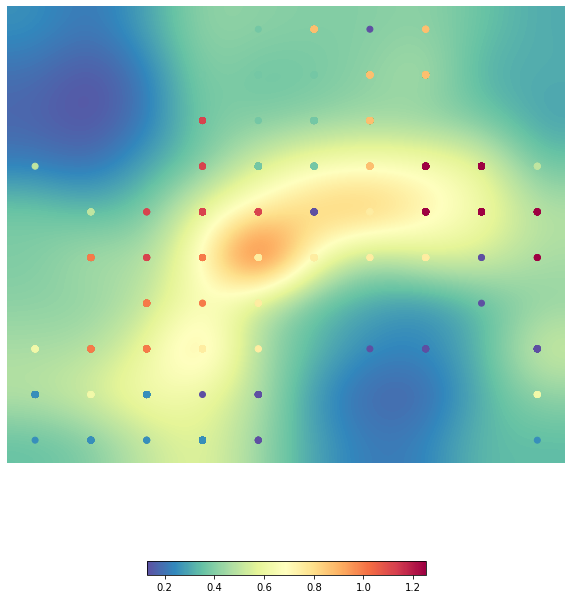

In [24]:
print("Clusters for 10x10 SOM : \n", som_c10_r10.clusters)

unique_values, counts = np.unique(som_c10_r10.clusters, return_counts=True)
print("Unique SOM values : " , unique_values)

#Εκτύπωση του U-matrix με τα ορίσματα της εκφώνησης
som_c10_r10.view_umatrix(bestmatches=True, colorbar=True, figsize=(10, 12)); matplotlib.pyplot.show()


Πολύ μεγάλη περιοχή ορίων και κακή χρήση των περιορισμένων για τις διαστάσεις νευρώνων. Συνιστάσται η χρήση μεγαλήτερου χάρτη.

### **20 x 20**

Clusters for 20x20 SOM : 
 [[15 15 15  7  7  7  7 14 14 14 14 14  6  6 13  8  8  8 16  8]
 [16 15 15 15 15  7  7 14 14 14 14 14  6  6  8  8 16 16 16 16]
 [ 0 15 15 15 15  1  1 14 14 14 14 14 14  6  8  8 16 16 16  0]
 [ 0  0 15  1  1  1  1  1 14  4  4  4  4  4 17 16 16 16  0  0]
 [17  1  1  1  1  1  1  1 14  4  4  4  4  4 18 17  0  0  0  0]
 [17  1  1  1  1  1  1  1  4  4  4  4  4  4  4 18 17 17 17 17]
 [10 10  1  1  1  1  1  1  4  4  4  4 19  4 18 18 18 18 17 18]
 [10 10 10  1  1  1  1  1  4  4 19 19 19 19 19 18 18 18 18 10]
 [10 10 10 10 10  1  1  1 12 19 19 19 19 19 19 18 18 10 10 10]
 [10 10 10 10 10 10 10 12 12 12  5  5  5 19 19 19 18 10 10 10]
 [10 10 10 10 10 10 12 12 12 12  5  5  5  5  5  9 10 10 10 10]
 [10 10 10 10 10 12 12 12 12 12  5  5  5  9  9  9  9  9 10  2]
 [ 2  2  2 11 11 11 11 11 12 12 12  9  9  9  9  9  9  2  2  2]
 [ 2  2  2 11 11 11 11 11 11 12 12  9  9  9  9  9  9  2  2  2]
 [ 2  2  2 11 11 11 11 11 11  3  9  9  9  9  9  9  2  2  2  2]
 [ 2  2  2  7 11 11 11 11  3

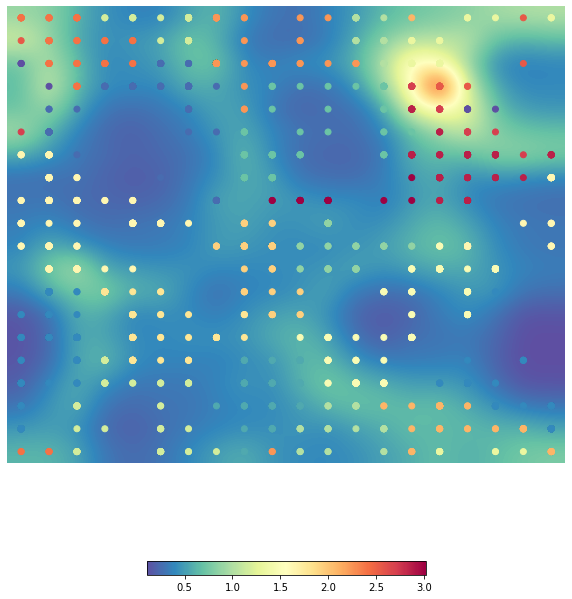

In [25]:
print("Clusters for 20x20 SOM : \n", som_c20_r20.clusters)

unique_values, counts = np.unique(som_c20_r20.clusters, return_counts=True)
print("Unique SOM values : " , unique_values)

#Εκτύπωση του U-matrix με τα ορίσματα της εκφώνησης
som_c20_r20.view_umatrix(bestmatches=True, colorbar=True, figsize=(10, 12)); matplotlib.pyplot.show()

Παρατηρούμε αχνά όρια και πρέπει να αυξήσουμε το k. Αλλά αποτελεί μια καλή επιλογή διάστασης.

### **30 x 30**

Clusters for 30x30 SOM : 
 [25 29  2  2  2  2  2  2 17 17 20 20 20 20 20 20 20 20 20 20 26  5  5  5
  5  5  5  5  5 29] [29 29  2  2  2  2  2  2 20 20 20 20 20 20 20 20 20 20 26 26 26 26  5  5
  5  5  5  5 29 29] [29 29 29 29  2  2 29 23  9  9  9  9  9 20 20 20 26 26 26 26 26 26  5  5
  5  5  5 29 29 29] [29 29 29 29 29 23 23 23  9  9  9  9  9  9  9  9 26 26 26 26 26 26 26  5
  5  5 29 29 29 29] [29 29 29 29 29 23 23 23 23 23  9  4  9  9  9  9 26 26 26 26 26 26 26  3
  5  5  5 29 29 29] [29 29 29 29 29 23 23 23 23 23  4  4  4  4  9 26 26 26 26 26 26  3  3  3
  3  3 29 29 29 29] [29 29 29 29 23 23 23 23 23 23  4  4  4  4 13 13 13 26 26 26 26  3  3  3
  3  3 29 29 29 29] [29 29 29 29 23 23 23 23  4  4  4 27  4 27  4 13 13 26 26 26  3  3  3  3
  3  3  3 29 29 29] [16 16 16 16 23 23 23 23 23  4 27 27 27 27 13 13 13 13 26 26  3  3  3  3
  3  3  3 16 16 16] [16 16 16 16 16 23 23 23  4 27 12 12 27 27 13 13 13 13 13  3  3  3  3  3
  3  3 16 16 16 16] [16 16 16 16 10 10 21 21  7  7  7 12  1  1 

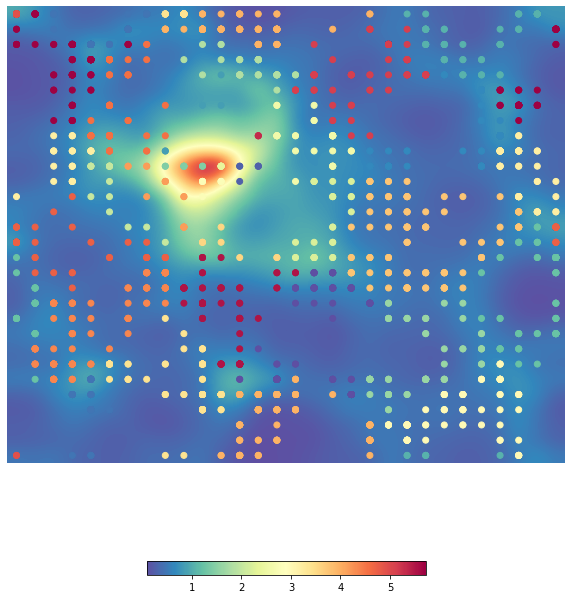

In [26]:
print("Clusters for 30x30 SOM : \n", *som_c30_r30.clusters)

unique_values, counts = np.unique(som_c30_r30.clusters, return_counts=True)
print("Unique SOM values : " , unique_values)

#Εκτύπωση του U-matrix με τα ορίσματα της εκφώνησης
som_c30_r30.view_umatrix(bestmatches=True, colorbar=True, figsize=(10, 12)); matplotlib.pyplot.show()

Παρατηρούμε ότι έχουν τεθεί αχνά όρια στις περιοχές του χάρτη. Επίσης παρατηρούμε αρκέτούς νευρώνες που δεν χρησιμοποιούνται. Θα προτείναμε την χρήση μια μικρότερης διάστασης χάρτη για το συγκεκριμένο σύνολο δεδομένων. 

### **40 x 40**

Clusters for 40x40 SOM : 
 [ 7 24 24 24  4  4  4  4 16 27 27 27  2 23 23 23 23 23 23 23 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13] [11 11  1  1  1  4  4 16 16 16 18 27  2 23 23 23 23 23 23 23 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13] [11 11  1  1  1  4  4 18 18 18 18  2  2  2 23 23 23 23 23 23 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13] [11  5 28 28  1 28 18 18 18 18 18 18  2  2 23 23 23 23 23 23 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13] [ 5  5 28 28 28 14 18 18 18 18 18  2  2  2  9  9 23 23 23 23 23 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13] [ 5  5 28 28 28 14 14 18 18 18 18  2  2  9  9  9  9  9 23 23 23 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13] [ 5 28 28 28 14 14 14 14 18  2  2  2  2  9  9  9  9  9  9  9 13  0  0  0
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13] [10 10 28 14 14 14 14 14 14 15  2 15  9  9  9  9  9  9  9  9  0  0  0  0
 13 13 13 13 13 13 13 13 25 25 25 25 25

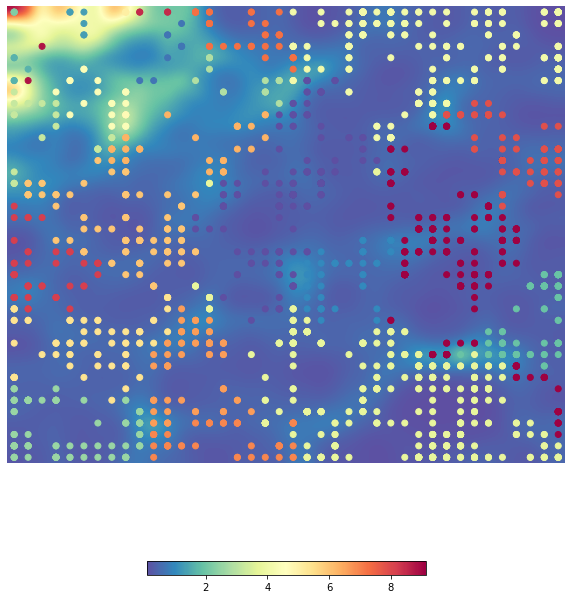

In [27]:
print("Clusters for 40x40 SOM : \n", *som_c40_r40.clusters)

unique_values, counts = np.unique(som_c40_r40.clusters, return_counts=True)
print("Unique SOM values : " , unique_values)

#Εκτύπωση του U-matrix με τα ορίσματα της εκφώνησης
som_c40_r40.view_umatrix(bestmatches=True, colorbar=True, figsize=(10, 12)); matplotlib.pyplot.show()

Παρατηρούμε μια πολύ μεγάλη περιοχή νευρώνων (μέση δεξιά) η οποία δεν χρησιμοποιείται και επίσης μια μεγάλη περιοχή νευρώνων που δεν χρησιμοποιείται στην μέση αριστερά. Ακόμη υπάρχει πολύ μεγάλη ομαδοποίηση στο κέντρο του πίνακα χωρίς να υπάρχουν όρια στην συγκεκριμένη περιοχή. Δεν θα συστίναμε την χρήση του χάρτη 40x40.


## 2.8 Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.


In [28]:
!pip install texttable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
#1.1 Πρώτος τρόπος εκτύπωσης των δεδομένων

from texttable import Texttable
def print_categories_stats_texttable(ids):
  total_movie_categories = []
  for id in ids:
      # Για κάθε ταινία στην λίστα ids δημιουργούμε μία λίστα με τις κατηγορίες της
      movie_categories_of_id = categories[id][0].split(",")  
      for category in movie_categories_of_id:            
          # Σε κάθε μία από αυτές αφαιρούμε το whitespace και την κάνουμε extend στην συνολική λίστα κατηγοριών
          total_movie_categories.extend([category.strip()])  
  # Μετράμε τις μοναδικές κατηγορίες και την συχνότητά τους                            
  unique_categories, counts = np.unique(total_movie_categories, return_counts=True) 
  # Παίρνουμε τoυς δείκτες των τιμών της λίστας counts ώστε αυτή να είναι ταξινομηνμένη        
  indexes_of_categories_sorted_in_descending_order = np.flip(np.argsort(counts))          
  # Δημιουργούμε την τελική ταξινομημένη λίστα από tuples της μορφής (Category,Counts) και προσθέτουμε τη πρώτη στήλη του πίνακα                                     
  result = [('Movie Category', 'Count')] + [(unique_categories[index], counts[index]) for index in indexes_of_categories_sorted_in_descending_order]  
  t = Texttable()
  t.add_rows(result)
  print(t.draw())


In [36]:
!pip install pandas 
import pandas as pd 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
#1.2 Δεύτερος τρόπος εκτύπωσης των δεδομένων

def print_categories_stats_pandas(ids):
  total_movie_categories = []
  for id in ids:
      # Για κάθε ταινία στην λίστα ids δημιουργούμε μία λίστα με τις κατηγορίες της
      movie_categories_of_id = categories[id][0].split(",")  
      for category in movie_categories_of_id:            
          # Σε κάθε μία από αυτές αφαιρούμε το whitespace και την κάνουμε extend στην συνολική λίστα κατηγοριών
          total_movie_categories.extend([category.strip()])  
  # Μετράμε τις μοναδικές κατηγορίες και την συχνότητά τους                            
  unique_categories, counts = np.unique(total_movie_categories, return_counts=True) 
  # Παίρνουμε τoυς δείκτες των τιμών της λίστας counts ώστε αυτή να είναι ταξινομηνμένη        
  indexes_of_categories_sorted_in_descending_order = np.flip(np.argsort(counts))          
  # Δημιουργούμε την τελική ταξινομημένη λίστα από tuples της μορφής (Category,Counts) και προσθέτουμε τη πρώτη στήλη του πίνακα                                     
  categories_stats_dict = dict([('Movie Category', 'Count')] + [(unique_categories[index], counts[index]) for index in indexes_of_categories_sorted_in_descending_order])
  categories_stats_df = pd.DataFrame.from_dict([categories_stats_dict])
  # Εκτυπώνουμε τα δεδομένα χρησιμοποιώντας την pandas
  if len(categories_stats_df.iloc[0]) < 2 : 
     print('No movies assigned to this neuron.')
 # if (categories_stats_df.iloc[0] == 0).any():
  #   
  else: 
    display(categories_stats_df.style.hide_index())
  

In [46]:
# Count the frequency of the categories of all movies
movie_indexes = list(range(0,5000)) #Select all the movies
print_categories_stats_pandas(movie_indexes)

Movie Category,"""Drama""","""Comedy""","""Thriller""","""Romance Film""","""Action""","""World cinema""","""Crime Fiction""","""Horror""","""Black-and-white""","""Action/Adventure""","""Indie""","""Adventure""","""Short Film""","""Family Film""","""Animation""","""Musical""","""Romantic drama""","""Science Fiction""","""Mystery""","""Fantasy""","""Comedy film""","""Romantic comedy""","""Crime Thriller""","""War film""","""Period piece""","""Comedy-drama""","""Silent film""","""Western""","""Japanese Movies""","""Film adaptation""","""Documentary""","""Psychological thriller""","""Chinese Movies""","""Bollywood""","""Black comedy""","""Children's/Family""","""Parody""","""Teen""","""Family Drama""","""Suspense""","""Coming of age""","""Sports""","""Martial Arts Film""","""Cult""","""Slasher""","""Film noir""","""Television movie""","""Biographical film""","""Supernatural""","""Political drama""","""Satire""","""Biography""","""Melodrama""","""Slapstick""","""Children's""","""Gangster Film""","""Art film""","""Creature Film""","""Action Thrillers""","""Historical fiction""","""Biopic [feature]""","""Spy""","""Crime Drama""","""B-movie""","""Music""","""Ensemble Film""","""Buddy film""","""Anime""","""Docudrama""","""Children's Fantasy""","""Costume drama""","""Detective""","""Horror Comedy""","""Zombie Film""","""Screwball comedy""","""Crime Comedy""","""Road movie""","""Superhero movie""","""Family-Oriented Adventure""","""Heist""","""Filipino Movies""","""Detective fiction""","""Epic""","""Disaster""","""Computer Animation""","""Domestic Comedy""","""History""","""Courtroom Drama""","""Fantasy Adventure""","""Political thriller""","""Marriage Drama""","""Animal Picture""","""Monster movie""","""Sex comedy""","""Culture & Society""","""Political cinema""","""Musical comedy""","""Sci-Fi Horror""","""Fantasy Comedy""","""Comedy of manners""","""Natural horror films""","""Comedy of Errors""","""Christian film""","""Experimental film""","""Mockumentary""","""Action Comedy""","""Chase Movie""","""Historical drama""","""Musical Drama""","""Holiday Film""","""Childhood Drama""","""Avant-garde""","""Surrealism""","""Swashbuckler films""","""Remake""","""Erotic thriller""","""Wuxia""","""Pre-Code""","""Stop motion""","""Superhero""","""Tamil cinema""","""Adventure Comedy""","""Monster""","""Caper story""","""Religious Film""","""Costume Adventure""","""Media Satire""","""Doomsday film""","""Blaxploitation""","""Christmas movie""","""Animated cartoon""","""Comedy Western""","""Gross out""","""Alien Film""","""Gothic Film""","""Absurdism""","""Gross-out film""","""Time travel""","""Slice of life story""","""Jungle Film""","""Spaghetti Western""","""Americana""","""Tragedy""","""Workplace Comedy""","""Political satire""","""Costume Horror""","""Prison""","""Combat Films""","""Roadshow theatrical release""","""Social problem film""","""Historical Epic""","""Romantic fantasy""","""Feminist Film""","""Animated Musical""","""Tollywood""","""Medical fiction""","""Dystopia""","""Rockumentary""","""Erotic Drama""","""Social issues""","""New Hollywood""","""Juvenile Delinquency Film""","""Dance""","""Fairy tale""","""Stoner film""","""Revisionist Western""","""Fan film""","""Mythological Fantasy""","""Tragicomedy""","""Propaganda film""","""Airplanes and airports""","""Boxing""","""Comedy Thriller""","""Sword and sorcery films""","""Sword and sorcery""","""Auto racing""","""Hagiography""","""Apocalyptic and post-apocalyptic fiction""","""Sci-Fi Adventure""","""Sword and Sandal""","""Punk rock""","""Neo-noir""","""Haunted House Film""","""Existentialism""","""Epic Western""","""Inspirational Drama""","""Hip hop movies""","""Future noir""","""Escape Film""","""Giallo""","""Albino bias""","""Samurai cinema""","""Crime""","""Anti-war film""","""Anti-war""","""Glamorized Spy Film""","""Kitchen sink realism""","""Children's Entertainment""","""Whodunit""","""Malayalam Cinema""","""British New Wave""","""Comedy horror""","""Road-Horror""","""Space weste

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus

In [47]:
# 2. Give a cluster number and print all the corresponding movies
def print_cluster_neurons_movies_report(som, n_cluster): # som: SOM object, unique_bmus: list of coordinates, n_cluster: the number of the cluster
  # Πάρε τη λίστα με τα unique_bmus για το αντίστοιχο SOM
  unique_bmus = np.unique(som.bmus, axis=0)
  # Για το συγκεκριμένο cluster βρίσκουμε τις συντεταγμένες όλων των νευρώνων
  row_coord, column_coord = np.where(som.clusters == n_cluster) 
  cluster_bmu_coordinates = np.column_stack((column_coord, row_coord))     # zip the row, column number of the wanted bmus
  # Φτιάχνουμε έναν πίνακα με τα bmu για το συγκεκριμένο cluster 
  cluster_bmu_indices  = []                       
  # Για κάθε bmu ελέγχω εάν ανήκει στα μοναδικά bmus (δηλαδή σε αυτά που έχει αντιστοιχηθεί ταινία)                          
  for bmu in cluster_bmu_coordinates: # bmu == pair (X, Y)
    bmu_index = np.where(np.all(unique_bmus == bmu, axis=1))[0]            # Βρες τη θέση του bmu στη λίστα unique_bmus       
    if bmu_index.size > 0:                                                 # Έλεγξε αν υπάρχει στη λίστα unique_bmus (αμα δεν υπάρχει το bmu_index θα είναι άδεια λίστα)
      cluster_bmu_indices.append(list(bmu))                                      # Αν ναι πρόσθεσέ τη στη λίστα 

  return cluster_bmu_indices                                               # Επιστρέφω τον πίνακα  bmus για το cluster               

In [48]:
# print_cluster_neurons_movies_report(som_c40_r40, 0)

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [49]:
def neuron_movies_report(som, neurons) : # som: SOM object, neurons: list of integers (which neurons belong to the corresponding class)
  cluster_movies = []                                                           # List of the returned movies' ids
  for neuron in neurons:                                                        
    matching_movies = np.where(np.all(som.bmus == neuron, axis=1))[0]        # For each neuron/bmu get all the movies that correspond to it 
    cluster_movies.extend(matching_movies)                                      # Append these movies to the list
  return cluster_movies

Θα φτίαξουμε άλλη μια συνάρτηση - σύνθεση των παραπάνω συναρτήσεων, ώστε να αποφύγουμε την επανάληψη κώδικα. 

In [64]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def som_report(som , map_size): 
  clusters = list(range(0, map_size))
  for cluster in clusters : 
    print("\033[1m Cluster number " , cluster + 1, " : \033[0m") 
    # Get the Neurons that correspond to the cluster
    cluster_neurons_list = print_cluster_neurons_movies_report(som , cluster)
    # Get the movies that correspond to all those Neurons
    cluster_movies_list = neuron_movies_report(som , cluster_neurons_list)
    
    # Print the stats of those movies (there should be a few categories with relatively big frequency)
    print_categories_stats_pandas(cluster_movies_list)
    #print_categories_stats_texttable(cluster_movies_list)
    print("\n")


In [68]:
som_report(som_c10_r10, 10) 

 Cluster number  1  : 


Movie Category,"""Drama""","""Family Film""","""Animation""","""Short Film""","""Comedy""","""Comedy film""","""Fantasy""","""Adventure""","""Children's/Family""","""Musical""","""Indie""","""Black-and-white""","""Horror""","""Romance Film""","""World cinema""","""Family Drama""","""Action/Adventure""","""Coming of age""","""Action""","""Film adaptation""","""Chinese Movies""","""Children's Fantasy""","""Costume drama""","""Western""","""Anime""","""Silent film""","""Children's""","""Documentary""","""War film""","""Thriller""","""Animal Picture""","""Family-Oriented Adventure""","""Biographical film""","""Holiday Film""","""Medical fiction""","""Roadshow theatrical release""","""Psychological thriller""","""Political cinema""","""Biography""","""Chase Movie""","""Childhood Drama""","""Children's Entertainment""","""Christmas movie""","""Costume Horror""","""Crime Drama""","""Zombie Film""","""Crime Fiction""","""Docudrama""","""Tragicomedy""","""Tragedy""","""Sword and sorcery""","""Sword and sorcery films""","""Swashbuckler films""","""Supernatural""","""Sports""","""Social problem film""","""Slapstick""","""Science Fiction""","""Romantic comedy""","""Period piece""","""Parody""","""Mythological Fantasy""","""Mystery""","""Musical Drama""","""Music""","""Japanese Movies""","""Existentialism""","""Historical fiction"""
Count,38,19,17,15,12,11,8,8,8,6,6,6,5,5,5,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  2  : 


Movie Category,"""Horror""","""Thriller""","""Romance Film""","""Mystery""","""Science Fiction""","""Slasher""","""Psychological thriller""","""Indie""","""Supernatural""","""World cinema""","""Creature Film""","""Action""","""Comedy film""","""Black-and-white""","""B-movie""","""Drama""","""Suspense""","""Cult""","""Crime Fiction""","""Crime Thriller""","""Fantasy""","""Teen""","""Musical""","""Sci-Fi Horror""","""Zombie Film""","""Romantic drama""","""Monster movie""","""Action/Adventure""","""Adventure""","""Filipino Movies""","""Short Film""","""Chinese Movies""","""Haunted House Film""","""Costume Horror""","""Family Film""","""Film adaptation""","""Television movie""","""Detective""","""Gothic Film""","""Detective fiction""","""Alien Film""","""Monster""","""Japanese Movies""","""War film""","""Dance""","""Stop motion""","""Surrealism""","""Sword and sorcery films""","""Sword and sorcery""","""Courtroom Drama""","""Costume drama""","""Animation""","""Comedy-drama""","""Comedy""","""Avant-garde""","""Comedy horror""","""Western""","""Christian film""","""Black comedy""","""Remake""","""Ensemble Film""","""Disaster""","""Doomsday film""","""Parody""","""Roadshow/Carny""","""Romantic comedy""","""Musical Drama""","""Mockumentary""","""Media Satire""","""Master Criminal Films""","""Horror Comedy""","""Silent film""","""Future noir""","""Film-Opera""","""Film noir""","""Sports""","""Fantasy Adventure""","""Exploitation""","""Experimental film""","""Erotic thriller""","""Epic""","""Roadshow theatrical release""","""Dystopia""","""Spy""","""Giallo"""
Count,129,74,35,30,26,20,19,16,15,14,13,12,11,10,10,9,9,9,8,7,7,7,7,6,5,5,4,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  3  : 


Movie Category,"""Drama""","""Thriller""","""Crime Fiction""","""Mystery""","""Crime Thriller""","""Action""","""Black-and-white""","""World cinema""","""Indie""","""Psychological thriller""","""Film noir""","""Film adaptation""","""Romance Film""","""Period piece""","""Suspense""","""Adventure""","""Action/Adventure""","""Political drama""","""Gangster Film""","""Docudrama""","""Horror""","""War film""","""Crime Drama""","""Courtroom Drama""","""Science Fiction""","""Television movie""","""Musical""","""Spy""","""Sports""","""Bollywood""","""Western""","""Detective""","""Supernatural""","""Art film""","""Comedy film""","""Detective fiction""","""Epic""","""Family Film""","""Coming of age""","""Caper story""","""Biographical film""","""Tamil cinema""","""Family Drama""","""Romantic drama""","""Heist""","""Road movie""","""Melodrama""","""Japanese Movies""","""Political thriller""","""New Hollywood""","""Neo-noir""","""Comedy Thriller""","""Combat Films""","""Christian film""","""Chase Movie""","""Prison""","""Comedy""","""Black comedy""","""Biography""","""Remake""","""Revisionist Western""","""Alien Film""","""Airplanes and airports""","""Comedy of Errors""","""Whodunit""","""Comedy-drama""","""Historical drama""","""Fantasy""","""Swashbuckler films""","""Existentialism""","""Escape Film""","""Erotic thriller""","""Historical Epic""","""Epic Western""","""Documentary""","""Haunted House Film""","""History""","""Disaster""","""Indian Western""","""Time travel""","""Juvenile Delinquency Film""","""Teen""","""Costume drama""","""Natural horror films"""
Count,177,116,92,48,45,25,24,24,23,19,18,17,15,14,14,11,10,10,10,9,9,9,8,7,6,6,5,5,5,5,4,4,4,4,4,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  4  : 


Movie Category,"""Comedy""","""Thriller""","""Action""","""Romance Film""","""Mystery""","""Crime Fiction""","""Romantic comedy""","""Black comedy""","""Cult""","""Action/Adventure""","""Adventure""","""Animal Picture""","""Black-and-white""","""Film noir""","""Drama""","""Screwball comedy""","""Heist""","""Hip hop movies""","""Indie""","""Musical""","""Psychological thriller""","""Science Fiction""","""Action Comedy"""
Count,10,7,3,3,3,3,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  5  : 


Movie Category,"""Documentary""","""Short Film""","""Comedy film""","""Animation""","""Silent film""","""Black-and-white""","""Musical""","""Japanese Movies""","""Family Film""","""Adventure""","""Science Fiction""","""Western""","""Indie""","""Fantasy""","""Culture & Society""","""Biography""","""World cinema""","""Bollywood""","""Comedy-drama""","""War film""","""Romantic comedy""","""Music""","""Chinese Movies""","""Children's""","""Crime Fiction""","""Experimental film""","""Mystery""","""Children's/Family""","""Historical drama""","""History""","""Pre-Code""","""Time travel""","""Rockumentary""","""Satire""","""Avant-garde""","""Surrealism""","""Action/Adventure""","""Filipino Movies""","""Anime""","""Crime Drama""","""Political cinema""","""Black comedy""","""Sports""","""Social issues""","""Historical fiction""","""Detective""","""Biographical film""","""Concert film""","""Costume drama""","""Computer Animation""","""Christmas movie""","""Childhood Drama""","""Detective fiction""","""Animal Picture""","""Children's Entertainment""","""Wuxia""","""Fan film""","""Punk rock""","""World History""","""Travel""","""Tragedy""","""Television movie""","""Tamil cinema""","""Sword and sorcery""","""Suspense""","""Superhero""","""Superhero movie""","""Stop motion""","""Spaghetti Western""","""Psychological thriller""","""Film noir""","""Political satire""","""Political drama""","""Parody""","""Musical comedy""","""Mockumentary""","""Melodrama""","""Jungle Film""","""Heist""","""Hagiography""","""Future noir""","""Foreign legion""","""Action"""
Count,44,44,34,28,25,21,18,17,15,12,12,11,10,9,8,6,6,5,5,5,5,5,5,5,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  6  : 


Movie Category,"""Comedy""","""Family Film""","""Short Film""","""Animation""","""Drama""","""Horror""","""Adventure""","""Action""","""Fantasy""","""Thriller""","""Action/Adventure""","""Children's/Family""","""World cinema""","""Science Fiction""","""Crime Fiction""","""Black-and-white""","""Romance Film""","""Comedy film""","""Chinese Movies""","""Indie""","""Computer Animation""","""Western""","""Martial Arts Film""","""Family-Oriented Adventure""","""Period piece""","""Children's""","""Cult""","""Musical""","""War film""","""Sports""","""Natural horror films""","""Music""","""Creature Film""","""Zombie Film""","""Wuxia""","""Teen""","""Slasher""","""Japanese Movies""","""Horror Comedy""","""Children's Fantasy""","""Family Drama""","""Parody""","""Mystery""","""Documentary""","""Silent film""","""Black comedy""","""Monster movie""","""Film adaptation""","""Television movie""","""Fairy tale""","""Supernatural""","""Superhero movie""","""Costume Horror""","""Fantasy Adventure""","""Slapstick""","""Screwball comedy""","""Animal Picture""","""Comedy-drama""","""Animated cartoon""","""Satire""","""Crime Thriller""","""Psychological thriller""","""Buddy film""","""Political drama""","""Blaxploitation""","""Comedy of manners""","""Biography""","""Comedy of Errors""","""Biopic [feature]""","""Biographical film""","""B-movie""","""Apocalyptic and post-apocalyptic fiction""","""Anime""","""Animated Musical""","""Alien Film""","""Coming of age""","""Historical drama""","""Costume Adventure""","""Musical Drama""","""Therimin music""","""Sword and sorcery films""","""Superhero""","""Spy""","""Sex comedy""","""Science fiction Western""","""Sci-Fi Horror""","""Romantic drama""","""Romantic comedy""","""Road movie""","""Remake""","""New Hollywood""","""Movie serial""","""Costume drama""","""Monster""","""Mondo film""","""Mockumentary""","""Indian Western""","""Holiday Film""","""Historical fiction""","""Glamorized Spy Film""","""Gangster Film""","""Fantasy Comedy""","""Domestic Comedy""","""Docudrama""","""Culture & Society""","""Action Thrillers"""
Count,56,50,39,38,33,31,25,20,20,15,15,12,11,9,9,9,9,8,8,6,6,6,5,5,5,5,5,5,5,5,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  7  : 


Movie Category,"""Drama""","""Romance Film""","""World cinema""","""Romantic drama""","""Black-and-white""","""Period piece""","""Indie""","""Musical""","""War film""","""Film adaptation""","""Bollywood""","""Family Drama""","""Coming of age""","""Family Film""","""Comedy film""","""Biographical film""","""Biopic [feature]""","""Biography""","""Television movie""","""Political drama""","""Adventure""","""Melodrama""","""Art film""","""Comedy-drama""","""Chinese Movies""","""Action""","""Action/Adventure""","""Sports""","""Short Film""","""Docudrama""","""Science Fiction""","""Silent film""","""Japanese Movies""","""Documentary""","""Teen""","""Fantasy""","""Historical fiction""","""Marriage Drama""","""Christian film""","""Western""","""Romantic comedy""","""Costume drama""","""Musical Drama""","""Epic""","""History""","""Satire""","""Crime Fiction""","""Erotic Drama""","""Ensemble Film""","""Children's/Family""","""Inspirational Drama""","""Spy""","""Music""","""Black comedy""","""Tragedy""","""Animation""","""Children's""","""Social problem film""","""Slice of life story""","""Childhood Drama""","""Surrealism""","""Tamil cinema""","""Americana""","""Pre-Code""","""Historical drama""","""Medical fiction""","""Road movie""","""Mystery""","""Dystopia""","""Thriller""","""Buddy film""","""Malayalam Cinema""","""Musical comedy""","""Backstage Musical""","""Samurai cinema""","""New Hollywood""","""Parody""","""Animal Picture""","""Remake""","""Albino bias""","""Tragicomedy""","""Propaganda film""","""Kitchen sink realism""","""Horror""","""Political thriller""","""Feminist Film""","""Epic Western""","""Existentialism""","""Disaster""","""Dance""","""Culture & Society""","""Cult""","""Crime Drama""","""Holiday Film""","""Courtroom Drama""","""Filipino Movies""","""Computer Animation""","""Film noir""","""Social issues""","""Hagiography""","""Historical Epic"""
Count,468,115,83,71,42,37,35,32,31,25,24,24,20,19,17,16,15,15,14,14,13,13,12,11,10,10,8,8,8,7,7,7,6,5,5,5,5,5,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  8  : 


Movie Category,"""Action""","""Adventure""","""Action/Adventure""","""Science Fiction""","""Fantasy""","""Western""","""Comedy""","""World cinema""","""Japanese Movies""","""Thriller""","""Animation""","""Martial Arts Film""","""Drama""","""Family Film""","""Anime""","""Black-and-white""","""Superhero movie""","""Chinese Movies""","""War film""","""Indie""","""Crime Fiction""","""Fantasy Adventure""","""Historical fiction""","""Spy""","""Horror""","""Romance Film""","""Parody""","""Cult""","""Buddy film""","""Children's Fantasy""","""Children's/Family""","""Children's""","""Heist""","""Action Comedy""","""Stop motion""","""Sports""","""Spaghetti Western""","""Mystery""","""Swashbuckler films""","""Costume Adventure""","""Disaster""","""Short Film""","""Crime Comedy""","""Blaxploitation""","""Costume drama""","""Superhero""","""Computer Animation""","""Biographical film""","""Silent film""","""Comedy film""","""Comedy Western""","""Space western""","""Biopic [feature]""","""Monster""","""Adventure Comedy""","""Auto racing""","""Action Thrillers""","""Romantic comedy""","""Gangster Film""","""Sword and sorcery films""","""B-movie""","""Period piece""","""Mythological Fantasy""","""Cavalry Film""","""Tollywood""","""Time travel""","""Caper story""","""Sword and sorcery""","""Television movie""","""Anti-war film""","""Anti-war""","""Apocalyptic and post-apocalyptic fiction""","""Black comedy""","""Biography""","""Coming of age""","""Chase Movie""","""Comedy Thriller""","""Marriage Drama""","""Musical""","""Hybrid Western""","""Horror Comedy""","""History""","""Historical Epic""","""Political thriller""","""Film adaptation""","""Romantic drama""","""Fantasy Comedy""","""Samurai cinema""","""Family-Oriented Adventure""","""Satire""","""Fairy tale""","""Sci-Fi Adventure""","""Sci-Fi Horror""","""Crime Drama""","""Creature Film""","""Movie serial""","""Filipino Movies"""
Count,109,65,64,31,30,26,25,22,15,14,14,12,11,11,9,9,9,9,8,8,7,7,7,6,6,5,5,4,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  9  : 


Movie Category,"""Action""","""Thriller""","""Action/Adventure""","""Crime Fiction""","""Drama""","""Crime Thriller""","""Action Thrillers""","""Mystery""","""Adventure""","""Comedy""","""Martial Arts Film""","""World cinema""","""Suspense""","""Indie""","""Psychological thriller""","""Gangster Film""","""Heist""","""Romance Film""","""Western""","""Chinese Movies""","""Film adaptation""","""Comedy-drama""","""War film""","""Crime Comedy""","""Political thriller""","""Detective""","""Black comedy""","""Spy""","""Bollywood""","""Japanese Movies""","""Remake""","""Black-and-white""","""Science Fiction""","""Supernatural""","""Fantasy""","""Detective fiction""","""Superhero""","""Horror""","""Superhero movie""","""Comedy film""","""Buddy film""","""Biography""","""Biographical film""","""Caper story""","""B-movie""","""Animals""","""Tollywood""","""Tragicomedy""","""Chase Movie""","""Sports""","""Television movie""","""Cult""","""Disaster""","""Slasher""","""Erotic thriller""","""Nature""","""Neo-noir""","""Parkour in popular culture""","""Parody""","""Prison""","""Reboot""","""Road movie""","""Silent film""","""History"""
Count,95,93,64,62,42,30,18,16,15,11,11,11,11,10,6,6,6,5,5,4,4,4,4,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  10  : 


Movie Category,"""Comedy""","""Drama""","""Romance Film""","""Romantic comedy""","""Indie""","""Black-and-white""","""Short Film""","""World cinema""","""Family Film""","""Musical""","""Comedy-drama""","""Romantic drama""","""Parody""","""Black comedy""","""Animation""","""Horror""","""Slapstick""","""Action""","""Fantasy""","""Silent film""","""Crime Fiction""","""Satire""","""Bollywood""","""Teen""","""Science Fiction""","""Adventure""","""Ensemble Film""","""Coming of age""","""Screwball comedy""","""Action/Adventure""","""Period piece""","""Fantasy Comedy""","""Sex comedy""","""Thriller""","""Comedy of manners""","""Buddy film""","""Cult""","""Sports""","""Domestic Comedy""","""Political cinema""","""Comedy of Errors""","""Horror Comedy""","""Chinese Movies""","""Media Satire""","""Family Drama""","""Mystery""","""Gross-out film""","""Adventure Comedy""","""Crime Comedy""","""Japanese Movies""","""Stoner film""","""War film""","""Film adaptation""","""Art film""","""Workplace Comedy""","""Gross out""","""Children's""","""Absurdism""","""Political drama""","""Animal Picture""","""Television movie""","""Surrealism""","""Superhero movie""","""Musical comedy""","""Mockumentary""","""Music""","""Remake""","""Punk rock""","""Religious Film""","""Avant-garde""","""Political satire""","""Romantic fantasy""","""Computer Animation""","""Western""","""Road movie""","""Documentary""","""Heist""","""Biopic [feature]""","""Holiday Film""","""Filipino Movies""","""B-movie""","""Melodrama""","""Biographical film""","""Family-Oriented Adventure""","""Biography""","""Experimental film""","""Children's/Family""","""Addiction Drama""","""Caper story""","""Animated cartoon""","""Action Thrillers""","""Action Comedy""","""Childhood Drama""","""Zombie Film""","""Christmas movie""","""Hip hop movies""","""Tollywood""","""Time travel""","""Stand-up comedy""","""Spy""","""Slice of life story""","""Slasher""","""Psychological thriller""","""Natural horror films""","""Martial Arts Film""","""Malayalam Cinema""","""Heavenly Comedy""","""Comedy Western""","""Feminist Film""","""Fan film""","""Exploitation""","""Escape Film""","""Docudrama""","""Detective""","""Detective fiction""","""Crime Drama""","""Costume drama""","""Comedy film""","""Gangster Film"""
Count,377,123,91,64,52,50,49,44,40,38,34,28,26,20,20,17,16,16,16,15,13,12,12,11,11,10,10,10,9,8,8,8,8,7,7,6,6,6,6,6,6,6,5,5,5,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Παρατηρούμε μεγάλες ανομοιότητες στον διαχωρισμό των ταινιών και πολλά "άδικα" χωρίσματα. Συγκεκριμένα παρατηρούμε στις κατηγορίες Comedy και Drama έντονα την παραπάνω αδικία. 

In [67]:
som_report(som_c20_r20, 20)

 Cluster number  1  : 


Movie Category,"""Horror""","""Animation""","""Fantasy""","""Children's/Family""","""Thriller""","""Horror Comedy""","""Creature Film""","""Children's""","""Children's Fantasy""","""Fairy tale""","""Family Film""","""Computer Animation""","""Comedy""","""Black-and-white""","""Natural horror films""","""Adventure""","""Buddy film""","""B-movie""","""Apocalyptic and post-apocalyptic fiction""","""Animated Musical""","""Zombie Film""","""Documentary""","""Crime Fiction""","""Cult""","""Drama""","""Holiday Film""","""Indie""","""Mondo film""","""Monster""","""Science Fiction""","""Short Film""","""Teen""","""Action"""
Count,5,4,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  2  : 


Movie Category,"""Horror""","""Science Fiction""","""Indie""","""Black-and-white""","""Comedy""","""Silent film""","""Creature Film""","""Short Film""","""B-movie""","""Fantasy""","""World cinema""","""Action""","""Japanese Movies""","""Mystery""","""Western""","""Slasher""","""Cult""","""Zombie Film""","""Action/Adventure""","""Adventure""","""Sci-Fi Horror""","""Chinese Movies""","""Anime""","""Horror Comedy""","""Sports""","""Surrealism""","""Teen""","""Comedy film""","""Filipino Movies""","""Black comedy""","""Television movie""","""Supernatural""","""Monster""","""Animation""","""Parody""","""Thriller""","""Avant-garde""","""Apocalyptic and post-apocalyptic fiction""","""Time travel""","""Children's Entertainment""","""Children's Fantasy""","""Children's/Family""","""Christmas movie""","""Animated cartoon""","""Alien Film""","""Comedy horror""","""War film""","""Detective fiction""","""Costume Horror""","""Crime Fiction""","""Romance Film""","""Roadshow/Carny""","""Psychological thriller""","""Natural horror films""","""Stoner film""","""Music""","""Monster movie""","""Martial Arts Film""","""Suspense""","""Sword and sorcery films""","""Gothic Film""","""Sword and sorcery""","""Fantasy Adventure""","""Family Film""","""Exploitation""","""Experimental film""","""Detective""","""Holiday Film"""
Count,77,20,18,16,14,11,10,10,9,8,7,7,6,6,6,6,5,5,4,4,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  3  : 


Movie Category,"""Drama""","""Indie""","""Black-and-white""","""Family Drama""","""Family Film""","""Thriller""","""Coming of age""","""Period piece""","""Biographical film""","""War film""","""Film adaptation""","""Biography""","""Musical""","""Television movie""","""Biopic [feature]""","""Political drama""","""Adventure""","""Action""","""Short Film""","""Sports""","""Teen""","""Docudrama""","""Comedy-drama""","""Historical fiction""","""Chinese Movies""","""Bollywood""","""Melodrama""","""World cinema""","""Science Fiction""","""Mystery""","""Art film""","""Children's""","""Children's/Family""","""Christian film""","""Horror""","""Film noir""","""Black comedy""","""Childhood Drama""","""Silent film""","""Comedy film""","""Crime Drama""","""Crime Fiction""","""Fantasy""","""Documentary""","""Medical fiction""","""Musical Drama""","""Inspirational Drama""","""Music""","""Historical drama""","""Social problem film""","""Malayalam Cinema""","""Marriage Drama""","""New Hollywood""","""Buddy film""","""Slice of life story""","""Spy""","""Suspense""","""Tamil cinema""","""Backstage Musical""","""Animal Picture""","""Americana""","""Tragedy""","""Juvenile Delinquency Film""","""Parody""","""Psychological thriller""","""Dystopia""","""Feminist Film""","""Propaganda film""","""Remake""","""Road movie""","""Existentialism""","""Erotic thriller""","""Erotic Drama""","""Romantic comedy""","""Satire""","""Neo-noir""","""Romantic drama""","""Dance""","""Cult""","""Pre-Code""","""Holiday Film""","""Courtroom Drama""","""History"""
Count,287,25,23,14,13,13,13,11,10,10,9,8,8,8,7,7,7,7,6,5,5,4,4,4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  4  : 


Movie Category,"""Thriller""","""Action""","""Action/Adventure""","""Crime Fiction""","""Drama""","""Crime Thriller""","""Action Thrillers""","""World cinema""","""Martial Arts Film""","""Comedy""","""Gangster Film""","""Indie""","""Adventure""","""Suspense""","""Heist""","""Horror""","""Science Fiction""","""Remake""","""Romance Film""","""Psychological thriller""","""Chinese Movies""","""Spy""","""Film adaptation""","""Japanese Movies""","""War film""","""B-movie""","""Sports""","""Western""","""Supernatural""","""Parody""","""Mystery""","""Political thriller""","""Chase Movie""","""Prison""","""Tollywood""","""Superhero movie""","""Animals""","""Auto racing""","""Biographical film""","""Biography""","""Black comedy""","""Bollywood""","""Buddy film""","""Caper story""","""Road movie""","""Horror Comedy""","""Comedy film""","""Parkour in popular culture""","""Creature Film""","""Crime Comedy""","""Television movie""","""Reboot""","""Disaster""","""Nature""","""Superhero""","""Musical""","""History""","""Tamil cinema"""
Count,73,72,59,41,30,20,17,11,10,10,6,6,5,5,5,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  5  : 


Movie Category,"""Comedy""","""Black-and-white""","""Short Film""","""Indie""","""Parody""","""Musical""","""Family Film""","""Slapstick""","""World cinema""","""Black comedy""","""Silent film""","""Satire""","""Action""","""Teen""","""Science Fiction""","""Crime Fiction""","""Domestic Comedy""","""Sex comedy""","""Screwball comedy""","""Bollywood""","""Horror""","""Cult""","""Comedy of Errors""","""Fantasy""","""Action/Adventure""","""Gross out""","""Gross-out film""","""Absurdism""","""Comedy-drama""","""Horror Comedy""","""Buddy film""","""Mystery""","""Fantasy Comedy""","""Political cinema""","""Comedy of manners""","""Chinese Movies""","""Children's""","""Punk rock""","""Superhero movie""","""Television movie""","""Ensemble Film""","""Stoner film""","""Adventure""","""Musical comedy""","""Workplace Comedy""","""Thriller""","""Western""","""Music""","""Mockumentary""","""Christmas movie""","""Biography""","""Surrealism""","""Adventure Comedy""","""Caper story""","""Action Comedy""","""Animal Picture""","""Media Satire""","""Comedy Western""","""Sports""","""Coming of age""","""Martial Arts Film""","""Remake""","""Detective fiction""","""Detective""","""Political satire""","""Escape Film""","""Fan film""","""Feminist Film""","""Heist""","""Hip hop movies""","""Holiday Film""","""Japanese Movies""","""Computer Animation"""
Count,169,33,29,20,19,16,15,15,12,11,10,9,8,6,6,5,5,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  6  : 


Movie Category,"""Comedy""","""Romance Film""","""Romantic comedy""","""Drama""","""Romantic drama""","""Musical""","""Comedy-drama""","""World cinema""","""Indie""","""Bollywood""","""Black-and-white""","""Screwball comedy""","""Comedy of manners""","""Sex comedy""","""Sports""","""Ensemble Film""","""Period piece""","""Fantasy""","""Chinese Movies""","""Buddy film""","""Adventure""","""Family Drama""","""Family Film""","""Action/Adventure""","""Action""","""Teen""","""Science Fiction""","""Media Satire""","""Coming of age""","""Tollywood""","""Adventure Comedy""","""Thriller""","""Biographical film""","""Biopic [feature]""","""Surrealism""","""Slice of life story""","""Slapstick""","""Comedy of Errors""","""Silent film""","""Satire""","""Costume drama""","""Melodrama""","""Crime Comedy""","""Crime Fiction""","""Cult""","""Domestic Comedy""","""Romantic fantasy""","""Religious Film""","""Parody""","""Mystery""","""Fantasy Comedy""","""Music""","""Film adaptation""","""Workplace Comedy""","""Hip hop movies""","""Gangster Film"""
Count,70,70,57,40,21,13,10,10,9,6,5,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  7  : 


Movie Category,"""Action/Adventure""","""Adventure""","""Action""","""Drama""","""Science Fiction""","""Fantasy""","""World cinema""","""Thriller""","""Comedy""","""Western""","""Martial Arts Film""","""Chinese Movies""","""Family Film""","""Black-and-white""","""War film""","""Indie""","""Japanese Movies""","""Fantasy Adventure""","""Swashbuckler films""","""Historical fiction""","""Film adaptation""","""Crime Fiction""","""Superhero movie""","""Costume drama""","""Adventure Comedy""","""Comedy Western""","""Action Thrillers""","""Historical Epic""","""Children's Fantasy""","""Chase Movie""","""Buddy film""","""Anime""","""Action Comedy""","""Spaghetti Western""","""Short Film""","""Stop motion""","""Silent film""","""Romance Film""","""Mythological Fantasy""","""Period piece""","""Monster""","""Comedy Thriller""","""Science fiction Western""","""Children's/Family""","""Space western""","""Anti-war film""","""Anti-war""","""Satire""","""Sports""","""Animation""","""Superhero""","""Suspense""","""Sword and sorcery films""","""Sword and sorcery""","""Sci-Fi Adventure""","""Crime Drama""","""Samurai cinema""","""Indian Western""","""Hybrid Western""","""Horror""","""Musical Drama""","""Musical comedy""","""Musical""","""Heist""","""Future noir""","""Fantasy Comedy""","""Road movie""","""Roadshow theatrical release""","""Dystopia""","""Disaster""","""Cult""","""Crime Thriller""","""Romantic comedy""","""History"""
Count,49,47,41,26,17,15,14,14,14,11,8,7,7,6,6,5,4,4,4,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  8  : 


Movie Category,"""Thriller""","""Mystery""","""Drama""","""Crime Thriller""","""Horror""","""Psychological thriller""","""Crime Fiction""","""Suspense""","""Science Fiction""","""Indie""","""Black-and-white""","""Supernatural""","""World cinema""","""Comedy""","""Film adaptation""","""Detective""","""Slasher""","""Adventure""","""Courtroom Drama""","""Action""","""Detective fiction""","""Action/Adventure""","""Black comedy""","""Haunted House Film""","""Romance Film""","""Docudrama""","""Family Film""","""Alien Film""","""Comedy film""","""Spy""","""Disaster""","""Erotic thriller""","""Gangster Film""","""Heist""","""Film noir""","""Fantasy""","""Existentialism""","""Japanese Movies""","""Western""","""Natural horror films""","""Animation""","""Neo-noir""","""Television movie""","""Bollywood""","""Christian film""","""Comedy Thriller""","""Gothic Film""","""Short Film""","""Screwball comedy""","""Sci-Fi Horror""","""Whodunit""","""Political thriller""","""Melodrama""","""Documentary""","""Doomsday film""","""Remake""","""Mockumentary"""
Count,116,60,33,32,32,29,20,18,12,10,10,9,8,7,7,6,6,5,5,5,4,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  9  : 


Movie Category,"""Drama""","""Action""","""Action/Adventure""","""World cinema""","""Comedy""","""Chinese Movies""","""Family Film""","""Adventure""","""Romance Film""","""Martial Arts Film""","""Wuxia""","""Crime Fiction""","""Period piece""","""Fantasy""","""War film""","""Short Film""","""Historical fiction""","""Biographical film""","""Thriller""","""Black-and-white""","""Biopic [feature]""","""Western""","""Family Drama""","""Comedy film""","""Animation""","""Sports""","""Screwball comedy""","""Spy""","""Documentary""","""Biography""","""Animal Picture""","""Crime Thriller""","""Children's/Family""","""Family-Oriented Adventure""","""Black comedy""","""Costume Adventure""","""Indian Western""","""Fantasy Adventure""","""Romantic comedy""","""Television movie""","""Sword and sorcery films""","""Superhero""","""Superhero movie""","""Slapstick""","""Silent film""","""Sex comedy""","""Science Fiction""","""Romantic drama""","""Road movie""","""Glamorized Spy Film""","""Remake""","""Psychological thriller""","""Political drama""","""Parody""","""Natural horror films""","""Medical fiction""","""Indie""","""History""","""Historical drama""","""Action Thrillers"""
Count,19,13,11,9,9,9,7,7,6,5,4,4,4,4,4,3,3,3,3,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  10  : 


Movie Category,"""Drama""","""Romance Film""","""World cinema""","""Romantic drama""","""Musical""","""Bollywood""","""Black-and-white""","""Period piece""","""Film adaptation""","""Comedy""","""Indie""","""Art film""","""Thriller""","""War film""","""Action/Adventure""","""Action""","""Melodrama""","""Family Drama""","""Japanese Movies""","""Comedy-drama""","""Chinese Movies""","""Western""","""Coming of age""","""Epic""","""Adventure""","""Comedy film""","""Television movie""","""Marriage Drama""","""Family Film""","""Costume drama""","""Crime Fiction""","""Political drama""","""Biographical film""","""Mystery""","""Satire""","""Sports""","""Biopic [feature]""","""Ensemble Film""","""Romantic comedy""","""Spy""","""Surrealism""","""Science Fiction""","""Tamil cinema""","""Epic Western""","""Erotic Drama""","""Fantasy""","""Filipino Movies""","""Christian film""","""Road movie""","""Teen""","""Psychological thriller""","""History""","""Horror""","""Biography""","""Black comedy""","""Avant-garde""","""Americana""","""Comedy of manners""","""Tragicomedy""","""Animation""","""Tragedy""","""Computer Animation""","""Slice of life story""","""Crime Comedy""","""Disaster""","""Samurai cinema""","""Social problem film""","""Spaghetti Western""","""Pre-Code""","""Parody""","""Musical Drama""","""Music""","""Kitchen sink realism""","""Inspirational Drama""","""Supernatural""","""Historical drama""","""Historical Epic""","""Hagiography""","""Film noir""","""Silent film""","""Experimental film""","""Suspense""","""Documentary""","""Docudrama""","""Historical fiction"""
Count,199,131,107,79,27,26,20,20,18,15,15,14,14,11,11,10,9,9,9,7,6,6,5,5,5,5,5,5,4,4,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  11  : 


Movie Category,"""Comedy film""","""Documentary""","""Romance Film""","""Musical""","""Short Film""","""Silent film""","""Adventure""","""Western""","""Black-and-white""","""Drama""","""Japanese Movies""","""Science Fiction""","""Culture & Society""","""Fantasy""","""Indie""","""Action/Adventure""","""Biography""","""War film""","""Sports""","""Music""","""Bollywood""","""Romantic comedy""","""Crime Fiction""","""World cinema""","""Comedy-drama""","""Mystery""","""Action""","""Romantic drama""","""Satire""","""Rockumentary""","""Time travel""","""Chinese Movies""","""Historical drama""","""History""","""Social issues""","""Experimental film""","""Political cinema""","""Surrealism""","""Black comedy""","""Family Film""","""Pre-Code""","""Historical fiction""","""Filipino Movies""","""Avant-garde""","""Anime""","""Costume drama""","""Costume Adventure""","""Tamil cinema""","""Computer Animation""","""Crime Drama""","""Suspense""","""Comedy""","""Concert film""","""Parody""","""Christmas movie""","""Psychological thriller""","""Superhero""","""Television movie""","""Punk rock""","""Tragedy""","""Biographical film""","""Animation""","""Travel""","""World History""","""Chase Movie""","""Detective""","""Dance""","""Detective fiction""","""Musical comedy""","""Musical Drama""","""Political drama""","""Mockumentary""","""Melodrama""","""Jungle Film""","""Space western""","""Spaghetti Western""","""Political satire""","""Heist""","""Future noir""","""Foreign legion""","""Film-Opera""","""Film noir""","""Spy""","""Fan film""","""Roadshow theatrical release""","""Epic""","""Ensemble Film""","""Stand-up comedy""","""Superhero movie""","""Wuxia"""
Count,54,49,31,26,25,21,19,18,17,16,14,13,10,9,9,9,8,6,5,5,5,5,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  12  : 


Movie Category,"""Crime Fiction""","""Drama""","""Thriller""","""Crime Thriller""","""Mystery""","""Action""","""Film noir""","""Black-and-white""","""Indie""","""World cinema""","""Gangster Film""","""Crime Drama""","""Film adaptation""","""Psychological thriller""","""Suspense""","""Comedy""","""Comedy-drama""","""Romance Film""","""Action/Adventure""","""Television movie""","""Art film""","""Coming of age""","""Courtroom Drama""","""Docudrama""","""Political drama""","""Period piece""","""Horror""","""Heist""","""Detective""","""Black comedy""","""Caper story""","""Detective fiction""","""Crime Comedy""","""Sports""","""Comedy of Errors""","""Road movie""","""Adventure""","""Albino bias""","""Revisionist Western""","""Superhero""","""Tragicomedy""","""Western""","""Comedy film""","""Musical""","""Melodrama""","""Fantasy""","""Family Film""","""New Hollywood""","""Family Drama""","""Superhero movie""","""Tragedy""","""Tollywood""","""Cult""","""Pre-Code"""
Count,93,85,43,29,22,15,15,13,10,9,8,8,6,6,6,5,5,5,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  13  : 


Movie Category,"""Comedy""","""Drama""","""Indie""","""Comedy-drama""","""Black-and-white""","""World cinema""","""Black comedy""","""Coming of age""","""Action""","""Crime Fiction""","""Fantasy""","""Family Film""","""Silent film""","""Thriller""","""Period piece""","""Ensemble Film""","""Family Drama""","""War film""","""Political drama""","""Political cinema""","""Musical""","""Short Film""","""Crime Comedy""","""Crime Drama""","""Comedy of manners""","""Science Fiction""","""Romance Film""","""Animation""","""Romantic comedy""","""Parody""","""Media Satire""","""Slapstick""","""Film adaptation""","""Childhood Drama""","""Chinese Movies""","""Stoner film""","""Comedy film""","""Comedy of Errors""","""Buddy film""","""Adventure""","""Addiction Drama""","""Action/Adventure""","""Teen""","""Avant-garde""","""Domestic Comedy""","""Cult""","""Documentary""","""Road movie""","""Experimental film""","""Exploitation""","""Workplace Comedy""","""Fantasy Comedy""","""Satire""","""Filipino Movies""","""Japanese Movies""","""Melodrama""","""Mockumentary""","""Mystery""","""Remake""","""Action Thrillers"""
Count,74,74,21,21,11,8,7,7,5,5,5,5,5,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  14  : 


Movie Category,"""Drama""","""War film""","""Period piece""","""Political drama""","""Adventure""","""Family Film""","""Biographical film""","""Biography""","""World cinema""","""Action""","""Biopic [feature]""","""Docudrama""","""Coming of age""","""Black-and-white""","""Family Drama""","""Thriller""","""Romance Film""","""Comedy""","""Action/Adventure""","""Film adaptation""","""Fantasy""","""Political thriller""","""Television movie""","""Indie""","""Spy""","""Western""","""Animation""","""Costume drama""","""Science Fiction""","""Children's/Family""","""Epic""","""Japanese Movies""","""Family-Oriented Adventure""","""Musical Drama""","""Romantic drama""","""Tragicomedy""","""Airplanes and airports""","""Animal Picture""","""Romantic comedy""","""Anime""","""Roadshow theatrical release""","""Social problem film""","""Sports""","""Musical""","""Cavalry Film""","""Children's""","""Chinese Movies""","""Existentialism""","""Combat Films""","""Horror""","""Costume Adventure""","""Costume Horror""","""Holiday Film""","""Crime Fiction""","""History""","""Historical drama""","""Ensemble Film""","""Fantasy Adventure""","""Escape Film""","""Silent film"""
Count,62,24,18,10,9,8,8,7,7,6,6,6,6,6,6,5,4,4,4,4,4,3,3,3,3,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  15  : 


Movie Category,"""Action""","""Adventure""","""Action/Adventure""","""Comedy""","""Thriller""","""Fantasy""","""Crime Fiction""","""Science Fiction""","""Indie""","""Japanese Movies""","""Spy""","""Superhero movie""","""Animation""","""Parody""","""Anime""","""Romance Film""","""Western""","""Black-and-white""","""Martial Arts Film""","""Buddy film""","""Fantasy Adventure""","""World cinema""","""Comedy film""","""Cult""","""Crime Comedy""","""Heist""","""Blaxploitation""","""Gangster Film""","""Action Comedy""","""War film""","""Mystery""","""Historical fiction""","""Bollywood""","""Action Thrillers""","""Television movie""","""Sword and sorcery films""","""Animal Picture""","""Swashbuckler films""","""Superhero""","""Auto racing""","""B-movie""","""Biopic [feature]""","""Black comedy""","""Sports""","""Silent film""","""Short Film""","""Holiday Film""","""Caper story""","""Children's""","""Chinese Movies""","""Sci-Fi Horror""","""Romantic comedy""","""Costume drama""","""Political thriller""","""Movie serial""","""Disaster""","""Drama""","""Family Film""","""Malayalam Cinema""","""Horror""","""Filipino Movies"""
Count,90,18,15,15,12,11,9,8,7,7,6,6,6,5,5,5,5,4,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  16  : 


Movie Category,"""Horror""","""Thriller""","""Drama""","""Slasher""","""Supernatural""","""Cult""","""Science Fiction""","""Teen""","""Psychological thriller""","""Comedy""","""World cinema""","""Mystery""","""Indie""","""Monster movie""","""Creature Film""","""Zombie Film""","""Crime Fiction""","""Japanese Movies""","""Costume Horror""","""B-movie""","""Action""","""Short Film""","""Sci-Fi Horror""","""Fantasy""","""Blaxploitation""","""Film adaptation""","""Comedy film""","""Horror Comedy""","""Romance Film""","""Chinese Movies""","""Action/Adventure""","""Docudrama""","""Black-and-white""","""Stop motion""","""Black comedy""","""Tragedy""","""Alien Film""","""Time travel""","""Adventure""","""Therimin music""","""Suspense""","""Parody""","""Silent film""","""Period piece""","""Filipino Movies""","""Film noir""","""Giallo""","""Satire""","""Martial Arts Film""","""Remake""","""Media Satire""","""Medical fiction""","""Prison""","""Monster""","""Musical""","""Master Criminal Films"""
Count,61,22,15,14,10,10,8,8,6,6,6,6,5,5,5,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  17  : 


Movie Category,"""Short Film""","""Family Film""","""Comedy""","""Animation""","""Drama""","""Horror""","""Crime Fiction""","""Comedy film""","""Animated cartoon""","""Thriller""","""Film adaptation""","""Black comedy""","""Gangster Film""","""Comedy-drama""","""Crime Thriller""","""Fantasy""","""Zombie Film""","""Indie""","""World cinema""","""Music""","""Musical Drama""","""Musical""","""Mystery""","""Natural horror films""","""New Hollywood""","""Period piece""","""Political drama""","""Psychological thriller""","""Romance Film""","""Television movie""","""Action"""
Count,14,10,7,7,4,4,3,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  18  : 


Movie Category,"""Family Film""","""Animation""","""Comedy""","""Short Film""","""Adventure""","""Fantasy""","""Children's/Family""","""Western""","""Drama""","""Family-Oriented Adventure""","""Action""","""Music""","""Comedy film""","""Musical""","""Romance Film""","""Black-and-white""","""Costume drama""","""Children's Fantasy""","""Children's""","""Movie serial""","""Sword and sorcery films""","""Animal Picture""","""Superhero movie""","""Sports""","""Coming of age""","""Science Fiction""","""Comedy-drama""","""Horror""","""Computer Animation""","""Crime Fiction""","""Sword and sorcery""","""Mythological Fantasy""","""Historical fiction""","""Family Drama"""
Count,19,18,14,12,10,7,6,3,3,3,3,3,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  19  : 


Movie Category,"""Animation""","""Family Film""","""Short Film""","""Comedy""","""Adventure""","""Children's/Family""","""Comedy film""","""Fantasy""","""Children's""","""Musical""","""Drama""","""Computer Animation""","""Family-Oriented Adventure""","""Animal Picture""","""Science Fiction""","""Parody""","""Western""","""Sports""","""Children's Fantasy""","""Fantasy Comedy""","""Chinese Movies""","""Japanese Movies""","""Stop motion""","""Childhood Drama""","""Comedy-drama""","""Black-and-white""","""Anime""","""Adventure Comedy""","""Avant-garde""","""Action/Adventure""","""Comedy of Errors""","""Children's Entertainment""","""World cinema""","""Coming of age""","""Documentary""","""Thriller""","""Sword and sorcery""","""Superhero movie""","""Romantic drama""","""Romance Film""","""Religious Film""","""Political cinema""","""Mockumentary""","""Historical fiction""","""Heavenly Comedy""","""Hagiography""","""Film adaptation""","""Fantasy Adventure""","""Fairy tale""","""Experimental film""","""Action"""
Count,73,58,49,34,18,14,12,12,10,8,7,5,5,4,3,3,3,3,3,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  20  : 


Movie Category,"""Comedy""","""Romance Film""","""Romantic comedy""","""Musical""","""Fantasy""","""Black-and-white""","""Family Film""","""Fantasy Comedy""","""Time travel""","""Children's/Family""","""Computer Animation""","""Crime Fiction""","""Docudrama""","""Indie""","""Heist""","""Teen""","""Media Satire""","""Musical comedy""","""Political cinema""","""Political satire""","""Romantic fantasy""","""Science Fiction""","""Short Film""","""Animation"""
Count,23,14,8,4,3,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Παρατηρούμε αρκετά καλύτερο διαχωρισμό από τον 10x10 χάρτη και μια γενικότερα καλή συμπεριφορά στον διαμερισμό των ταινιών και στην ομαδοποίηση των κατηγορτιών. Παρατηρούμε "κακές" συμπεριφορές από το cluster 1 το οποίο είναι άχρηστο και παρατηρούμε ότι τα cluster 3, 10 τα οποία έχουν σχετικά μεγάλο αριθμό ταινιών στην πρώτη κατηγορία τους.  

In [66]:
som_report(som_c30_r30, 30)

 Cluster number  1  : 


Movie Category,"""Drama""","""War film""","""Black-and-white""","""Crime Fiction""","""Period piece""","""Action""","""Political drama""","""Biopic [feature]""","""Film adaptation""","""Biographical film""","""Biography""","""Thriller""","""Docudrama""","""World cinema""","""Spy""","""Mystery""","""Musical""","""Television movie""","""Action/Adventure""","""Bollywood""","""Melodrama""","""Adventure""","""Political thriller""","""Film noir""","""Art film""","""Coming of age""","""Courtroom Drama""","""Crime Drama""","""Sports""","""Epic""","""Comedy film""","""Historical drama""","""History""","""Indie""","""Musical Drama""","""Romance Film""","""Backstage Musical""","""Combat Films""","""Tragedy""","""Tollywood""","""Animal Picture""","""Airplanes and airports""","""Tamil cinema""","""Chinese Movies""","""Animation""","""Pre-Code""","""Comedy""","""Comedy-drama""","""Costume drama""","""Documentary""","""Silent film""","""Ensemble Film""","""Escape Film""","""Western""","""Family Film""","""Romantic drama""","""Gangster Film""","""Marriage Drama""","""Propaganda film""","""Family Drama"""
Count,99,32,32,27,20,19,14,9,9,7,7,6,6,5,5,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  2  : 


Movie Category,"""Horror""","""Thriller""","""Natural horror films""","""Creature Film""","""Animation""","""B-movie""","""Black-and-white""","""Buddy film""","""Children's""","""Comedy""","""Crime Fiction""","""Cult""","""Documentary""","""Drama""","""Horror Comedy""","""Mondo film""","""Monster""","""Action"""
Count,4,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  3  : 


Movie Category,"""Comedy film""","""Romance Film""","""Musical""","""Drama""","""Fantasy""","""Comedy""","""Short Film""","""Family Film""","""Western""","""Adventure""","""Black-and-white""","""Crime Fiction""","""Action""","""Romantic comedy""","""Silent film""","""Sports""","""Mystery""","""War film""","""Musical Drama""","""Japanese Movies""","""Film-Opera""","""Roadshow theatrical release""","""Satire""","""Dance""","""Science Fiction""","""Costume drama""","""Spy""","""Thriller""","""Musical comedy"""
Count,57,41,22,19,6,5,5,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  4  : 


Movie Category,"""Action""","""Science Fiction""","""Adventure""","""Fantasy""","""Crime Fiction""","""Animation""","""World cinema""","""Japanese Movies""","""Romance Film""","""Anime""","""Western""","""Mystery""","""Horror""","""Comedy film""","""Drama""","""Thriller""","""Black-and-white""","""Historical fiction""","""Spy""","""Comedy""","""Disaster""","""Fantasy Adventure""","""Superhero movie""","""Family Film""","""Indie""","""Martial Arts Film""","""Television movie""","""Action/Adventure""","""Parody""","""Time travel""","""Space western""","""Apocalyptic and post-apocalyptic fiction""","""Blaxploitation""","""Children's""","""Chinese Movies""","""Sword and sorcery films""","""Sci-Fi Horror""","""Costume drama""","""Swashbuckler films""","""Cult""","""Sci-Fi Adventure""","""Filipino Movies""","""Future noir""","""Stop motion""","""Hybrid Western""","""Monster""","""Movie serial""","""Sports""","""Political thriller""","""Action Thrillers"""
Count,57,42,27,12,7,6,5,5,5,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  5  : 


Movie Category,"""Short Film""","""Family Film""","""Drama""","""Comedy""","""Animation""","""Sports""","""Remake""","""Horror""","""Fantasy""","""Family Drama""","""Docudrama"""
Count,3,3,2,2,2,1,1,1,1,1,1




 Cluster number  6  : 


Movie Category,"""Thriller""","""Horror""","""Mystery""","""Psychological thriller""","""Drama""","""Slasher""","""World cinema""","""Supernatural""","""Science Fiction""","""Suspense""","""Action""","""Fantasy""","""Crime Thriller""","""Crime Fiction""","""Black-and-white""","""Indie""","""Comedy film""","""Doomsday film""","""Disaster""","""Comedy""","""Bollywood""","""Christian film""","""Erotic thriller""","""B-movie""","""Animation""","""Adventure""","""Action/Adventure""","""Teen""","""Remake""","""Political thriller""","""Filipino Movies""","""Film noir""","""Giallo""","""Gothic Film""","""Short Film""","""Heist""","""Horror Comedy""","""Sci-Fi Horror""","""Media Satire""","""Mockumentary""","""Monster movie""","""Romance Film""","""Parody""","""Haunted House Film"""
Count,64,38,16,14,7,7,6,6,6,4,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  7  : 


Movie Category,"""Comedy""","""Parody""","""Indie""","""Musical""","""Action""","""Black comedy""","""Crime Fiction""","""Satire""","""World cinema""","""Romantic comedy""","""Sex comedy""","""Thriller""","""Slapstick""","""Screwball comedy""","""Cult""","""Teen""","""Gross-out film""","""Gross out""","""Fantasy""","""Fantasy Comedy""","""Political cinema""","""Comedy-drama""","""Stoner film""","""Action/Adventure""","""Black-and-white""","""Chinese Movies""","""Action Comedy""","""Buddy film""","""Domestic Comedy""","""Ensemble Film""","""Workplace Comedy""","""Bollywood""","""Adventure""","""Heist""","""Political satire""","""Mockumentary""","""Science Fiction""","""Romance Film""","""Punk rock""","""Psychological thriller""","""Musical comedy""","""Music""","""Absurdism""","""Media Satire""","""Horror""","""Fan film""","""Children's""","""Western""","""Surrealism""","""Sports""","""Adventure Comedy""","""Silent film""","""Animal Picture""","""Auto racing""","""Biography""","""Short Film""","""Hip hop movies""","""Romantic fantasy""","""Caper story""","""Japanese Movies""","""Escape Film""","""Christmas movie""","""Comedy of manners""","""Malayalam Cinema""","""Holiday Film""","""Coming of age""","""Mystery""","""Crime Thriller""","""Feminist Film""","""Detective fiction""","""Detective""","""Martial Arts Film""","""Erotic thriller""","""Horror Comedy"""
Count,127,17,12,12,10,9,8,8,7,7,5,5,4,4,4,4,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  8  : 


Movie Category,"""Short Film""","""Family Film""","""Animation""","""Comedy""","""Thriller""","""Psychological thriller""","""New Hollywood""","""Mystery""","""Horror""","""Film adaptation""","""Fantasy""","""Drama""","""Crime Thriller""","""Crime Fiction""","""Action"""
Count,6,4,4,2,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  9  : 


Movie Category,"""Crime Fiction""","""Drama""","""Thriller""","""Crime Thriller""","""Action""","""World cinema""","""Gangster Film""","""Film noir""","""Black-and-white""","""Indie""","""Crime Drama""","""Psychological thriller""","""Action/Adventure""","""Heist""","""Comedy""","""Docudrama""","""Mystery""","""Suspense""","""Period piece""","""Art film""","""Film adaptation""","""Romance Film""","""Television movie""","""Sports""","""Caper story""","""Comedy film""","""Horror""","""Political drama""","""Coming of age""","""Comedy of Errors""","""Black comedy""","""Adventure""","""Science Fiction""","""Comedy-drama""","""Family Film""","""Western""","""History""","""Japanese Movies""","""New Hollywood""","""Pre-Code""","""Revisionist Western""","""Road movie""","""Fantasy"""
Count,66,57,48,27,14,13,11,9,7,7,6,5,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  10  : 


Movie Category,"""Drama""","""Horror""","""Romance Film""","""Comedy""","""Short Film""","""Musical""","""Comedy film""","""Family Drama""","""Family Film""","""Fantasy""","""Japanese Movies""","""World cinema""","""Television movie""","""Psychological thriller""","""Prison""","""Action/Adventure""","""Biographical film""","""Blaxploitation""","""Bollywood""","""Children's/Family""","""Comedy of manners""","""Teen""","""Creature Film""","""Crime Fiction""","""Cult""","""Docudrama""","""Documentary""","""Domestic Comedy""","""Supernatural""","""Social problem film""","""Slasher""","""Silent film""","""Tragedy""","""Indie""","""Satire""","""Medical fiction""","""Musical Drama""","""Roadshow theatrical release""","""Mystery""","""Action"""
Count,27,5,4,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  11  : 


Movie Category,"""Comedy""","""Family Film""","""Adventure""","""Animation""","""Children's/Family""","""Fantasy""","""Computer Animation""","""Western""","""Fantasy Comedy""","""Children's Fantasy""","""Family-Oriented Adventure""","""Action""","""Sports""","""Short Film""","""Martial Arts Film""","""Children's""","""Action/Adventure""","""Animal Picture""","""Black-and-white""","""Science Fiction""","""Romance Film""","""Mockumentary""","""Musical""","""Comedy-drama""","""Music""","""Costume drama""","""Drama""","""Superhero movie""","""Family Drama"""
Count,13,13,9,8,6,6,4,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  12  : 


Movie Category,"""Action""","""Drama""","""Action/Adventure""","""World cinema""","""Comedy""","""War film""","""Adventure""","""Romance Film""","""Martial Arts Film""","""Chinese Movies""","""Thriller""","""Short Film""","""Biographical film""","""Fantasy""","""Family Film""","""Science Fiction""","""Period piece""","""Historical fiction""","""Western""","""Costume Adventure""","""Superhero""","""Black-and-white""","""Crime Fiction""","""Biography""","""Animation""","""Biopic [feature]""","""History""","""Documentary""","""Superhero movie""","""Horror""","""Japanese Movies""","""Mystery""","""Parody""","""Science fiction Western""","""Screwball comedy""","""Spaghetti Western""","""Sports""","""Spy""","""Indie"""
Count,17,10,9,8,6,6,5,5,4,4,3,3,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  13  : 


Movie Category,"""Family Film""","""Short Film""","""Comedy""","""Animated cartoon""","""Zombie Film""","""World cinema""","""Thriller""","""Music""","""Horror""","""Comedy film""","""Animation"""
Count,4,3,2,2,1,1,1,1,1,1,1




 Cluster number  14  : 


Movie Category,"""Horror""","""Thriller""","""Comedy""","""Action""","""World cinema""","""Science Fiction""","""Fantasy""","""Cult""","""Action/Adventure""","""Chinese Movies""","""Zombie Film""","""Martial Arts Film""","""Supernatural""","""Teen""","""Adventure""","""Costume Horror""","""Creature Film""","""Anime""","""Horror Comedy""","""Slasher""","""Japanese Movies""","""Indie""","""Screwball comedy""","""Therimin music""","""Spy""","""Alien Film""","""Animation""","""Sex comedy""","""Black comedy""","""Blaxploitation""","""Buddy film""","""Comedy film""","""Sci-Fi Horror""","""Romance Film""","""Period piece""","""Crime Fiction""","""Mystery""","""Drama""","""Monster movie""","""Glamorized Spy Film""","""Wuxia""","""Action Thrillers"""
Count,22,9,8,6,5,4,4,4,4,4,3,3,3,3,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  15  : 


Movie Category,"""Children's/Family""","""Drama""","""Family Film""","""Adventure""","""Animation""","""Short Film""","""Family-Oriented Adventure""","""Animal Picture""","""Children's Fantasy""","""Comedy""","""Crime Fiction""","""Fairy tale""","""Family Drama""","""Television movie""","""Film adaptation""","""Gangster Film""","""Holiday Film""","""Horror""","""Musical Drama""","""Musical""","""Natural horror films""","""Period piece""","""Political drama""","""Romance Film""","""Fantasy"""
Count,3,3,3,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  16  : 


Movie Category,"""Thriller""","""Mystery""","""Drama""","""Crime Thriller""","""Crime Fiction""","""Suspense""","""Psychological thriller""","""Indie""","""Black-and-white""","""Film adaptation""","""Detective""","""Detective fiction""","""Film noir""","""Horror""","""Courtroom Drama""","""Science Fiction""","""Comedy""","""Supernatural""","""Action""","""Adventure""","""Action/Adventure""","""World cinema""","""Romance Film""","""Spy""","""Political drama""","""Television movie""","""Alien Film""","""Black comedy""","""Docudrama""","""Haunted House Film""","""Neo-noir""","""Erotic thriller""","""Comedy-drama""","""Western""","""Whodunit""","""Natural horror films""","""Superhero""","""Comedy Thriller""","""Superhero movie""","""Family Film""","""Documentary""","""Crime Drama""","""Slasher""","""Screwball comedy""","""Melodrama""","""Remake""","""Disaster""","""Existentialism""","""Japanese Movies"""
Count,79,66,53,34,28,18,18,14,10,9,9,7,7,6,6,5,4,4,4,3,3,3,3,3,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  17  : 


Movie Category,"""Adventure""","""Family Film""","""Drama""","""Action""","""Animation""","""Fantasy""","""Comedy""","""Action/Adventure""","""Children's/Family""","""Black-and-white""","""Children's""","""Science Fiction""","""Children's Fantasy""","""Family-Oriented Adventure""","""Western""","""Indie""","""Coming of age""","""Animal Picture""","""Fantasy Adventure""","""Swashbuckler films""","""Mythological Fantasy""","""Musical""","""Adventure Comedy""","""Costume drama""","""Sword and sorcery""","""Anime""","""Historical fiction""","""Silent film""","""Romance Film""","""Sword and sorcery films""","""Superhero movie""","""Stop motion""","""Biography""","""Family Drama""","""Computer Animation""","""Film adaptation""","""Road movie""","""Japanese Movies""","""Music""","""Thriller""","""Parody""","""Superhero""","""Television movie""","""Biographical film""","""Biopic [feature]""","""Americana""","""Buddy film""","""War film""","""Chase Movie""","""Childhood Drama""","""Teen""","""Political cinema""","""Chinese Movies""","""Fairy tale""","""Mystery""","""Musical comedy""","""Musical Drama""","""Jungle Film""","""Roadshow theatrical release""","""Short Film""","""Existentialism""","""Comedy Western""","""Epic""","""Epic Western""","""Sports""","""Period piece""","""Comedy of Errors""","""Comedy film""","""World cinema"""
Count,65,38,32,20,19,19,18,18,12,10,7,7,6,6,5,4,4,4,4,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  18  : 


Movie Category,"""Drama""","""Romance Film""","""Romantic drama""","""World cinema""","""Period piece""","""Comedy""","""Film adaptation""","""Black-and-white""","""Romantic comedy""","""Indie""","""Musical""","""Bollywood""","""Melodrama""","""Coming of age""","""Action""","""War film""","""Family Drama""","""Thriller""","""Chinese Movies""","""Television movie""","""Comedy-drama""","""Marriage Drama""","""Crime Fiction""","""Costume drama""","""Western""","""Biopic [feature]""","""Art film""","""Epic""","""Adventure""","""Family Film""","""Spy""","""Action/Adventure""","""Ensemble Film""","""Erotic Drama""","""Japanese Movies""","""Tamil cinema""","""History""","""Fantasy""","""Computer Animation""","""Albino bias""","""Avant-garde""","""Tollywood""","""Comedy of manners""","""Biographical film""","""Christian film""","""Americana""","""Tragedy""","""Animation""","""Black comedy""","""Biography""","""Silent film""","""Experimental film""","""Disaster""","""Surrealism""","""Satire""","""Social problem film""","""Sports""","""Road movie""","""Psychological thriller""","""Pre-Code""","""Political drama""","""Supernatural""","""Mystery""","""Musical Drama""","""Docudrama""","""Suspense""","""Kitchen sink realism""","""Inspirational Drama""","""Horror""","""Historical Epic""","""Film noir""","""Teen""","""Filipino Movies""","""Science Fiction""","""Historical fiction"""
Count,123,122,85,34,24,19,18,15,15,10,10,9,9,7,7,7,6,6,5,5,5,5,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  19  : 


Movie Category,"""Wuxia""","""Action/Adventure""","""Chinese Movies""","""Drama""","""World cinema""","""Adventure""","""Romance Film""","""Crime Fiction""","""Fantasy""","""Comedy""","""Fantasy Adventure""","""Indian Western""","""Martial Arts Film""","""Natural horror films""","""Period piece""","""Romantic drama""","""Science Fiction""","""Sword and sorcery films""","""Western""","""Action"""
Count,3,3,3,3,3,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  20  : 


Movie Category,"""Action""","""Action/Adventure""","""Thriller""","""Crime Fiction""","""Drama""","""Comedy""","""Adventure""","""Action Thrillers""","""Crime Thriller""","""Martial Arts Film""","""World cinema""","""Indie""","""Chinese Movies""","""Heist""","""Horror""","""Gangster Film""","""Science Fiction""","""Superhero movie""","""Suspense""","""War film""","""Romance Film""","""Fantasy""","""Western""","""Parody""","""Japanese Movies""","""Crime Comedy""","""Buddy film""","""Spy""","""Psychological thriller""","""Film adaptation""","""Black comedy""","""B-movie""","""Action Comedy""","""Sports""","""Superhero""","""Romantic comedy""","""Remake""","""Anime""","""Bollywood""","""Short Film""","""Comedy-drama""","""Supernatural""","""Cult""","""Caper story""","""Musical""","""Animation""","""Political thriller""","""Period piece""","""Adventure Comedy""","""Television movie""","""Anti-war film""","""Auto racing""","""Animals""","""Swashbuckler films""","""Biographical film""","""Biography""","""Tollywood""","""Black-and-white""","""Blaxploitation""","""Tragicomedy""","""Anti-war""","""Comedy Western""","""Chase Movie""","""Fantasy Adventure""","""Nature""","""Parkour in popular culture""","""Horror Comedy""","""Holiday Film""","""History""","""Historical fiction""","""Prison""","""Reboot""","""Road movie""","""Slasher""","""Disaster""","""Satire""","""Crime Drama""","""Sci-Fi Horror""","""Creature Film""","""Comedy film""","""Mystery""","""Comedy Thriller""","""Historical Epic"""
Count,112,85,81,36,32,31,25,19,18,15,13,10,9,7,6,6,6,6,6,6,5,5,5,5,5,4,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  21  : 


Movie Category,"""Drama""","""Indie""","""Family Drama""","""Family Film""","""Coming of age""","""Film adaptation""","""Biographical film""","""Period piece""","""Short Film""","""Biography""","""Musical""","""Television movie""","""Teen""","""Sports""","""Science Fiction""","""Fantasy""","""Children's""","""Comedy-drama""","""Docudrama""","""Historical fiction""","""Biopic [feature]""","""Silent film""","""Children's/Family""","""Christian film""","""Chinese Movies""","""Horror""","""Adventure""","""Childhood Drama""","""Time travel""","""Holiday Film""","""World cinema""","""Inspirational Drama""","""Black comedy""","""Medical fiction""","""Melodrama""","""Music""","""Documentary""","""Courtroom Drama""","""Crime Drama""","""Buddy film""","""Cult""","""Dance""","""Black-and-white""","""Comedy film""","""Historical drama""","""Dystopia""","""Punk rock""","""Thriller""","""Tamil cinema""","""Social problem film""","""Slice of life story""","""Satire""","""Romantic comedy""","""Romance Film""","""Remake""","""Political drama""","""Erotic Drama""","""Parody""","""New Hollywood""","""Mystery""","""Malayalam Cinema""","""Juvenile Delinquency Film""","""Historical Epic""","""Feminist Film""","""Experimental film""","""Action/Adventure"""
Count,227,30,16,15,14,8,8,7,6,6,5,5,5,5,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  22  : 


Movie Category,"""Drama""","""Comedy""","""Adventure""","""Family Film""","""Black-and-white""","""Action""","""Action/Adventure""","""Crime Fiction""","""Indie""","""Animation""","""Black comedy""","""Fantasy""","""World cinema""","""Thriller""","""Short Film""","""Psychological thriller""","""Silent film""","""War film""","""Animated Musical""","""Television movie""","""Biographical film""","""Biopic [feature]""","""Superhero movie""","""Slapstick""","""Children's Fantasy""","""Children's""","""Children's/Family""","""Comedy film""","""Comedy-drama""","""Period piece""","""Computer Animation""","""Costume Adventure""","""Crime Thriller""","""Science Fiction""","""Western""","""Romantic comedy""","""Romance Film""","""Historical fiction""","""Road movie""","""Japanese Movies""","""Movie serial""","""Fairy tale"""
Count,8,6,5,5,4,3,3,3,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  23  : 


Movie Category,"""Comedy""","""Drama""","""Romance Film""","""Romantic comedy""","""Comedy-drama""","""Indie""","""Romantic drama""","""World cinema""","""Musical""","""Fantasy""","""Crime Fiction""","""Black comedy""","""Ensemble Film""","""Coming of age""","""Crime Comedy""","""Black-and-white""","""Family Drama""","""Family Film""","""Teen""","""Comedy of manners""","""Science Fiction""","""Screwball comedy""","""Action""","""Period piece""","""Media Satire""","""Cult""","""Political drama""","""Parody""","""Political cinema""","""Thriller""","""Sports""","""Sex comedy""","""Fantasy Comedy""","""Domestic Comedy""","""Action/Adventure""","""Buddy film""","""Chinese Movies""","""Filipino Movies""","""Workplace Comedy""","""Melodrama""","""Slapstick""","""Mystery""","""Film adaptation""","""War film""","""Adventure""","""Addiction Drama""","""Animation""","""Avant-garde""","""Children's/Family""","""Time travel""","""Biopic [feature]""","""Stoner film""","""Slice of life story""","""Bollywood""","""Childhood Drama""","""Biographical film""","""Comedy of Errors""","""Silent film""","""Satire""","""Romantic fantasy""","""Road movie""","""Remake""","""Religious Film""","""Crime Drama""","""Music""","""Docudrama""","""Mockumentary""","""Hip hop movies""","""Experimental film""","""Exploitation""","""Gangster Film""","""Action Thrillers"""
Count,125,85,66,44,31,29,10,10,9,7,7,7,6,6,5,5,5,5,5,4,4,4,4,4,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  24  : 


Movie Category,"""Short Film""","""Animation""","""Family Film""","""Comedy""","""Comedy film""","""Musical""","""Children's""","""Western""","""Children's/Family""","""Drama""","""Science Fiction""","""Sports""","""Documentary""","""Stop motion""","""Action/Adventure""","""Thriller""","""Apocalyptic and post-apocalyptic fiction""","""Avant-garde""","""Black-and-white""","""Children's Entertainment""","""Surrealism""","""Chinese Movies""","""Superhero movie""","""Computer Animation""","""Comedy-drama""","""Romance Film""","""Experimental film""","""War film""","""Fantasy""","""Hagiography""","""Historical fiction""","""Horror Comedy""","""Horror""","""Indie""","""Parody""","""Action"""
Count,69,60,28,19,13,6,5,4,3,3,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  25  : 


Movie Category,"""Comedy""","""Black-and-white""","""Short Film""","""Family Film""","""Drama""","""Silent film""","""Indie""","""Slapstick""","""Fantasy""","""Comedy of Errors""","""Fantasy Comedy""","""Horror""","""Science Fiction""","""Computer Animation""","""Domestic Comedy""","""Thriller""","""Crime Drama""","""Coming of age""","""Comedy-drama""","""Costume drama""","""World cinema""","""Comedy film""","""Buddy film""","""Bollywood""","""Black comedy""","""Animated cartoon""","""Animal Picture""","""Action/Adventure""","""Action""","""Children's/Family""","""Film adaptation""","""Family-Oriented Adventure""","""War film""","""Tragicomedy""","""Television movie""","""Surrealism""","""Superhero movie""","""Screwball comedy""","""Romantic comedy""","""Romance Film""","""Remake""","""Religious Film""","""Parody""","""Musical""","""Medical fiction""","""Heavenly Comedy""","""Gross-out film""","""Gross out""","""Absurdism"""
Count,67,45,38,19,17,16,15,12,5,4,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  26  : 


Movie Category,"""Documentary""","""Culture & Society""","""Biography""","""Short Film""","""Sports""","""Indie""","""Music""","""Rockumentary""","""History""","""Political cinema""","""Social issues""","""World cinema""","""Political drama""","""World History""","""Musical""","""Satire""","""Silent film""","""Drama""","""Stand-up comedy""","""Travel""","""Concert film""","""Comedy"""
Count,48,10,8,5,4,4,4,3,3,3,3,2,1,1,1,1,1,1,1,1,1,1




 Cluster number  27  : 


Movie Category,"""Horror""","""Slasher""","""Comedy""","""Creature Film""","""Science Fiction""","""Indie""","""B-movie""","""Cult""","""Zombie Film""","""Teen""","""Supernatural""","""World cinema""","""Mystery""","""Black-and-white""","""Horror Comedy""","""Monster movie""","""Parody""","""Fantasy""","""Sci-Fi Horror""","""Black comedy""","""Comedy film""","""Crime Fiction""","""Japanese Movies""","""Action""","""Chinese Movies""","""Costume Horror""","""Drama""","""Television movie""","""Filipino Movies""","""Suspense""","""Monster""","""Psychological thriller""","""Gothic Film""","""Natural horror films""","""Alien Film""","""Avant-garde""","""Silent film""","""Surrealism""","""Satire""","""Romance Film""","""Roadshow/Carny""","""Comedy horror""","""Sword and sorcery""","""Film adaptation""","""Sword and sorcery films""","""Detective fiction""","""Detective""","""Master Criminal Films""","""Experimental film""","""Exploitation""","""Fantasy Adventure""","""Sports""","""Stop motion"""
Count,97,14,13,13,13,12,11,9,7,7,7,6,5,5,4,4,4,4,4,4,3,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  28  : 


Movie Category,"""Short Film""","""Comedy""","""Family Film""","""Animation"""
Count,3,3,1,1




 Cluster number  29  : 


Movie Category,"""World cinema""","""Drama""","""Bollywood""","""Musical""","""Romance Film""","""Art film""","""Black-and-white""","""Thriller""","""Comedy""","""Japanese Movies""","""Romantic drama""","""War film""","""Action/Adventure""","""Indie""","""Political drama""","""Chinese Movies""","""Family Drama""","""Comedy-drama""","""Satire""","""Horror""","""Silent film""","""Fantasy""","""Biographical film""","""Surrealism""","""Ensemble Film""","""Mystery""","""Adventure""","""Christian film""","""Comedy of Errors""","""Comedy of manners""","""Romantic comedy""","""Biopic [feature]""","""Tragedy""","""Black comedy""","""Biography""","""Tragicomedy""","""Anime""","""Animation""","""Superhero movie""","""Documentary""","""Coming of age""","""Costume Horror""","""Costume drama""","""Docudrama""","""Road movie""","""Slice of life story""","""Epic""","""Existentialism""","""Hagiography""","""Historical drama""","""Historical fiction""","""Music""","""Samurai cinema""","""Parody""","""Psychological thriller""","""Fantasy Adventure"""
Count,82,82,24,21,12,12,8,8,8,7,7,6,6,5,5,4,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  30  : 


Movie Category,"""Western""","""Action/Adventure""","""Silent film""","""Japanese Movies""","""Black-and-white""","""Musical""","""World cinema""","""Family Film""","""Animation""","""Romantic comedy""","""Short Film""","""Action""","""Bollywood""","""War film""","""Chinese Movies""","""Fantasy""","""Romantic drama""","""Comedy-drama""","""Indie""","""Historical drama""","""Drama""","""Spaghetti Western""","""Anime""","""Satire""","""Experimental film""","""Filipino Movies""","""Avant-garde""","""Christmas movie""","""Mystery""","""Science Fiction""","""Pre-Code""","""Music""","""Martial Arts Film""","""Chase Movie""","""Black comedy""","""Animal Picture""","""Crime Drama""","""Costume drama""","""Costume Adventure""","""Computer Animation""","""Adventure""","""Biographical film""","""Buddy film""","""Children's Entertainment""","""Cavalry Film""","""Comedy""","""Comedy Western""","""Childhood Drama""","""Children's/Family""","""Crime Fiction""","""Wuxia""","""Cult""","""Monster""","""Tragedy""","""Time travel""","""Thriller""","""Tamil cinema""","""Suspense""","""Surrealism""","""Samurai cinema""","""Romance Film""","""Psychological thriller""","""Political satire""","""Musical comedy""","""Mockumentary""","""Dystopia""","""Melodrama""","""Indian Western""","""Horror""","""Holiday Film""","""Heist""","""Future noir""","""Foreign legion""","""Fan film""","""Epic""","""Epic Western""","""Ensemble Film""","""Film noir"""
Count,29,26,23,19,18,13,9,6,6,5,5,5,5,5,4,4,4,4,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Παρατηρούμε ότι η συμπεριφορά των ομάδων του χάρτη 30x30 είναι χειρότερη από αυτή του 20x20 και έχει μεγάλες ανομοιότητες 

In [65]:
som_report(som_c40_r40, 40)

 Cluster number  1  : 


Movie Category,"""Drama""","""Romance Film""","""Romantic drama""","""World cinema""","""Comedy""","""Musical""","""Bollywood""","""Period piece""","""Romantic comedy""","""Film adaptation""","""Comedy-drama""","""Indie""","""Black-and-white""","""Melodrama""","""Coming of age""","""Family Drama""","""Chinese Movies""","""War film""","""Crime Fiction""","""Action""","""Thriller""","""Family Film""","""Television movie""","""Marriage Drama""","""Adventure""","""Art film""","""Fantasy""","""Costume drama""","""Ensemble Film""","""Western""","""Action/Adventure""","""Biographical film""","""Biopic [feature]""","""Sports""","""Epic""","""Japanese Movies""","""Erotic Drama""","""Spy""","""Teen""","""Tamil cinema""","""History""","""Political drama""","""Historical Epic""","""Biography""","""Comedy of manners""","""Christian film""","""Political cinema""","""Tollywood""","""Tragedy""","""Black comedy""","""Pre-Code""","""Gangster Film""","""Avant-garde""","""Psychological thriller""","""Animation""","""Americana""","""Albino bias""","""Road movie""","""Sex comedy""","""Silent film""","""Mystery""","""Slice of life story""","""Computer Animation""","""Historical fiction""","""Filipino Movies""","""Horror""","""Inspirational Drama""","""Supernatural""","""Experimental film""","""Science Fiction""","""Kitchen sink realism""","""Social problem film""","""Surrealism""","""Disaster""","""Suspense""","""Crime Drama""","""Crime Comedy""","""Musical Drama""","""Satire"""
Count,163,153,101,52,40,29,25,24,23,17,15,15,14,9,7,7,7,7,6,6,6,5,5,5,4,4,4,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  2  : 
No movies assigned to this neuron.


 Cluster number  3  : 


Movie Category,"""Horror""","""Comedy""","""Natural horror films""","""Animation""","""Thriller""","""Action""","""Short Film""","""Family Film""","""Action/Adventure""","""Adventure""","""B-movie""","""Buddy film""","""Children's Fantasy""","""Children's""","""Children's/Family""","""Documentary""","""Cult""","""Television movie""","""Fairy tale""","""Fantasy""","""Glamorized Spy Film""","""Horror Comedy""","""Mondo film""","""Musical""","""Spy""","""Action Thrillers"""
Count,4,3,3,3,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  4  : 


Movie Category,"""Action/Adventure""","""Western""","""World cinema""","""Drama""","""Action""","""Spaghetti Western""","""Adventure""","""Black-and-white""","""Japanese Movies""","""War film""","""Comedy""","""Fantasy""","""Chinese Movies""","""Chase Movie""","""Martial Arts Film""","""Romance Film""","""Science Fiction""","""Crime Fiction""","""Cavalry Film""","""Buddy film""","""Bollywood""","""Comedy Western""","""Costume Adventure""","""Dystopia""","""Cult""","""Thriller""","""Silent film""","""Epic Western""","""Suspense""","""Indian Western""","""Indie""","""Monster""","""Musical""","""Mystery""","""Romantic drama""","""Samurai cinema""","""Future noir"""
Count,35,31,15,7,7,4,4,4,3,3,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  5  : 


Movie Category,"""Short Film""","""Family Film""","""Comedy""","""Animated cartoon""","""Music""","""Comedy film""","""Animation"""
Count,4,4,3,2,1,1,1




 Cluster number  6  : 


Movie Category,"""Short Film""","""Animation""","""Family Film""","""Comedy"""
Count,5,4,3,2




 Cluster number  7  : 


Movie Category,"""Horror""","""Science Fiction""","""Creature Film""","""Slasher""","""Cult""","""Indie""","""B-movie""","""Zombie Film""","""Teen""","""Sci-Fi Horror""","""Supernatural""","""Comedy""","""Monster movie""","""Mystery""","""Black-and-white""","""World cinema""","""Action""","""Black comedy""","""Costume Horror""","""Crime Fiction""","""Horror Comedy""","""Chinese Movies""","""Thriller""","""Television movie""","""Alien Film""","""Drama""","""Adventure""","""Fantasy""","""Comedy film""","""Suspense""","""Japanese Movies""","""Monster""","""Psychological thriller""","""Filipino Movies""","""Master Criminal Films""","""Comedy horror""","""Action/Adventure""","""Stop motion""","""Sword and sorcery films""","""Avant-garde""","""Silent film""","""Short Film""","""Sword and sorcery""","""Blaxploitation""","""Satire""","""Romance Film""","""Roadshow/Carny""","""Fantasy Adventure""","""Film adaptation""","""Gothic Film""","""Political cinema""","""Period piece""","""Detective fiction""","""Detective""","""Documentary""","""Surrealism""","""Experimental film""","""Exploitation""","""Therimin music"""
Count,98,18,15,14,13,13,10,10,8,7,7,7,5,5,5,4,4,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  8  : 


Movie Category,"""Thriller""","""Horror""","""Zombie Film""","""World cinema""","""Psychological thriller""","""New Hollywood""","""Mystery""","""Film adaptation""","""Fantasy""","""Family Film""","""Drama""","""Crime Thriller""","""Crime Fiction""","""Action"""
Count,2,2,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  9  : 


Movie Category,"""Thriller""","""Horror""","""Mystery""","""Crime Fiction""","""Psychological thriller""","""Comedy""","""Supernatural""","""World cinema""","""Drama""","""Slasher""","""Black-and-white""","""Crime Thriller""","""Action""","""Detective""","""Science Fiction""","""Suspense""","""Detective fiction""","""Adventure""","""Black comedy""","""Fantasy""","""Indie""","""Film noir""","""Heist""","""Action/Adventure""","""Disaster""","""Romance Film""","""Erotic thriller""","""Spy""","""Horror Comedy""","""Bollywood""","""Crime Drama""","""Courtroom Drama""","""Teen""","""Comedy film""","""Christian film""","""Caper story""","""Television movie""","""Superhero""","""Political thriller""","""B-movie""","""Animation""","""Screwball comedy""","""Remake""","""Parody""","""Cult""","""Haunted House Film""","""Natural horror films""","""Short Film""","""Monster movie""","""Docudrama""","""Doomsday film""","""Superhero movie""","""Mockumentary""","""Family Film""","""Media Satire""","""Filipino Movies""","""Film adaptation""","""Whodunit""","""Gothic Film""","""Giallo"""
Count,94,41,36,19,18,11,9,8,8,8,7,7,7,6,5,5,5,4,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  10  : 


Movie Category,"""Comedy""","""Drama""","""Family Film""","""World cinema""","""Horror""","""Action/Adventure""","""Adventure""","""Black comedy""","""Black-and-white""","""Crime Fiction""","""Action""","""Indie""","""Short Film""","""Historical fiction""","""Western""","""Japanese Movies""","""Period piece""","""Road movie""","""Costume Adventure""","""Comedy-drama""","""Romance Film""","""Television movie""","""Biopic [feature]""","""Biographical film""","""Thriller""","""War film""","""Fantasy"""
Count,8,7,3,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  11  : 


Movie Category,"""Action""","""Action/Adventure""","""Comedy""","""Drama""","""Chinese Movies""","""War film""","""Science Fiction""","""Family Film""","""Fantasy""","""World cinema""","""Adventure""","""Short Film""","""Romance Film""","""Martial Arts Film""","""Animation""","""Crime Fiction""","""Wuxia""","""Thriller""","""Parody""","""Mystery""","""Sports""","""Western""","""Superhero""","""Biographical film""","""Black-and-white""","""Buddy film""","""Superhero movie""","""Comedy film""","""Screwball comedy""","""Documentary""","""Science fiction Western""","""Family Drama""","""Romantic drama""","""Remake""","""Historical fiction""","""Horror""","""Period piece""","""Japanese Movies"""
Count,9,7,7,6,5,4,4,4,4,4,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  12  : 
No movies assigned to this neuron.


 Cluster number  13  : 


Movie Category,"""Drama""","""World cinema""","""Black-and-white""","""Indie""","""War film""","""Thriller""","""Period piece""","""Family Drama""","""Family Film""","""Political drama""","""Coming of age""","""Film adaptation""","""Adventure""","""Biographical film""","""Biography""","""Biopic [feature]""","""Musical""","""Romance Film""","""Docudrama""","""Art film""","""Bollywood""","""Crime Fiction""","""Horror""","""Action/Adventure""","""Action""","""Television movie""","""Sports""","""Silent film""","""Mystery""","""Comedy-drama""","""Short Film""","""Chinese Movies""","""Fantasy""","""Teen""","""Melodrama""","""Children's/Family""","""Documentary""","""Historical fiction""","""Comedy film""","""Christian film""","""Japanese Movies""","""Science Fiction""","""Children's""","""Spy""","""Black comedy""","""Film noir""","""Costume drama""","""Historical drama""","""Musical Drama""","""Music""","""Epic""","""Surrealism""","""Swashbuckler films""","""Childhood Drama""","""Crime Drama""","""Slice of life story""","""Tamil cinema""","""Animal Picture""","""Ensemble Film""","""Tragedy""","""Existentialism""","""Psychological thriller""","""Inspirational Drama""","""Medical fiction""","""Satire""","""Holiday Film""","""Political thriller""","""Romantic comedy""","""Remake""","""History""","""Road movie""","""New Hollywood""","""Martial Arts Film""","""Buddy film""","""Musical comedy""","""Backstage Musical""","""Parody""","""Malayalam Cinema""","""Animation""","""Americana""","""Alien Film""","""Airplanes and airports""","""Pre-Code""","""Tragicomedy""","""Marriage Drama""","""Family-Oriented Adventure""","""Juvenile Delinquency Film""","""Escape Film""","""Erotic Drama""","""Propaganda film""","""Feminist Film""","""Dystopia""","""Gangster Film""","""Western""","""Dance""","""Cult""","""Crime Thriller""","""Social problem film""","""Historical Epic""","""Courtroom Drama""","""Costume Horror""","""Samurai cinema""","""Comedy""","""Romantic drama""","""Combat Films""","""Hagiography"""
Count,392,62,40,39,38,28,27,23,22,21,20,19,19,18,16,14,12,12,11,11,9,8,8,8,8,8,7,6,6,6,6,5,5,5,5,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  14  : 


Movie Category,"""Comedy""","""Drama""","""Romance Film""","""Romantic comedy""","""Indie""","""World cinema""","""Musical""","""Parody""","""Comedy-drama""","""Black-and-white""","""Black comedy""","""Family Film""","""Fantasy""","""Horror""","""Satire""","""Slapstick""","""Science Fiction""","""Teen""","""Crime Fiction""","""Screwball comedy""","""Ensemble Film""","""Sex comedy""","""Coming of age""","""Action""","""Thriller""","""Political cinema""","""Comedy of manners""","""Cult""","""Fantasy Comedy""","""Bollywood""","""Media Satire""","""Comedy of Errors""","""Japanese Movies""","""Buddy film""","""Film adaptation""","""Workplace Comedy""","""Domestic Comedy""","""Gross-out film""","""Horror Comedy""","""Action/Adventure""","""Gross out""","""Silent film""","""Stoner film""","""Period piece""","""Mockumentary""","""Music""","""War film""","""Sports""","""Musical comedy""","""Family Drama""","""Crime Comedy""","""Children's/Family""","""Chinese Movies""","""Melodrama""","""Superhero movie""","""Art film""","""Animal Picture""","""Adventure""","""Childhood Drama""","""Absurdism""","""Mystery""","""Hip hop movies""","""Political drama""","""Political satire""","""Heist""","""Punk rock""","""Filipino Movies""","""Addiction Drama""","""Holiday Film""","""Animation""","""Natural horror films""","""Avant-garde""","""B-movie""","""Western""","""Biography""","""Tragicomedy""","""Action Thrillers""","""Time travel""","""Surrealism""","""Religious Film""","""Children's""","""Caper story""","""Remake""","""Feminist Film""","""Christmas movie""","""Comedy film""","""Stand-up comedy""","""Exploitation""","""Experimental film""","""Escape Film""","""Costume drama""","""Crime Drama""","""Romantic fantasy""","""Road movie""","""Docudrama""","""Documentary""","""Short Film"""
Count,274,87,51,45,35,27,27,24,24,22,17,16,13,12,11,10,10,9,8,8,7,7,7,7,6,6,6,6,5,5,5,4,4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  15  : 


Movie Category,"""Short Film""","""Family Film""","""Animation""","""Comedy""","""Fantasy""","""Drama""","""Adventure""","""Science Fiction""","""Thriller""","""Computer Animation""","""Horror""","""Black-and-white""","""Children's/Family""","""Animal Picture""","""Sports""","""Apocalyptic and post-apocalyptic fiction""","""Biography""","""Comedy film""","""Slapstick""","""Romantic comedy""","""Culture & Society""","""Romance Film""","""Silent film""","""Family Drama""","""Sword and sorcery films""","""Family-Oriented Adventure""","""Fantasy Adventure""","""Medical fiction""","""Mystery""","""Documentary"""
Count,9,7,7,4,3,3,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  16  : 


Movie Category,"""Drama""","""Action""","""Thriller""","""Superhero movie""","""Science Fiction""","""Psychological thriller""","""Movie serial""","""Crime Thriller""","""Crime Fiction""","""Black-and-white""","""Adventure""","""Action/Adventure"""
Count,2,2,1,1,1,1,1,1,1,1,1,1




 Cluster number  17  : 


Movie Category,"""Short Film""","""Political drama""","""Film adaptation""","""Family Film""","""Drama""","""Comedy""","""Animation"""
Count,2,1,1,1,1,1,1




 Cluster number  18  : 


Movie Category,"""Action""","""Thriller""","""Action/Adventure""","""Crime Fiction""","""Drama""","""Action Thrillers""","""Crime Thriller""","""Martial Arts Film""","""Comedy""","""World cinema""","""Indie""","""Adventure""","""Suspense""","""Horror""","""Chinese Movies""","""Psychological thriller""","""Gangster Film""","""Heist""","""Film adaptation""","""Western""","""War film""","""B-movie""","""Black comedy""","""Bollywood""","""Comedy-drama""","""Crime Comedy""","""Superhero movie""","""Japanese Movies""","""Political thriller""","""Sports""","""Science Fiction""","""Romance Film""","""Superhero""","""Supernatural""","""Mystery""","""Disaster""","""Parody""","""Tragicomedy""","""Slasher""","""Animals""","""Auto racing""","""Nature""","""Biographical film""","""Biography""","""Parkour in popular culture""","""Remake""","""Buddy film""","""Chase Movie""","""Reboot""","""Fantasy""","""Comedy film""","""Tollywood""","""Prison""","""Spy""","""Television movie""","""Comedy Thriller"""
Count,70,63,55,37,26,19,18,10,9,8,6,6,5,4,4,4,4,4,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  19  : 
No movies assigned to this neuron.


 Cluster number  20  : 


Movie Category,"""Action""","""Drama""","""Adventure""","""Fantasy""","""Crime Fiction""","""Romance Film""","""World cinema""","""Comedy""","""Animation""","""Japanese Movies""","""Anime""","""Chinese Movies""","""Martial Arts Film""","""Action/Adventure""","""Spy""","""Historical fiction""","""Comedy film""","""Science Fiction""","""Western""","""Mystery""","""Period piece""","""Sports""","""Thriller""","""Musical""","""Short Film""","""Indie""","""Horror""","""Black-and-white""","""Fantasy Adventure""","""Bollywood""","""Children's""","""Wuxia""","""Blaxploitation""","""Biopic [feature]""","""Biography""","""Animal Picture""","""Action Thrillers""","""Biographical film""","""Filipino Movies""","""Costume drama""","""Crime Drama""","""War film""","""Tollywood""","""Television movie""","""Sword and sorcery films""","""Swashbuckler films""","""Superhero movie""","""Political thriller""","""Movie serial""","""Malayalam Cinema""","""History""","""Historical Epic""","""Family Film""","""Epic""","""Epic Western""","""Disaster""","""Action Comedy"""
Count,95,24,16,12,12,11,10,9,8,8,7,7,7,6,6,4,4,4,4,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  21  : 


Movie Category,"""Drama""","""Horror""","""Comedy""","""Action""","""Action/Adventure""","""Short Film""","""Chinese Movies""","""Comedy film""","""Indie""","""Slasher""","""Thriller""","""Family Drama""","""Docudrama""","""Crime Fiction""","""Family Film""","""World cinema""","""Japanese Movies""","""Martial Arts Film""","""Teen""","""Television movie""","""Romance Film""","""War film""","""Comedy of manners""","""Costume Adventure""","""Children's/Family""","""Blaxploitation""","""Biographical film""","""Costume Horror""","""Creature Film""","""Adventure""","""Detective fiction""","""Detective""","""Silent film""","""Domestic Comedy""","""Social problem film""","""Sex comedy""","""Fantasy""","""Historical drama""","""Medical fiction""","""Musical Drama""","""Musical""","""Mystery""","""Period piece""","""Political drama""","""Prison""","""Roadshow theatrical release""","""Satire""","""Screwball comedy""","""Wuxia"""
Count,16,9,5,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  22  : 


Movie Category,"""Crime Fiction""","""Drama""","""Thriller""","""Crime Thriller""","""World cinema""","""Gangster Film""","""Action""","""Film noir""","""Black-and-white""","""Mystery""","""Indie""","""Period piece""","""Television movie""","""Comedy film""","""Horror""","""Action/Adventure""","""Psychological thriller""","""Crime Drama""","""Art film""","""Heist""","""Film adaptation""","""Comedy""","""Docudrama""","""Caper story""","""Musical""","""Comedy-drama""","""Suspense""","""Romance Film""","""Courtroom Drama""","""Political drama""","""Crime Comedy""","""Comedy of Errors""","""Black comedy""","""Coming of age""","""Supernatural""","""Tragedy""","""Cult""","""Family Film""","""Sports""","""Western""","""History""","""Japanese Movies""","""New Hollywood""","""Political thriller""","""Revisionist Western""","""Road movie""","""Fantasy"""
Count,72,69,40,26,14,11,9,9,8,6,5,4,4,4,4,4,4,4,3,3,3,3,3,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  23  : 


Movie Category,"""Thriller""","""Mystery""","""Drama""","""Crime Thriller""","""Suspense""","""Crime Fiction""","""Psychological thriller""","""Indie""","""Film adaptation""","""Black-and-white""","""Film noir""","""Courtroom Drama""","""Action""","""Detective""","""Romance Film""","""Horror""","""Supernatural""","""Science Fiction""","""Action/Adventure""","""Crime Drama""","""Detective fiction""","""World cinema""","""Haunted House Film""","""Neo-noir""","""Erotic thriller""","""Documentary""","""Docudrama""","""Japanese Movies""","""Existentialism""","""Western""","""Spy""","""Remake""","""Comedy-drama""","""Comedy Thriller""","""Time travel""","""Alien Film""","""Adventure""","""Melodrama"""
Count,51,44,41,30,18,17,17,13,8,7,6,5,4,3,3,3,3,3,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  24  : 


Movie Category,"""Family Film""","""Adventure""","""Animation""","""Comedy""","""Fantasy""","""Children's/Family""","""Drama""","""Children's""","""Family-Oriented Adventure""","""Children's Fantasy""","""Anime""","""Computer Animation""","""Western""","""Fantasy Comedy""","""Coming of age""","""Music""","""Animal Picture""","""Japanese Movies""","""Action""","""Musical""","""World cinema""","""Fantasy Adventure""","""Costume drama""","""Domestic Comedy""","""Fairy tale""","""Parody""","""Television movie""","""Thriller""","""Adventure Comedy""","""Sports""","""Sword and sorcery""","""Black comedy""","""Teen""","""Comedy of Errors""","""Black-and-white""","""Chase Movie""","""Animated Musical""","""Sword and sorcery films""","""Supernatural""","""Stop motion""","""Mockumentary""","""Comedy-drama""","""Short Film""","""Romance Film""","""Family Drama""","""Religious Film""","""Natural horror films""","""Mythological Fantasy""","""Heavenly Comedy""","""Historical fiction""","""Horror""","""Indian Western""","""Indie""","""Science Fiction"""
Count,34,27,24,23,19,14,9,8,8,6,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  25  : 
No movies assigned to this neuron.


 Cluster number  26  : 


Movie Category,"""Short Film""","""Comedy""","""Animation""","""Black-and-white""","""Family Film""","""Comedy film""","""Indie""","""Silent film""","""Slapstick""","""Documentary""","""Musical""","""Drama""","""Western""","""Computer Animation""","""Surrealism""","""Comedy of Errors""","""Avant-garde""","""Experimental film""","""Horror""","""Sports""","""Horror Comedy""","""War film""","""Parody""","""Political cinema""","""Remake""","""Romance Film""","""Science Fiction""","""Screwball comedy""","""Children's""","""Buddy film""","""Stop motion""","""Thriller""","""Animated cartoon""","""Action""","""Absurdism"""
Count,110,51,45,32,24,15,15,15,8,6,4,4,3,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  27  : 


Movie Category,"""Action""","""Action/Adventure""","""Adventure""","""Comedy""","""Thriller""","""Science Fiction""","""Drama""","""Fantasy""","""Superhero movie""","""Indie""","""Parody""","""Martial Arts Film""","""Family Film""","""Black-and-white""","""Fantasy Adventure""","""Action Comedy""","""Buddy film""","""Adventure Comedy""","""War film""","""Crime Fiction""","""Heist""","""Western""","""Chinese Movies""","""World cinema""","""Romantic comedy""","""Romance Film""","""Mythological Fantasy""","""Short Film""","""Cult""","""Children's Fantasy""","""Gangster Film""","""Crime Comedy""","""Silent film""","""Horror""","""Swashbuckler films""","""Spy""","""Comedy Western""","""Superhero""","""Blaxploitation""","""Suspense""","""Remake""","""B-movie""","""Black comedy""","""Biopic [feature]""","""Auto racing""","""Anti-war""","""Anti-war film""","""Animation""","""Sword and sorcery films""","""Sword and sorcery""","""Television movie""","""Caper story""","""Creature Film""","""Children's/Family""","""Stop motion""","""Costume drama""","""Sports""","""Fan film""","""Sci-Fi Horror""","""Fantasy Comedy""","""Satire""","""History""","""Holiday Film""","""Horror Comedy""","""Roadshow theatrical release""","""Japanese Movies""","""Road movie""","""Musical""","""Historical fiction"""
Count,51,40,37,28,13,13,12,8,8,6,6,5,5,5,4,4,4,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  28  : 


Movie Category,"""Crime Fiction""","""Drama""","""Thriller""","""Family Film""","""Animation""","""Black-and-white""","""Children's/Family""","""Creature Film""","""Gangster Film""","""Romance Film""","""Holiday Film""","""Horror""","""Monster""","""Musical Drama""","""Musical""","""Period piece""","""Adventure"""
Count,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  29  : 


Movie Category,"""Short Film""","""Horror""","""Family Film""","""Comedy""","""Animation"""
Count,2,1,1,1,1




 Cluster number  30  : 


Movie Category,"""Comedy film""","""Documentary""","""Science Fiction""","""Romance Film""","""Musical""","""Adventure""","""Silent film""","""Family Film""","""Black-and-white""","""Drama""","""Animation""","""Fantasy""","""Japanese Movies""","""Culture & Society""","""Indie""","""Biography""","""Chinese Movies""","""Comedy-drama""","""Music""","""Romantic comedy""","""Sports""","""Western""","""Crime Fiction""","""Children's/Family""","""Children's""","""Bollywood""","""Thriller""","""Short Film""","""Satire""","""Romantic drama""","""World cinema""","""Anime""","""Time travel""","""Action/Adventure""","""Mystery""","""Historical drama""","""History""","""Pre-Code""","""Rockumentary""","""Social issues""","""War film""","""Historical fiction""","""Crime Drama""","""Costume drama""","""Computer Animation""","""Christmas movie""","""Experimental film""","""Filipino Movies""","""Children's Entertainment""","""Black comedy""","""Action""","""Space western""","""Holiday Film""","""Stop motion""","""Punk rock""","""Comedy""","""Road movie""","""Roadshow theatrical release""","""Romantic fantasy""","""Sci-Fi Adventure""","""Children's Fantasy""","""Spy""","""Childhood Drama""","""Superhero movie""","""Hybrid Western""","""Sword and sorcery""","""Tamil cinema""","""Biographical film""","""Avant-garde""","""Apocalyptic and post-apocalyptic fiction""","""Television movie""","""Tragedy""","""Animal Picture""","""Travel""","""World History""","""Psychological thriller""","""Concert film""","""Political satire""","""Political drama""","""Heist""","""Hagiography""","""Future noir""","""Foreign legion""","""Film-Opera""","""Film noir""","""Jungle Film""","""Melodrama""","""Fantasy Comedy""","""Fan film""","""Mockumentary""","""Monster""","""Epic""","""Ensemble Film""","""Musical Drama""","""Musical comedy""","""Disaster""","""Dance""","""Parody""","""Cult""","""Political cinema""","""Wuxia"""
Count,52,41,35,31,29,29,25,21,21,20,19,17,17,9,8,7,6,6,6,6,6,6,6,5,5,5,5,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  31  : 
No movies assigned to this neuron.


 Cluster number  32  : 
No movies assigned to this neuron.


 Cluster number  33  : 
No movies assigned to this neuron.


 Cluster number  34  : 
No movies assigned to this neuron.


 Cluster number  35  : 
No movies assigned to this neuron.


 Cluster number  36  : 
No movies assigned to this neuron.


 Cluster number  37  : 
No movies assigned to this neuron.


 Cluster number  38  : 
No movies assigned to this neuron.


 Cluster number  39  : 
No movies assigned to this neuron.


 Cluster number  40  : 
No movies assigned to this neuron.




Πολύ μεγάλη διάσταση με αποτέλεσμα σε πολλές ομάδες να μην έχουν ανατεθεί ταινίες το οποίο σημαίνει ότι δεν γίνεται σωστή αξιοποίηση των πόρων. Χρειάζεται να μειωθεί το k. 


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.


### Δεύτερη οπτικοποίηση μετά από ερμηνεία

Σύμφωνα με τα παραπάνω θα πειραματηστούμε στις διαστάσεις 20x20 με k = 10 και 25x25 με k = 14.
Έπειτα θα εφαρμόσουμε όσα αναφέραμε παραπάνω καθώς και τις καινούργιες μας παρατηρήσεις σε μεγαλύτερους χάρτες χρησιμοποιώντας ολόκληρο το final_set. 

#### 20x20 , k = 10

CPU times: user 1min 34s, sys: 436 ms, total: 1min 35s
Wall time: 59.5 s
Best Matching Units vector shape :  (2000, 2)
Unique Best Matching Units :  (286, 2)
Clusters for 20x20 SOM : 
 [[8 8 8 8 8 0 0 0 0 0 0 5 5 5 5 5 5 5 8 8]
 [8 8 8 8 8 0 0 0 0 0 7 5 5 5 5 5 5 5 8 8]
 [8 8 8 8 8 4 4 0 7 7 7 7 5 5 5 5 5 5 8 8]
 [8 8 8 4 4 4 4 4 7 7 7 7 5 5 5 5 5 5 5 8]
 [1 1 4 4 4 4 4 4 7 7 7 7 7 5 5 5 5 5 9 9]
 [1 1 1 4 4 4 4 4 7 7 7 7 7 5 5 5 5 9 1 1]
 [1 1 1 4 4 4 4 4 7 7 7 7 7 5 5 5 9 9 1 1]
 [1 1 1 1 4 4 4 4 7 7 7 7 7 7 5 9 9 1 1 1]
 [1 1 1 4 4 4 4 2 7 7 7 7 7 7 5 9 9 9 1 1]
 [1 1 1 4 4 2 2 2 2 2 7 7 7 7 3 9 9 9 1 1]
 [1 6 4 4 2 2 2 2 2 2 2 2 3 3 3 3 3 9 9 1]
 [6 6 6 6 2 2 2 2 2 2 2 2 3 3 3 3 3 3 6 6]
 [6 6 6 6 2 2 2 2 2 2 2 3 3 3 3 3 3 3 6 6]
 [6 6 6 6 6 2 2 2 2 2 2 3 3 3 3 3 3 3 6 6]
 [6 6 6 6 0 0 0 2 0 2 3 3 3 3 3 3 3 3 6 6]
 [6 6 6 6 0 0 0 0 0 0 0 5 5 3 3 3 3 3 6 6]
 [6 6 6 0 0 0 0 0 0 0 0 5 5 5 5 5 3 6 6 6]
 [8 8 8 0 0 0 0 0 0 0 0 5 5 5 5 5 5 6 6 8]
 [8 8 8 8 0 0 0 0 0 0 0 5 5 5 5 5 5 5 8 8

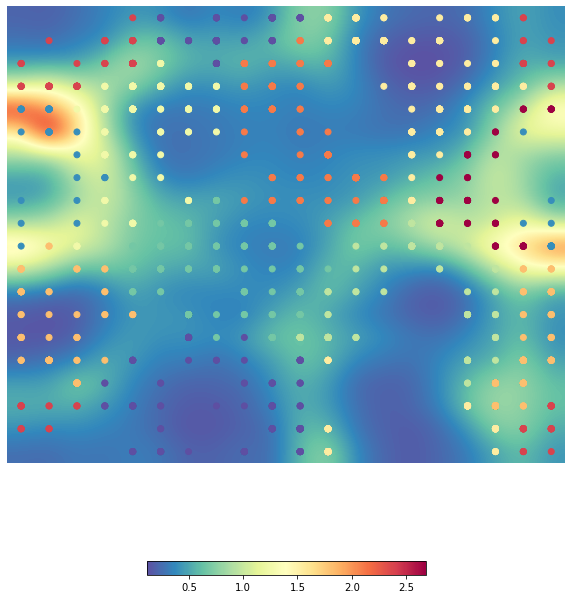

 Cluster number  1  : 


Movie Category,"""Documentary""","""Comedy film""","""Western""","""Silent film""","""Black-and-white""","""Musical""","""Science Fiction""","""Action/Adventure""","""Short Film""","""Japanese Movies""","""Adventure""","""Thriller""","""World cinema""","""Indie""","""Fantasy""","""Romance Film""","""Culture & Society""","""War film""","""Biography""","""Music""","""Mystery""","""Crime Fiction""","""Romantic comedy""","""Sports""","""Bollywood""","""Action""","""Chinese Movies""","""Romantic drama""","""Comedy-drama""","""Anime""","""Time travel""","""Animation""","""History""","""Historical drama""","""Pre-Code""","""Political cinema""","""Satire""","""Rockumentary""","""Monster""","""Psychological thriller""","""Experimental film""","""Cult""","""Crime Drama""","""Christmas movie""","""Social issues""","""Spaghetti Western""","""Filipino Movies""","""Black comedy""","""Future noir""","""Costume drama""","""Apocalyptic and post-apocalyptic fiction""","""Avant-garde""","""Biographical film""","""Concert film""","""Costume Adventure""","""Children's Entertainment""","""Computer Animation""","""Cavalry Film""","""Comedy""","""Chase Movie""","""Dance""","""Wuxia""","""Dystopia""","""Ensemble Film""","""World History""","""Travel""","""Tragedy""","""Television movie""","""Tamil cinema""","""Sword and sorcery""","""Suspense""","""Surrealism""","""Stand-up comedy""","""Space western""","""Roadshow theatrical release""","""Punk rock""","""Political satire""","""Political drama""","""Parody""","""Musical comedy""","""Mockumentary""","""Melodrama""","""Martial Arts Film""","""Jungle Film""","""Historical fiction""","""Heist""","""Foreign legion""","""Film-Opera""","""Film noir""","""Fan film""","""Epic""","""Holiday Film"""
Count,47,40,29,27,26,23,22,20,19,19,18,15,15,14,13,13,9,8,7,6,6,6,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  2  : 


Movie Category,"""Family Film""","""Short Film""","""Animation""","""Comedy""","""Horror""","""Drama""","""Adventure""","""Thriller""","""Action""","""Fantasy""","""Crime Fiction""","""Action/Adventure""","""Science Fiction""","""Children's/Family""","""Black-and-white""","""Zombie Film""","""Romance Film""","""Natural horror films""","""Computer Animation""","""Comedy film""","""Creature Film""","""Crime Thriller""","""Cult""","""Chinese Movies""","""Fairy tale""","""Family Drama""","""Children's""","""Children's Fantasy""","""Animated cartoon""","""Film adaptation""","""Horror Comedy""","""Musical""","""World cinema""","""Psychological thriller""","""Superhero movie""","""Teen""","""Sword and sorcery films""","""Slapstick""","""Slasher""","""Sports""","""Spy""","""Superhero""","""Buddy film""","""Music""","""B-movie""","""Science fiction Western""","""Apocalyptic and post-apocalyptic fiction""","""Television movie""","""Animated Musical""","""Animal Picture""","""Alien Film""","""War film""","""Western""","""Silent film""","""Romantic comedy""","""Sci-Fi Horror""","""Gangster Film""","""Monster""","""Mondo film""","""Martial Arts Film""","""Indie""","""Musical Drama""","""Wuxia""","""Holiday Film""","""Glamorized Spy Film""","""Mystery""","""Movie serial""","""Fantasy Adventure""","""Family-Oriented Adventure""","""New Hollywood""","""Period piece""","""Political drama""","""Documentary""","""Docudrama""","""Remake""","""Action Thrillers"""
Count,23,23,19,16,13,11,9,9,8,8,5,5,5,5,4,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  3  : 


Movie Category,"""Action""","""Action/Adventure""","""Thriller""","""Adventure""","""Drama""","""Crime Fiction""","""Comedy""","""Martial Arts Film""","""Science Fiction""","""World cinema""","""Action Thrillers""","""Crime Thriller""","""Fantasy""","""Western""","""Indie""","""Romance Film""","""Chinese Movies""","""War film""","""Spy""","""Superhero movie""","""Japanese Movies""","""Black-and-white""","""Horror""","""Parody""","""Buddy film""","""Historical fiction""","""Heist""","""Gangster Film""","""Suspense""","""Animation""","""Film adaptation""","""Action Comedy""","""Sports""","""Psychological thriller""","""Comedy film""","""Short Film""","""Fantasy Adventure""","""Superhero""","""Adventure Comedy""","""Crime Comedy""","""Mystery""","""Musical""","""Family Film""","""Anime""","""Disaster""","""Romantic comedy""","""Bollywood""","""B-movie""","""Black comedy""","""Television movie""","""Remake""","""Political thriller""","""Supernatural""","""Caper story""","""Blaxploitation""","""Spaghetti Western""","""Comedy Western""","""Cult""","""Comedy-drama""","""Sword and sorcery films""","""Biographical film""","""Auto racing""","""Sci-Fi Horror""","""Animals""","""Tragicomedy""","""Tollywood""","""Tamil cinema""","""Comedy Thriller""","""Animal Picture""","""Anti-war film""","""Sword and sorcery""","""Anti-war""","""Chase Movie""","""Swashbuckler films""","""Biography""","""Biopic [feature]""","""Reboot""","""Costume drama""","""Creature Film""","""Prison""","""Parkour in popular culture""","""Nature""","""Natural horror films""","""Mythological Fantasy""","""Musical Drama""","""Movie serial""","""Road movie""","""Malayalam Cinema""","""Roadshow theatrical release""","""Hybrid Western""","""Samurai cinema""","""Horror Comedy""","""Satire""","""History""","""Sci-Fi Adventure""","""Silent film""","""Filipino Movies""","""Slasher""","""Fan film""","""Epic""","""Epic Western""","""Space western""","""Docudrama""","""Crime Drama""","""Holiday Film"""
Count,204,106,88,61,52,46,43,21,21,20,19,16,15,14,13,12,11,11,10,10,9,8,8,7,6,6,6,6,6,6,5,5,5,4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  4  : 


Movie Category,"""Romance Film""","""Drama""","""Romantic drama""","""World cinema""","""Comedy""","""Musical""","""Period piece""","""Romantic comedy""","""Film adaptation""","""Black-and-white""","""Bollywood""","""Indie""","""Melodrama""","""Action""","""War film""","""Family Drama""","""Coming of age""","""Comedy-drama""","""Adventure""","""Family Film""","""Thriller""","""Chinese Movies""","""Television movie""","""Marriage Drama""","""Biopic [feature]""","""Costume drama""","""Western""","""Comedy film""","""Crime Fiction""","""Action/Adventure""","""Sports""","""Art film""","""Epic""","""Ensemble Film""","""Biographical film""","""Tamil cinema""","""Japanese Movies""","""History""","""Comedy of manners""","""Political drama""","""Biography""","""Mystery""","""Fantasy""","""Erotic Drama""","""Spy""","""Computer Animation""","""Crime Drama""","""Black comedy""","""Americana""","""Animation""","""Avant-garde""","""Christian film""","""Cult""","""Tollywood""","""Silent film""","""Experimental film""","""Disaster""","""Docudrama""","""Satire""","""Social problem film""","""Road movie""","""Psychological thriller""","""Pre-Code""","""Political cinema""","""Supernatural""","""Surrealism""","""Musical Drama""","""Music""","""Suspense""","""Kitchen sink realism""","""Inspirational Drama""","""Horror""","""Historical fiction""","""Historical Epic""","""Film noir""","""Teen""","""Filipino Movies""","""Science Fiction""","""Epic Western""","""Hip hop movies"""
Count,172,158,95,42,39,25,25,25,20,18,16,11,9,9,8,7,7,7,6,6,6,5,5,5,4,4,4,4,4,4,4,3,3,3,3,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  5  : 


Movie Category,"""Horror""","""Thriller""","""Science Fiction""","""Slasher""","""Supernatural""","""World cinema""","""Action""","""Indie""","""Creature Film""","""Mystery""","""Cult""","""Comedy""","""Fantasy""","""B-movie""","""Psychological thriller""","""Teen""","""Drama""","""Zombie Film""","""Animation""","""Action/Adventure""","""Japanese Movies""","""Black-and-white""","""Monster movie""","""Chinese Movies""","""Sci-Fi Horror""","""Crime Fiction""","""Adventure""","""Comedy film""","""Costume Horror""","""Children's/Family""","""Black comedy""","""Romance Film""","""Suspense""","""Filipino Movies""","""Horror Comedy""","""Television movie""","""Film adaptation""","""Fantasy Adventure""","""Short Film""","""Martial Arts Film""","""Monster""","""Anime""","""Alien Film""","""Children's Fantasy""","""Children's""","""Childhood Drama""","""Sword and sorcery""","""Blaxploitation""","""Therimin music""","""Christian film""","""Avant-garde""","""Comedy horror""","""Animal Picture""","""Buddy film""","""Doomsday film""","""Sword and sorcery films""","""Master Criminal Films""","""Satire""","""Roadshow/Carny""","""Remake""","""Silent film""","""Period piece""","""Parody""","""Sports""","""Mockumentary""","""Media Satire""","""Stop motion""","""Detective fiction""","""Surrealism""","""Gothic Film""","""Wuxia""","""Film noir""","""Exploitation""","""Experimental film""","""Swashbuckler films""","""Disaster""","""Detective""","""Giallo"""
Count,140,41,26,22,16,15,14,14,14,13,13,13,11,11,10,9,8,8,7,7,7,6,6,5,5,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  6  : 


Movie Category,"""Drama""","""World cinema""","""Black-and-white""","""Indie""","""War film""","""Musical""","""Period piece""","""Bollywood""","""Biographical film""","""Political drama""","""Comedy""","""Art film""","""Biography""","""Coming of age""","""Biopic [feature]""","""Film adaptation""","""Family Drama""","""Adventure""","""Comedy film""","""Thriller""","""Action/Adventure""","""Crime Fiction""","""Comedy-drama""","""Television movie""","""Silent film""","""Japanese Movies""","""Chinese Movies""","""Horror""","""Short Film""","""Family Film""","""Docudrama""","""Romance Film""","""Science Fiction""","""Teen""","""Mystery""","""Sports""","""Melodrama""","""Satire""","""Documentary""","""Historical fiction""","""Christian film""","""Musical Drama""","""Black comedy""","""Music""","""Ensemble Film""","""Road movie""","""Children's/Family""","""Tragedy""","""Historical drama""","""Fantasy""","""Crime Drama""","""Epic""","""Children's""","""Childhood Drama""","""Filipino Movies""","""Action""","""Psychological thriller""","""Parody""","""Spy""","""Medical fiction""","""Surrealism""","""Romantic drama""","""Inspirational Drama""","""History""","""Historical Epic""","""Slice of life story""","""Romantic comedy""","""Social issues""","""Roadshow theatrical release""","""Chase Movie""","""Buddy film""","""Samurai cinema""","""Remake""","""Film noir""","""Social problem film""","""Combat Films""","""Backstage Musical""","""Anime""","""Animation""","""Animal Picture""","""Americana""","""Tamil cinema""","""Tragicomedy""","""Supernatural""","""Comedy of manners""","""Propaganda film""","""Culture & Society""","""Feminist Film""","""Indian Western""","""Existentialism""","""Erotic Drama""","""Juvenile Delinquency Film""","""Dystopia""","""Malayalam Cinema""","""Marriage Drama""","""Dance""","""Cult""","""Comedy of Errors""","""Musical comedy""","""New Hollywood""","""Crime Comedy""","""Courtroom Drama""","""Costume drama""","""Costume Horror""","""Political thriller""","""Pre-Code""","""Western""","""Hagiography"""
Count,391,86,35,32,29,26,21,19,18,16,16,14,14,14,13,13,13,12,12,11,10,9,9,9,8,7,7,7,7,7,7,6,6,6,6,6,5,5,5,4,4,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  7  : 


Movie Category,"""Comedy""","""Drama""","""Romance Film""","""Indie""","""Black-and-white""","""Romantic comedy""","""Comedy-drama""","""Short Film""","""Parody""","""Musical""","""Slapstick""","""Black comedy""","""Silent film""","""Horror""","""Crime Fiction""","""World cinema""","""Fantasy""","""Science Fiction""","""Satire""","""Screwball comedy""","""Teen""","""Sex comedy""","""Action""","""Ensemble Film""","""Thriller""","""Coming of age""","""Fantasy Comedy""","""Cult""","""Media Satire""","""Domestic Comedy""","""Comedy of manners""","""Political cinema""","""Comedy of Errors""","""Romantic drama""","""Buddy film""","""Period piece""","""Crime Comedy""","""Gross-out film""","""Family Drama""","""Bollywood""","""Stoner film""","""Horror Comedy""","""Action/Adventure""","""Gross out""","""Workplace Comedy""","""Family Film""","""Chinese Movies""","""Heist""","""Absurdism""","""Mockumentary""","""Mystery""","""Musical comedy""","""Sports""","""Japanese Movies""","""Melodrama""","""Western""","""War film""","""Punk rock""","""Music""","""Film adaptation""","""Romantic fantasy""","""Remake""","""Surrealism""","""Political drama""","""Political satire""","""Adventure""","""Caper story""","""Childhood Drama""","""Slice of life story""","""Avant-garde""","""Superhero movie""","""Biography""","""B-movie""","""Addiction Drama""","""Action Thrillers""","""Children's""","""Hip hop movies""","""Christmas movie""","""Comedy Western""","""Comedy film""","""Road movie""","""Gangster Film""","""Psychological thriller""","""Natural horror films""","""Detective fiction""","""Detective""","""Docudrama""","""Escape Film""","""Experimental film""","""Exploitation""","""Holiday Film""","""Feminist Film""","""Religious Film"""
Count,281,68,52,51,44,44,30,27,23,21,17,16,16,13,13,12,11,10,10,9,9,8,8,7,7,7,6,6,5,5,5,5,5,5,5,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  8  : 


Movie Category,"""Thriller""","""Drama""","""Crime Fiction""","""Mystery""","""Crime Thriller""","""Psychological thriller""","""Suspense""","""Indie""","""Action""","""Black-and-white""","""Film noir""","""World cinema""","""Horror""","""Film adaptation""","""Gangster Film""","""Detective""","""Romance Film""","""Courtroom Drama""","""Detective fiction""","""Action/Adventure""","""Crime Drama""","""Comedy""","""Comedy film""","""Heist""","""Political drama""","""Science Fiction""","""Adventure""","""Black comedy""","""Television movie""","""Supernatural""","""Docudrama""","""Coming of age""","""Haunted House Film""","""Period piece""","""Erotic thriller""","""Art film""","""Japanese Movies""","""Spy""","""Sports""","""Slasher""","""Caper story""","""Comedy-drama""","""Neo-noir""","""Western""","""Tollywood""","""Alien Film""","""Comedy Thriller""","""Time travel""","""Albino bias""","""New Hollywood""","""Tragedy""","""Comedy of Errors""","""Political thriller""","""Bollywood""","""Superhero movie""","""Musical""","""Superhero""","""Remake""","""Documentary""","""Short Film""","""Existentialism""","""Family Drama""","""Fantasy""","""Screwball comedy""","""Melodrama""","""Road movie""","""Gothic Film""","""Whodunit""","""History""","""Revisionist Western""","""Action Thrillers"""
Count,143,133,112,78,66,29,24,24,23,20,18,17,13,13,12,9,8,8,7,7,7,5,5,5,4,4,4,4,4,4,4,3,3,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  9  : 


Movie Category,"""Family Film""","""Animation""","""Short Film""","""Comedy""","""Adventure""","""Drama""","""Fantasy""","""Children's/Family""","""Comedy film""","""Children's""","""Musical""","""Science Fiction""","""Black-and-white""","""Family-Oriented Adventure""","""Family Drama""","""Action""","""Action/Adventure""","""Coming of age""","""Computer Animation""","""Children's Fantasy""","""Western""","""Animal Picture""","""Romance Film""","""Sports""","""Stop motion""","""Costume drama""","""Parody""","""Anime""","""Thriller""","""Fantasy Comedy""","""Fantasy Adventure""","""Comedy-drama""","""World cinema""","""Period piece""","""Swashbuckler films""","""Superhero movie""","""Japanese Movies""","""Music""","""Mythological Fantasy""","""Chinese Movies""","""Silent film""","""Avant-garde""","""Documentary""","""Domestic Comedy""","""Experimental film""","""Horror""","""Adventure Comedy""","""Holiday Film""","""Television movie""","""Historical fiction""","""Indie""","""Black comedy""","""Bollywood""","""War film""","""Sword and sorcery films""","""Teen""","""Biography""","""Animated cartoon""","""Biographical film""","""Sword and sorcery""","""Time travel""","""Childhood Drama""","""Chase Movie""","""Comedy of Errors""","""Children's Entertainment""","""Surrealism""","""Spy""","""Horror Comedy""","""Slapstick""","""Romantic drama""","""Religious Film""","""Political cinema""","""Fairy tale""","""Mystery""","""Mockumentary""","""Martial Arts Film""","""Hagiography""","""Heavenly Comedy""","""Film adaptation"""
Count,112,83,73,65,42,33,31,21,17,15,11,11,10,9,9,8,8,7,7,7,6,6,5,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  10  : 


Movie Category,"""Drama""","""Comedy""","""Action""","""War film""","""Period piece""","""Romance Film""","""World cinema""","""Action/Adventure""","""Chinese Movies""","""Thriller""","""Indie""","""Adventure""","""Short Film""","""Family Film""","""Black-and-white""","""Docudrama""","""Political drama""","""Television movie""","""Fantasy""","""Martial Arts Film""","""Western""","""Horror""","""Crime Fiction""","""Costume Adventure""","""Family Drama""","""Black comedy""","""Biopic [feature]""","""Biography""","""Biographical film""","""Costume drama""","""Wuxia""","""Historical fiction""","""Screwball comedy""","""Japanese Movies""","""Medical fiction""","""Spy""","""Political thriller""","""Comedy film""","""Romantic drama""","""Blaxploitation""","""Science Fiction""","""Social problem film""","""Sex comedy""","""Comedy-drama""","""Sports""","""Airplanes and airports""","""Tragicomedy""","""Romantic comedy""","""History""","""Road movie""","""Historical drama""","""Prison""","""Creature Film""","""Crime Drama""","""Parody""","""Documentary""","""Natural horror films""","""Epic""","""Escape Film""","""Existentialism""","""Indian Western""","""Costume Horror"""
Count,48,14,13,9,9,9,8,8,7,5,5,5,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [99]:
# 20x20 , k = 10

som_c20_r20 = somoclu.Somoclu(n_columns = 20 , n_rows = 20, compactsupport=False, neighborhood='bubble', maptype="toroid")

%time som_c20_r20.train(train_set_reduced, epochs=100, radius0=0, radiusN=3)

####

# BMUs , (20x20 S0M , default) 
bmu_c20_r20 = som_c20_r20.bmus
print("Best Matching Units vector shape : ", bmu_c20_r20.shape)

# Unique Best Matching Units (= Clusters)
unique_bmu_c20_r20, indices_c20_r20 = np.unique(bmu_c20_r20, return_inverse=True, axis=0)
print("Unique Best Matching Units : ", unique_bmu_c20_r20.shape) 

###

som_c20_r20.cluster(KMeans(n_clusters= 10, n_init='auto'))

###

print("Clusters for 20x20 SOM : \n", som_c20_r20.clusters)

unique_values, counts = np.unique(som_c20_r20.clusters, return_counts=True)
print("Unique SOM values : " , unique_values)

#Εκτύπωση του U-matrix με τα ορίσματα της εκφώνησης
som_c20_r20.view_umatrix(bestmatches=True, colorbar=True, figsize=(10, 12)); matplotlib.pyplot.show()

som_report(som_c20_r20, 10)

#### 25x25 , k = 14

CPU times: user 2min 27s, sys: 754 ms, total: 2min 28s
Wall time: 1min 31s
Best Matching Units vector shape :  (2000, 2)
Unique Best Matching Units :  (359, 2)
Clusters for 25x25 SOM : 
 [[ 0  4  4  4  5  5  5  5  5  5  5  5  5  5 11 11 11 11 11  6  6  0  0  0
   0]
 [ 4  4  4  4  5  5  5  5  5  5  5  5  5  5  5  9  9  9  9  6  6  6  6  0
   6]
 [ 4  4  4  4  5 12  5  5  5  5 12 12  5  5  5  9  9  9  9  9  6  6  6  6
   4]
 [ 4  4  4  1 12 12  5 12 12 12 12 12 12  5  5  9  9  9  9  9  9  6  6  6
   4]
 [ 4  1  1  1  5 12 12 12 12 12 12 12 12 12  9  9  9  9  9  9  9  9  9  4
   4]
 [ 1  1  1  1  1 12 12 12 12 12 12 12 12 12  3  9  9  9  9  9  9  9  9  9
   1]
 [ 1  1  1  1  1 12 12 12 12 12 12 12 12 12  3  9  9  9  9 13 13 13 13  9
   1]
 [ 1  1  1  1  1  1  1 12 12 12 12 12 12  3  3  3  3  9 13 13 13 13 13  1
   1]
 [ 1  1  1  1  1  1  1  1 12 12 12  3  3  3  3  3  3 13 13 13 13 13 13 13
   1]
 [ 1  1  1  1  1  1  1  1  1 12  3  3  3  3  3  3  3  3 13 13 13 13 13 13
   1]
 [13  1  1  1

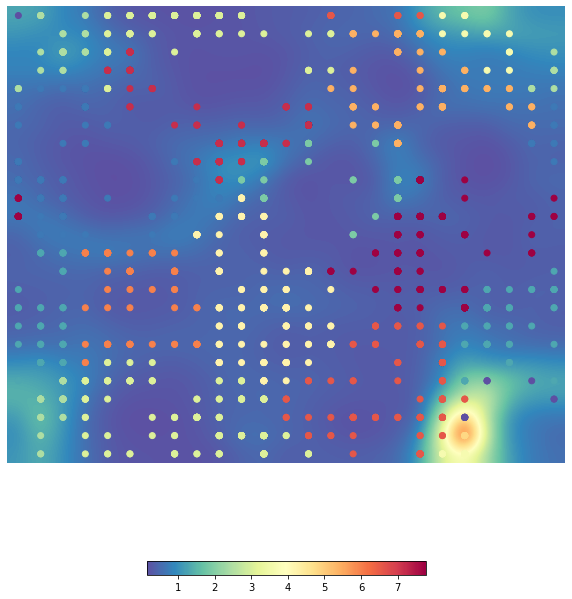

 Cluster number  1  : 


Movie Category,"""Short Film""","""Family Film""","""Animation""","""Comedy""","""Comedy film""","""Sports""","""Remake""","""Martial Arts Film""","""Horror""","""Fantasy""","""Family Drama""","""Drama""","""Chinese Movies""","""Black-and-white""","""Action"""
Count,11,9,9,4,2,1,1,1,1,1,1,1,1,1,1




 Cluster number  2  : 


Movie Category,"""Comedy""","""Drama""","""Romance Film""","""Romantic comedy""","""Indie""","""Family Film""","""Comedy-drama""","""Musical""","""Parody""","""Black-and-white""","""Black comedy""","""Fantasy""","""World cinema""","""Horror""","""Action""","""Slapstick""","""Satire""","""Science Fiction""","""Crime Fiction""","""Fantasy Comedy""","""Screwball comedy""","""Teen""","""Coming of age""","""Cult""","""Sex comedy""","""Domestic Comedy""","""Political cinema""","""Ensemble Film""","""Thriller""","""Comedy of manners""","""Bollywood""","""Short Film""","""Action/Adventure""","""Media Satire""","""Film adaptation""","""Gross out""","""Gross-out film""","""Workplace Comedy""","""Horror Comedy""","""Children's/Family""","""Stoner film""","""Period piece""","""Sports""","""Buddy film""","""Chinese Movies""","""Music""","""Animal Picture""","""Family Drama""","""War film""","""Crime Comedy""","""Mockumentary""","""Adventure""","""Childhood Drama""","""Absurdism""","""Mystery""","""Political satire""","""Heist""","""Hip hop movies""","""Silent film""","""Japanese Movies""","""Melodrama""","""Religious Film""","""Punk rock""","""Musical comedy""","""Romantic fantasy""","""Political drama""","""Slasher""","""Stand-up comedy""","""Superhero movie""","""Biography""","""Feminist Film""","""B-movie""","""Avant-garde""","""Surrealism""","""Television movie""","""Addiction Drama""","""Tragicomedy""","""Western""","""Action Thrillers""","""Caper story""","""Comedy of Errors""","""Road movie""","""Remake""","""Christmas movie""","""Comedy film""","""Family-Oriented Adventure""","""Psychological thriller""","""Costume drama""","""Crime Drama""","""Docudrama""","""Documentary""","""Holiday Film""","""Escape Film""","""Experimental film""","""Exploitation""","""Heavenly Comedy"""
Count,256,72,51,45,33,24,23,22,22,18,17,14,13,10,10,9,9,8,8,8,8,8,7,7,7,6,6,6,6,5,5,5,5,5,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  3  : 


Movie Category,"""Animation""","""Family Film""","""Short Film""","""Comedy""","""Adventure""","""Fantasy""","""Children's/Family""","""Children's""","""Comedy film""","""Drama""","""Musical""","""Computer Animation""","""Western""","""Children's Fantasy""","""Family-Oriented Adventure""","""Science Fiction""","""Action""","""Romance Film""","""Thriller""","""Music""","""Comedy-drama""","""Coming of age""","""Japanese Movies""","""Sports""","""Action/Adventure""","""Superhero movie""","""Anime""","""Black-and-white""","""Animal Picture""","""Costume drama""","""Documentary""","""Fairy tale""","""World cinema""","""Fantasy Adventure""","""Horror""","""Stop motion""","""Parody""","""Fantasy Comedy""","""Historical fiction""","""Horror Comedy""","""Apocalyptic and post-apocalyptic fiction""","""War film""","""Adventure Comedy""","""Time travel""","""Television movie""","""Animated Musical""","""Animated cartoon""","""Teen""","""Sword and sorcery""","""Sword and sorcery films""","""Indian Western""","""Children's Entertainment""","""Hagiography""","""Family Drama""","""Chinese Movies""","""Natural horror films""","""Mythological Fantasy""","""Mockumentary""","""Martial Arts Film""","""Romantic drama"""
Count,85,65,54,40,26,22,18,14,14,11,9,8,7,7,6,5,4,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  4  : 


Movie Category,"""Comedy film""","""Romance Film""","""Musical""","""Action""","""Fantasy""","""Black-and-white""","""Crime Fiction""","""Western""","""Horror""","""Anime""","""Spy""","""Short Film""","""Drama""","""Political thriller""","""Sports""","""Costume drama""","""Dance""","""Disaster""","""Roadshow theatrical release""","""Science Fiction""","""Film-Opera""","""Historical drama""","""War film""","""Japanese Movies""","""Musical Drama""","""Romantic comedy""","""Mystery""","""Family Film"""
Count,44,34,27,19,7,4,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  5  : 


Movie Category,"""Drama""","""Comedy""","""Action""","""Action/Adventure""","""World cinema""","""Chinese Movies""","""Romance Film""","""Family Film""","""Horror""","""Martial Arts Film""","""Short Film""","""Crime Fiction""","""Adventure""","""War film""","""Fantasy""","""Black-and-white""","""Biographical film""","""Japanese Movies""","""Period piece""","""Wuxia""","""Indie""","""Thriller""","""Science Fiction""","""Historical fiction""","""Parody""","""Docudrama""","""Animation""","""Black comedy""","""Costume Horror""","""Romantic comedy""","""Medical fiction""","""Screwball comedy""","""Silent film""","""Biopic [feature]""","""Biography""","""Comedy film""","""Creature Film""","""Costume Adventure""","""Comedy-drama""","""Superhero movie""","""Comedy of manners""","""Children's/Family""","""Western""","""Superhero""","""Children's""","""Spy""","""Blaxploitation""","""Teen""","""Television movie""","""Buddy film""","""Romantic drama""","""Crime Thriller""","""Documentary""","""Satire""","""Roadshow theatrical release""","""Road movie""","""Psychological thriller""","""Prison""","""Political drama""","""Mystery""","""Musical""","""Musical Drama""","""Sex comedy""","""Slapstick""","""Holiday Film""","""History""","""Historical drama""","""Slasher""","""Social problem film""","""Family Drama""","""Escape Film""","""Domestic Comedy""","""Sports"""
Count,35,23,19,15,14,12,11,8,7,6,6,6,6,6,5,4,4,4,4,4,4,4,3,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  6  : 


Movie Category,"""Drama""","""Crime Fiction""","""Black-and-white""","""Indie""","""War film""","""Period piece""","""Action""","""Biographical film""","""Thriller""","""Coming of age""","""Family Drama""","""Family Film""","""Political drama""","""Film adaptation""","""Biography""","""World cinema""","""Comedy film""","""Biopic [feature]""","""Television movie""","""Musical""","""Docudrama""","""Mystery""","""Short Film""","""Romance Film""","""Sports""","""Teen""","""Silent film""","""Horror""","""Comedy""","""Crime Drama""","""Melodrama""","""Fantasy""","""Chinese Movies""","""Adventure""","""Science Fiction""","""Film noir""","""Comedy-drama""","""Bollywood""","""Spy""","""Christian film""","""Satire""","""Documentary""","""Political thriller""","""Courtroom Drama""","""Historical fiction""","""Music""","""Children's/Family""","""Children's""","""Art film""","""Action/Adventure""","""Childhood Drama""","""Black comedy""","""Medical fiction""","""Crime Thriller""","""Ensemble Film""","""Epic""","""Existentialism""","""Tamil cinema""","""Historical drama""","""Inspirational Drama""","""Filipino Movies""","""History""","""Musical Drama""","""New Hollywood""","""Buddy film""","""Japanese Movies""","""Road movie""","""Juvenile Delinquency Film""","""Romantic comedy""","""Tollywood""","""Backstage Musical""","""Tragedy""","""Malayalam Cinema""","""Anime""","""Animation""","""Animal Picture""","""Americana""","""Airplanes and airports""","""Romantic drama""","""Marriage Drama""","""Slice of life story""","""Holiday Film""","""Remake""","""Neo-noir""","""Feminist Film""","""Dystopia""","""Supernatural""","""Social problem film""","""Parody""","""Dance""","""Cult""","""Western""","""Gangster Film""","""Historical Epic""","""Costume drama""","""Costume Adventure""","""Pre-Code""","""Propaganda film""","""Comedy of manners""","""Psychological thriller""","""Combat Films""","""Erotic Drama"""
Count,380,47,34,34,30,30,27,17,17,17,17,16,15,15,14,14,13,12,12,10,10,9,7,7,7,6,6,6,6,5,5,5,5,5,5,5,4,4,4,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  7  : 


Movie Category,"""Horror""","""Comedy""","""Thriller""","""Short Film""","""Drama""","""Adventure""","""Family Film""","""Animation""","""Natural horror films""","""Children's/Family""","""Fantasy""","""Action""","""Science Fiction""","""Horror Comedy""","""Action/Adventure""","""Creature Film""","""Crime Fiction""","""Documentary""","""Fairy tale""","""Family Drama""","""Zombie Film""","""Cult""","""Family-Oriented Adventure""","""Children's Fantasy""","""Buddy film""","""Black-and-white""","""B-movie""","""Animal Picture""","""Children's""","""Gangster Film""","""Fantasy Adventure""","""Film adaptation""","""War film""","""Television movie""","""Teen""","""Sword and sorcery films""","""Supernatural""","""Spy""","""Slasher""","""Science fiction Western""","""Romance Film""","""Political drama""","""Period piece""","""Musical""","""Musical Drama""","""Monster""","""Mondo film""","""Indie""","""Holiday Film""","""Glamorized Spy Film""","""Western""","""Action Thrillers"""
Count,10,6,6,5,5,5,5,5,3,3,3,3,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  8  : 


Movie Category,"""Action""","""Action/Adventure""","""Thriller""","""Crime Fiction""","""Comedy""","""Drama""","""Adventure""","""Western""","""World cinema""","""Martial Arts Film""","""Action Thrillers""","""Crime Thriller""","""Science Fiction""","""Indie""","""Japanese Movies""","""Fantasy""","""Chinese Movies""","""War film""","""Animation""","""Gangster Film""","""Heist""","""Parody""","""Superhero movie""","""Spy""","""Anime""","""Horror""","""Buddy film""","""Action Comedy""","""Suspense""","""Romance Film""","""Film adaptation""","""Crime Comedy""","""Black-and-white""","""Chase Movie""","""Black comedy""","""B-movie""","""Spaghetti Western""","""Sports""","""Psychological thriller""","""Superhero""","""Mystery""","""Remake""","""Adventure Comedy""","""Comedy film""","""Short Film""","""Comedy Western""","""Cult""","""Bollywood""","""Blaxploitation""","""Comedy-drama""","""Caper story""","""Political thriller""","""Auto racing""","""Romantic comedy""","""Supernatural""","""Television movie""","""Musical""","""Biography""","""Biographical film""","""Anti-war""","""Anti-war film""","""Animals""","""Animal Picture""","""Cavalry Film""","""Tollywood""","""Tragicomedy""","""Children's""","""Creature Film""","""Comedy Thriller""","""Romantic drama""","""Parkour in popular culture""","""Nature""","""Malayalam Cinema""","""Reboot""","""Indian Western""","""Road movie""","""Horror Comedy""","""Holiday Film""","""History""","""Historical fiction""","""Samurai cinema""","""Silent film""","""Fantasy Adventure""","""Fan film""","""Epic""","""Epic Western""","""Dystopia""","""Satire""","""Disaster""","""Sci-Fi Horror""","""Prison""","""Costume Adventure""","""Future noir"""
Count,156,111,86,47,43,39,28,27,22,21,20,17,12,12,11,10,10,8,7,7,7,7,7,6,6,6,5,5,5,5,4,4,4,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  9  : 


Movie Category,"""Family Film""","""Short Film""","""Comedy""","""Thriller""","""Animated cartoon""","""Horror""","""Zombie Film""","""Drama""","""Animation""","""Comedy film""","""Crime Fiction""","""Crime Thriller""","""Fantasy""","""World cinema""","""Film adaptation""","""Music""","""Mystery""","""New Hollywood""","""Psychological thriller""","""Action"""
Count,5,4,3,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  10  : 


Movie Category,"""Horror""","""Thriller""","""Science Fiction""","""Slasher""","""Indie""","""Supernatural""","""Drama""","""Creature Film""","""Cult""","""Mystery""","""Psychological thriller""","""B-movie""","""Comedy""","""World cinema""","""Teen""","""Zombie Film""","""Fantasy""","""Black-and-white""","""Monster movie""","""Action""","""Sci-Fi Horror""","""Film adaptation""","""Suspense""","""Horror Comedy""","""Action/Adventure""","""Crime Fiction""","""Costume Horror""","""Television movie""","""Filipino Movies""","""Alien Film""","""Black comedy""","""Chinese Movies""","""Disaster""","""Japanese Movies""","""Adventure""","""Monster""","""Romance Film""","""Natural horror films""","""Parody""","""Detective fiction""","""Blaxploitation""","""Time travel""","""Christian film""","""Avant-garde""","""Comedy film""","""Comedy horror""","""Sword and sorcery""","""Sword and sorcery films""","""Therimin music""","""Remake""","""Detective""","""Gothic Film""","""Period piece""","""Satire""","""Mockumentary""","""Media Satire""","""Master Criminal Films""","""Silent film""","""Stop motion""","""Giallo""","""Docudrama""","""Film noir""","""Surrealism""","""Fantasy Adventure""","""Exploitation""","""Experimental film""","""Roadshow/Carny""","""Doomsday film""","""Erotic thriller"""
Count,140,41,23,20,16,15,14,14,14,12,12,11,10,9,9,9,8,6,6,6,6,5,4,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  11  : 


Movie Category,"""Adventure""","""Action""","""Drama""","""Science Fiction""","""Action/Adventure""","""Family Film""","""Fantasy""","""Black-and-white""","""Western""","""Indie""","""Swashbuckler films""","""Comedy""","""Thriller""","""Fantasy Adventure""","""Animation""","""Historical fiction""","""Romance Film""","""Family Drama""","""Costume drama""","""Crime Fiction""","""Silent film""","""Superhero movie""","""Film adaptation""","""Mythological Fantasy""","""Mystery""","""Adventure Comedy""","""Sword and sorcery""","""Sword and sorcery films""","""Family-Oriented Adventure""","""Comedy film""","""Stop motion""","""Coming of age""","""Space western""","""Computer Animation""","""Buddy film""","""Animal Picture""","""Chase Movie""","""Comedy of Errors""","""Anime""","""Comedy Western""","""Chinese Movies""","""Children's/Family""","""Children's""","""Biopic [feature]""","""Children's Fantasy""","""World cinema""","""Crime Drama""","""Disaster""","""War film""","""Time travel""","""Superhero""","""Spy""","""Sports""","""Short Film""","""Sci-Fi Horror""","""Sci-Fi Adventure""","""Roadshow theatrical release""","""Road movie""","""Period piece""","""Musical""","""Musical comedy""","""Musical Drama""","""Movie serial""","""Jungle Film""","""Hybrid Western""","""Horror""","""Filipino Movies""","""Historical Epic"""
Count,80,31,25,22,19,18,13,13,7,6,5,5,5,5,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  12  : 


Movie Category,"""Thriller""","""Drama""","""Mystery""","""Crime Fiction""","""Crime Thriller""","""Psychological thriller""","""Suspense""","""Black-and-white""","""World cinema""","""Film noir""","""Indie""","""Horror""","""Gangster Film""","""Detective""","""Action""","""Comedy""","""Film adaptation""","""Detective fiction""","""Science Fiction""","""Courtroom Drama""","""Action/Adventure""","""Adventure""","""Heist""","""Crime Drama""","""Supernatural""","""Romance Film""","""Black comedy""","""Television movie""","""Comedy film""","""Docudrama""","""Art film""","""Spy""","""Haunted House Film""","""Slasher""","""Erotic thriller""","""Political drama""","""Period piece""","""Japanese Movies""","""Caper story""","""Western""","""Comedy-drama""","""Superhero movie""","""Political thriller""","""Animation""","""Bollywood""","""Alien Film""","""Remake""","""Comedy Thriller""","""Revisionist Western""","""Comedy of Errors""","""New Hollywood""","""Whodunit""","""Coming of age""","""Gothic Film""","""Screwball comedy""","""Movie serial""","""Melodrama""","""Superhero""","""Short Film""","""Documentary""","""Road movie""","""Existentialism""","""Family Film""","""Fantasy""","""History""","""Sports""","""Neo-noir"""
Count,141,81,77,72,63,29,24,19,16,15,13,11,10,9,9,8,8,7,6,6,5,5,5,4,4,4,4,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  13  : 


Movie Category,"""Drama""","""Romance Film""","""World cinema""","""Romantic drama""","""Comedy""","""Musical""","""Bollywood""","""Indie""","""Period piece""","""Romantic comedy""","""Black-and-white""","""Comedy-drama""","""Film adaptation""","""Art film""","""Thriller""","""War film""","""Family Drama""","""Melodrama""","""Japanese Movies""","""Political drama""","""Coming of age""","""Action/Adventure""","""Action""","""Chinese Movies""","""Family Film""","""Crime Fiction""","""Biopic [feature]""","""Ensemble Film""","""Sports""","""Marriage Drama""","""Television movie""","""Costume drama""","""Biographical film""","""Epic""","""Adventure""","""Western""","""Comedy film""","""Biography""","""Black comedy""","""Fantasy""","""Surrealism""","""Tragedy""","""Satire""","""Teen""","""Crime Comedy""","""Christian film""","""Spy""","""Erotic Drama""","""Tamil cinema""","""Historical fiction""","""History""","""Road movie""","""Slice of life story""","""Psychological thriller""","""Silent film""","""Mystery""","""Science Fiction""","""Tollywood""","""Comedy of manners""","""Tragicomedy""","""Americana""","""Comedy of Errors""","""Albino bias""","""Suspense""","""Animation""","""Avant-garde""","""Samurai cinema""","""Epic Western""","""Computer Animation""","""Horror""","""Pre-Code""","""Political cinema""","""Sex comedy""","""Parody""","""Musical Drama""","""Kitchen sink realism""","""Social problem film""","""Inspirational Drama""","""Historical Epic""","""Crime Drama""","""Hagiography""","""Gangster Film""","""Filipino Movies""","""Supernatural""","""Experimental film""","""Documentary""","""Docudrama""","""Disaster""","""Historical drama"""
Count,234,162,117,101,52,37,32,24,24,23,20,19,18,14,12,12,11,9,9,8,8,8,8,7,6,6,5,5,5,5,5,5,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  14  : 


Movie Category,"""Short Film""","""Black-and-white""","""Documentary""","""Silent film""","""Comedy""","""Indie""","""Science Fiction""","""Japanese Movies""","""World cinema""","""Culture & Society""","""Slapstick""","""Western""","""Biography""","""Thriller""","""War film""","""Music""","""Romantic comedy""","""Sports""","""Fantasy""","""Animation""","""Bollywood""","""Action/Adventure""","""Experimental film""","""Mystery""","""Crime Fiction""","""Comedy-drama""","""Chinese Movies""","""Comedy of Errors""","""Musical""","""Political cinema""","""Romantic drama""","""History""","""Pre-Code""","""Rockumentary""","""Satire""","""Social issues""","""Surrealism""","""Avant-garde""","""Time travel""","""Filipino Movies""","""Computer Animation""","""Comedy film""","""Crime Drama""","""Drama""","""Historical drama""","""Cult""","""Christmas movie""","""Children's/Family""","""Monster""","""Musical comedy""","""Black comedy""","""Anime""","""Children's Fantasy""","""Children's Entertainment""","""Buddy film""","""Concert film""","""Costume drama""","""Biographical film""","""Apocalyptic and post-apocalyptic fiction""","""Animal Picture""","""Childhood Drama""","""Wuxia""","""Detective fiction""","""Detective""","""World History""","""Travel""","""Tragedy""","""Television movie""","""Tamil cinema""","""Suspense""","""Spaghetti Western""","""Screwball comedy""","""Remake""","""Punk rock""","""Psychological thriller""","""Political satire""","""Political drama""","""Parody""","""Mockumentary""","""Melodrama""","""Horror""","""Holiday Film""","""Historical fiction""","""Heist""","""Future noir""","""Foreign legion""","""Film noir""","""Fan film""","""Family Film""","""Epic""","""Ensemble Film""","""Absurdism"""
Count,62,49,47,40,37,24,18,18,11,10,9,8,8,6,6,6,6,5,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [102]:
# 25x25 , k = 12

som_c25_r25 = somoclu.Somoclu(n_columns = 25, n_rows = 25, compactsupport=False, neighborhood='bubble', maptype="toroid")

%time som_c25_r25.train(train_set_reduced, epochs=100, radius0=0, radiusN=3)

####

# BMUs , (25x25 S0M , default) 
bmu_c25_r25 = som_c25_r25.bmus
print("Best Matching Units vector shape : ", bmu_c25_r25.shape)

# Unique Best Matching Units (= Clusters)
unique_bmu_c25_r25, indices_c25_r25 = np.unique(bmu_c25_r25, return_inverse=True, axis=0)
print("Unique Best Matching Units : ", unique_bmu_c25_r25.shape) 

###

som_c25_r25.cluster(KMeans(n_clusters=14, n_init='auto'))

###

print("Clusters for 25x25 SOM : \n", som_c25_r25.clusters)

unique_values, counts = np.unique(som_c25_r25.clusters, return_counts=True)
print("Unique SOM values : " , unique_values)

#Εκτύπωση του U-matrix με τα ορίσματα της εκφώνησης
som_c25_r25.view_umatrix(bestmatches=True, colorbar=True, figsize=(10, 12)); matplotlib.pyplot.show()

som_report(som_c25_r25, 14)

Παρατηρούμε ότι η συμπεριφορά του χάρτη 20x20 με αριθμό ομάδων k = 10 είναι καλύτερη. Στην συνέχεια θα χρησιμοποιήσουμε ολόκληρο το σύνολο δεδομένων μας.

### Εφαρμογή σε πλήρη σύνολο δεδομένων

#### Final Set, 20x20, k = 10 

CPU times: user 1min 34s, sys: 406 ms, total: 1min 35s
Wall time: 58 s
Best Matching Units vector shape :  (2000, 2)
Unique Best Matching Units :  (281, 2)
Clusters for 20x20 SOM : 
 [[8 8 8 8 8 8 6 0 0 0 0 7 7 3 3 3 5 5 5 8]
 [8 8 8 8 8 8 0 0 0 0 0 0 3 3 0 5 5 5 5 5]
 [5 8 8 8 8 0 0 0 0 0 0 0 0 0 5 5 5 5 5 5]
 [5 9 9 9 9 9 0 0 0 0 0 0 4 4 5 5 5 5 5 5]
 [5 9 9 9 9 9 9 0 0 0 4 4 4 4 4 5 5 5 5 5]
 [5 9 9 9 9 9 9 0 2 0 4 4 4 4 4 5 5 5 5 5]
 [9 9 9 9 9 9 9 2 2 4 4 4 4 4 4 5 5 5 5 5]
 [9 9 9 9 9 9 2 2 4 4 4 4 4 4 4 4 5 5 5 5]
 [9 9 9 9 9 2 2 2 4 4 4 4 4 4 4 1 1 5 5 5]
 [9 9 9 2 2 2 2 2 4 4 4 4 4 4 1 1 1 1 5 9]
 [9 9 9 2 2 2 2 2 2 4 4 4 4 4 1 1 1 1 1 1]
 [9 9 2 2 2 2 2 2 2 2 4 4 4 1 1 1 1 1 1 1]
 [1 2 2 2 2 2 2 2 2 2 2 4 1 1 1 1 1 1 1 1]
 [8 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1]
 [8 8 8 2 2 2 2 2 2 6 6 1 1 1 1 1 1 1 1 1]
 [8 8 8 8 8 6 6 6 6 6 6 6 6 3 1 1 1 1 8 8]
 [8 8 8 8 8 6 6 6 6 6 6 3 3 3 3 3 1 8 8 8]
 [8 8 8 8 8 8 6 6 6 6 6 3 3 3 3 3 1 8 8 8]
 [8 8 8 8 8 8 6 6 6 6 7 7 7 3 3 3 3 8 8 8]


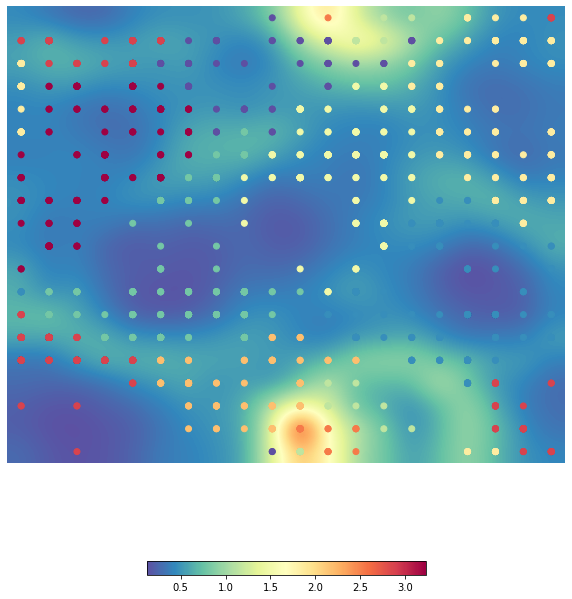

 Cluster number  1  : 


Movie Category,"""Horror""","""Drama""","""Comedy""","""Thriller""","""Action""","""Action/Adventure""","""World cinema""","""Cult""","""Slasher""","""Indie""","""Teen""","""Supernatural""","""Fantasy""","""Crime Fiction""","""Chinese Movies""","""Japanese Movies""","""Martial Arts Film""","""Mystery""","""Adventure""","""Short Film""","""Science Fiction""","""Romance Film""","""Period piece""","""Comedy film""","""Black comedy""","""Family Film""","""Docudrama""","""Costume Horror""","""Blaxploitation""","""Black-and-white""","""Creature Film""","""Zombie Film""","""Satire""","""Psychological thriller""","""Silent film""","""Natural horror films""","""Television movie""","""Comedy-drama""","""Screwball comedy""","""Comedy of manners""","""Sex comedy""","""Buddy film""","""Sports""","""Tragedy""","""Costume Adventure""","""Biopic [feature]""","""Biography""","""Biographical film""","""Anime""","""Animation""","""Alien Film""","""War film""","""Western""","""Coming of age""","""Medical fiction""","""Sci-Fi Horror""","""Monster movie""","""Indian Western""","""Musical""","""Horror Comedy""","""Wuxia""","""Historical fiction""","""Historical drama""","""Gothic Film""","""Film adaptation""","""Fantasy Adventure""","""Political drama""","""Exploitation""","""Prison""","""Domestic Comedy""","""Disaster""","""Road movie""","""Crime Thriller""","""Roadshow/Carny""","""History"""
Count,39,30,16,11,11,11,11,10,9,7,7,7,7,6,6,5,5,4,4,4,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  2  : 


Movie Category,"""Comedy""","""Drama""","""Black-and-white""","""Romance Film""","""Romantic comedy""","""Indie""","""Short Film""","""Family Film""","""Musical""","""World cinema""","""Comedy-drama""","""Parody""","""Slapstick""","""Silent film""","""Black comedy""","""Action""","""Fantasy""","""Crime Fiction""","""Satire""","""Thriller""","""Science Fiction""","""Screwball comedy""","""Teen""","""Action/Adventure""","""Fantasy Comedy""","""Coming of age""","""Sex comedy""","""Political cinema""","""Ensemble Film""","""Buddy film""","""Domestic Comedy""","""Cult""","""Comedy of manners""","""Comedy of Errors""","""Media Satire""","""Adventure""","""Bollywood""","""Gross-out film""","""Gross out""","""Crime Comedy""","""Workplace Comedy""","""Chinese Movies""","""Horror""","""Film adaptation""","""Stoner film""","""Mystery""","""Japanese Movies""","""Mockumentary""","""Children's/Family""","""Computer Animation""","""Period piece""","""Family Drama""","""Musical comedy""","""Music""","""Absurdism""","""Heist""","""Sports""","""Political drama""","""Adventure Comedy""","""Surrealism""","""Superhero movie""","""Hip hop movies""","""Filipino Movies""","""Romantic fantasy""","""Remake""","""Religious Film""","""Political satire""","""Punk rock""","""Documentary""","""Animated cartoon""","""Holiday Film""","""Family-Oriented Adventure""","""Fan film""","""Biography""","""Avant-garde""","""Art film""","""Animation""","""Animal Picture""","""Caper story""","""Television movie""","""Melodrama""","""Addiction Drama""","""Time travel""","""Western""","""Action Thrillers""","""Action Comedy""","""Stand-up comedy""","""Children's""","""Docudrama""","""Escape Film""","""Detective""","""Detective fiction""","""Heavenly Comedy""","""Psychological thriller""","""Crime Drama""","""Horror Comedy""","""Malayalam Cinema""","""Experimental film""","""Gangster Film""","""Road movie""","""Exploitation""","""Martial Arts Film""","""Comedy film""","""Comedy Western""","""Christmas movie""","""Spy""","""Feminist Film"""
Count,310,79,53,52,48,45,39,26,26,24,21,21,18,16,16,15,14,13,11,10,9,9,8,8,8,7,7,6,6,6,6,6,6,6,5,5,5,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  3  : 


Movie Category,"""Drama""","""World cinema""","""Crime Fiction""","""Black-and-white""","""Indie""","""War film""","""Period piece""","""Musical""","""Thriller""","""Bollywood""","""Family Drama""","""Action""","""Comedy film""","""Family Film""","""Political drama""","""Biographical film""","""Coming of age""","""Biography""","""Biopic [feature]""","""Film adaptation""","""Art film""","""Television movie""","""Adventure""","""Docudrama""","""Mystery""","""Comedy-drama""","""Action/Adventure""","""Film noir""","""Sports""","""Short Film""","""Romance Film""","""Chinese Movies""","""Teen""","""Silent film""","""Melodrama""","""Horror""","""Documentary""","""Crime Thriller""","""Historical fiction""","""Christian film""","""Japanese Movies""","""Crime Drama""","""Science Fiction""","""Tragedy""","""Children's/Family""","""Fantasy""","""Black comedy""","""Music""","""Satire""","""Historical drama""","""Courtroom Drama""","""Children's""","""Spy""","""Political thriller""","""Romantic comedy""","""Epic""","""Childhood Drama""","""Slice of life story""","""Ensemble Film""","""Road movie""","""Inspirational Drama""","""Gangster Film""","""Medical fiction""","""History""","""Musical Drama""","""Psychological thriller""","""Surrealism""","""Caper story""","""Buddy film""","""Marriage Drama""","""Tragicomedy""","""Erotic Drama""","""Malayalam Cinema""","""Backstage Musical""","""New Hollywood""","""Animation""","""Animal Picture""","""Americana""","""Albino bias""","""Parody""","""Social issues""","""Pre-Code""","""Suspense""","""Juvenile Delinquency Film""","""Existentialism""","""Dystopia""","""Remake""","""Social problem film""","""Feminist Film""","""Dance""","""Culture & Society""","""Cult""","""Tollywood""","""Propaganda film""","""Costume drama""","""Tamil cinema""","""Comedy""","""Samurai cinema""","""Combat Films""","""Holiday Film""","""Hagiography"""
Count,425,74,45,37,29,28,24,24,21,20,20,19,18,17,17,17,17,15,13,13,11,11,10,9,8,7,6,6,6,6,6,5,5,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  4  : 


Movie Category,"""Family Film""","""Comedy""","""Animation""","""Short Film""","""Adventure""","""Drama""","""Action""","""Action/Adventure""","""Horror""","""Fantasy""","""Children's/Family""","""Black-and-white""","""Thriller""","""War film""","""Chinese Movies""","""World cinema""","""Natural horror films""","""Crime Fiction""","""Romance Film""","""Science Fiction""","""Computer Animation""","""Documentary""","""Western""","""Fairy tale""","""Television movie""","""Wuxia""","""Children's""","""Children's Fantasy""","""Martial Arts Film""","""B-movie""","""Biopic [feature]""","""Comedy film""","""Animated Musical""","""Animal Picture""","""Biographical film""","""Buddy film""","""Costume Adventure""","""Family-Oriented Adventure""","""Creature Film""","""Cult""","""Sword and sorcery films""","""Superhero""","""Superhero movie""","""Spy""","""Screwball comedy""","""Science fiction Western""","""Romantic drama""","""Period piece""","""Parody""","""Monster""","""Mondo film""","""Horror Comedy""","""Holiday Film""","""Historical fiction""","""Glamorized Spy Film""","""Fantasy Adventure""","""Family Drama""","""Action Thrillers"""
Count,11,10,9,9,8,8,8,7,6,5,5,4,4,4,4,3,3,3,3,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  5  : 


Movie Category,"""Drama""","""Romance Film""","""Romantic drama""","""Comedy""","""World cinema""","""Period piece""","""Musical""","""Romantic comedy""","""Indie""","""Black-and-white""","""Film adaptation""","""Comedy-drama""","""Bollywood""","""War film""","""Action""","""Family Drama""","""Melodrama""","""Thriller""","""Television movie""","""Coming of age""","""Chinese Movies""","""Family Film""","""Adventure""","""Sports""","""Costume drama""","""Crime Fiction""","""Marriage Drama""","""Western""","""Ensemble Film""","""Art film""","""Biopic [feature]""","""Action/Adventure""","""Epic""","""Comedy film""","""Biographical film""","""Spy""","""Fantasy""","""Docudrama""","""Japanese Movies""","""History""","""Tamil cinema""","""Musical Drama""","""Erotic Drama""","""Epic Western""","""Black comedy""","""Biography""","""Political drama""","""Teen""","""Social problem film""","""Science Fiction""","""Silent film""","""Computer Animation""","""Children's/Family""","""Comedy of manners""","""Christian film""","""Childhood Drama""","""Tollywood""","""Tragicomedy""","""Avant-garde""","""Animation""","""Americana""","""Crime Drama""","""Slice of life story""","""Disaster""","""Surrealism""","""Sex comedy""","""Satire""","""Roadshow theatrical release""","""Road movie""","""Remake""","""Psychological thriller""","""Pre-Code""","""Political cinema""","""Supernatural""","""Mystery""","""Medical fiction""","""Escape Film""","""Martial Arts Film""","""Kitchen sink realism""","""Inspirational Drama""","""Suspense""","""Horror""","""Historical Epic""","""Film noir""","""Filipino Movies""","""Experimental film""","""Existentialism""","""Historical fiction"""
Count,190,171,102,48,45,26,24,23,20,19,19,17,16,15,13,10,10,8,7,7,7,7,7,5,5,5,5,5,5,5,4,4,4,4,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  6  : 


Movie Category,"""Action""","""Action/Adventure""","""Thriller""","""Adventure""","""Drama""","""Crime Fiction""","""Comedy""","""World cinema""","""Fantasy""","""Western""","""Action Thrillers""","""Martial Arts Film""","""Indie""","""Science Fiction""","""Crime Thriller""","""War film""","""Chinese Movies""","""Japanese Movies""","""Superhero movie""","""Romance Film""","""Black-and-white""","""Animation""","""Family Film""","""Anime""","""Spy""","""Parody""","""Fantasy Adventure""","""Horror""","""Heist""","""Sports""","""Film adaptation""","""Buddy film""","""Historical fiction""","""Swashbuckler films""","""Crime Comedy""","""Period piece""","""Gangster Film""","""Costume drama""","""Action Comedy""","""Suspense""","""Superhero""","""Short Film""","""Biographical film""","""Comedy-drama""","""Black comedy""","""Silent film""","""Biography""","""Cult""","""Political thriller""","""Blaxploitation""","""Comedy Western""","""Disaster""","""Chase Movie""","""B-movie""","""Auto racing""","""Children's Fantasy""","""Adventure Comedy""","""Bollywood""","""Historical Epic""","""Psychological thriller""","""Sword and sorcery films""","""Road movie""","""Mythological Fantasy""","""Spaghetti Western""","""Mystery""","""Musical""","""Television movie""","""Animal Picture""","""Sci-Fi Horror""","""Remake""","""Tragicomedy""","""Roadshow theatrical release""","""Romantic comedy""","""Samurai cinema""","""Biopic [feature]""","""Satire""","""Tollywood""","""Animals""","""Tamil cinema""","""Stop motion""","""Cavalry Film""","""Anti-war""","""Anti-war film""","""Supernatural""","""Sword and sorcery""","""Caper story""","""Filipino Movies""","""Reboot""","""History""","""Fantasy Comedy""","""Holiday Film""","""Horror Comedy""","""Family Drama""","""Epic""","""Indian Western""","""Documentary""","""Movie serial""","""Culture & Society""","""Musical Drama""","""Musical comedy""","""Crime Drama""","""Creature Film""","""Coming of age""","""Nature""","""Parkour in popular culture""","""Political drama""","""Comedy Thriller""","""Prison""","""Children's/Family""","""Children's""","""Wuxia"""
Count,186,113,77,63,55,41,39,23,22,19,19,19,17,16,13,13,12,12,11,11,10,9,9,8,8,7,6,6,6,5,5,5,5,5,5,5,5,4,4,4,4,4,4,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  7  : 


Movie Category,"""Animation""","""Family Film""","""Short Film""","""Comedy""","""Adventure""","""Fantasy""","""Children's/Family""","""Comedy film""","""Drama""","""Children's""","""Musical""","""Family-Oriented Adventure""","""Animal Picture""","""Children's Fantasy""","""Western""","""Computer Animation""","""Action""","""Science Fiction""","""Sports""","""Music""","""Anime""","""Coming of age""","""Stop motion""","""Romance Film""","""Childhood Drama""","""Comedy-drama""","""Costume drama""","""Documentary""","""Sword and sorcery""","""Family Drama""","""Japanese Movies""","""Parody""","""Thriller""","""Adventure Comedy""","""Historical fiction""","""Chinese Movies""","""Television movie""","""Apocalyptic and post-apocalyptic fiction""","""War film""","""Avant-garde""","""Chase Movie""","""Action/Adventure""","""Children's Entertainment""","""Teen""","""Horror Comedy""","""Sword and sorcery films""","""Superhero movie""","""Comedy of Errors""","""Holiday Film""","""Mockumentary""","""Indie""","""Horror""","""Experimental film""","""Fairy tale""","""Fantasy Adventure""","""Fantasy Comedy""","""Mythological Fantasy""","""Hagiography""","""World cinema"""
Count,90,67,57,41,31,20,19,17,15,14,10,8,6,6,6,5,4,4,4,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  8  : 


Movie Category,"""Family Film""","""Short Film""","""Comedy""","""Animation""","""Drama""","""Action""","""Film adaptation""","""Fantasy""","""Crime Fiction""","""Romance Film""","""Comedy film""","""Black-and-white""","""Animated cartoon""","""Adventure""","""Thriller""","""Horror""","""Movie serial""","""Crime Thriller""","""Family Drama""","""Gangster Film""","""Zombie Film""","""Music""","""World cinema""","""Musical""","""Mystery""","""New Hollywood""","""Period piece""","""Political drama""","""Psychological thriller""","""Remake""","""Romantic comedy""","""Science Fiction""","""Silent film""","""Slapstick""","""Sports""","""Superhero movie""","""Musical Drama"""
Count,12,12,8,7,5,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  9  : 


Movie Category,"""Horror""","""Science Fiction""","""Documentary""","""Comedy film""","""Black-and-white""","""Adventure""","""Silent film""","""Romance Film""","""Short Film""","""Western""","""Indie""","""Musical""","""Japanese Movies""","""Action/Adventure""","""Fantasy""","""Mystery""","""Comedy""","""Creature Film""","""Action""","""World cinema""","""Thriller""","""Crime Fiction""","""B-movie""","""Slasher""","""Culture & Society""","""Family Film""","""Zombie Film""","""War film""","""Parody""","""Music""","""Black comedy""","""Biography""","""Sci-Fi Horror""","""Cult""","""Chinese Movies""","""Sports""","""Drama""","""Supernatural""","""Bollywood""","""Horror Comedy""","""Comedy-drama""","""Romantic comedy""","""Romantic drama""","""Teen""","""Experimental film""","""Monster movie""","""Monster""","""Filipino Movies""","""Time travel""","""Detective""","""Detective fiction""","""Suspense""","""Rockumentary""","""Surrealism""","""Political cinema""","""Avant-garde""","""Anime""","""Pre-Code""","""Satire""","""Psychological thriller""","""Historical drama""","""Television movie""","""Costume Horror""","""History""","""Costume drama""","""Future noir""","""Crime Drama""","""Social issues""","""Spaghetti Western""","""Spy""","""Disaster""","""Stop motion""","""Space western""","""Mockumentary""","""Alien Film""","""Historical fiction""","""Christmas movie""","""Concert film""","""Apocalyptic and post-apocalyptic fiction""","""Chase Movie""","""Children's Entertainment""","""Animation""","""Christian film""","""Travel""","""Costume Adventure""","""Comedy horror""","""Courtroom Drama""","""Tragedy""","""Computer Animation""","""World History""","""Biographical film""","""Superhero""","""Dance""","""Natural horror films""","""Master Criminal Films""","""Melodrama""","""Musical Drama""","""Musical comedy""","""Tamil cinema""","""Sword and sorcery""","""Period piece""","""Doomsday film""","""Political drama""","""Political satire""","""Punk rock""","""Roadshow theatrical release""","""Sword and sorcery films""","""Sci-Fi Adventure""","""Martial Arts Film""","""Jungle Film""","""Hybrid Western""","""Wuxia""","""Holiday Film""","""Heist""","""Gothic Film""","""Superhero movie""","""Film-Opera""","""Film noir""","""Film adaptation""","""Therimin music""","""Fantasy Adventure""","""Fan film""","""Epic""","""Ensemble Film""","""Dystopia""","""Foreign legion"""
Count,91,61,45,41,33,30,28,28,28,26,25,25,20,19,18,17,14,14,14,14,13,13,11,8,8,8,7,7,6,6,6,6,6,6,5,5,5,5,5,5,5,5,5,4,4,4,4,4,4,4,4,4,3,3,3,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1




 Cluster number  10  : 


Movie Category,"""Thriller""","""Drama""","""Mystery""","""Crime Fiction""","""Crime Thriller""","""Horror""","""Psychological thriller""","""Suspense""","""World cinema""","""Indie""","""Action""","""Black-and-white""","""Film noir""","""Film adaptation""","""Gangster Film""","""Supernatural""","""Action/Adventure""","""Slasher""","""Comedy""","""Detective""","""Heist""","""Crime Drama""","""Courtroom Drama""","""Romance Film""","""Political drama""","""Science Fiction""","""Black comedy""","""Detective fiction""","""Docudrama""","""Japanese Movies""","""Fantasy""","""Comedy film""","""Adventure""","""Spy""","""Sports""","""Erotic thriller""","""Period piece""","""Haunted House Film""","""Art film""","""Remake""","""Western""","""Television movie""","""Neo-noir""","""Coming of age""","""Caper story""","""Comedy-drama""","""Political thriller""","""B-movie""","""Airplanes and airports""","""Chinese Movies""","""Bollywood""","""Comedy of Errors""","""Alien Film""","""Comedy Thriller""","""Animation""","""Zombie Film""","""Documentary""","""Parody""","""Whodunit""","""Time travel""","""Teen""","""Short Film""","""Screwball comedy""","""Road movie""","""Revisionist Western""","""New Hollywood""","""Existentialism""","""Monster movie""","""Melodrama""","""Media Satire""","""Horror Comedy""","""History""","""Giallo""","""Filipino Movies""","""Action Thrillers"""
Count,181,90,77,74,65,45,39,25,24,23,22,15,14,13,11,10,10,9,6,6,5,5,5,5,5,5,4,4,4,4,4,3,3,3,3,3,3,3,3,3,2,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [103]:
# Final Set , 20x20 , k = 10

som_c20_r20 = somoclu.Somoclu(n_columns = 20 , n_rows = 20, compactsupport=False, neighborhood='bubble', maptype="toroid")

%time som_c20_r20.train(train_set_reduced, epochs=100, radius0=0, radiusN=3)

####

# BMUs , (20x20 S0M , default) 
bmu_c20_r20 = som_c20_r20.bmus
print("Best Matching Units vector shape : ", bmu_c20_r20.shape)

# Unique Best Matching Units (= Clusters)
unique_bmu_c20_r20, indices_c20_r20 = np.unique(bmu_c20_r20, return_inverse=True, axis=0)
print("Unique Best Matching Units : ", unique_bmu_c20_r20.shape) 

###

som_c20_r20.cluster(KMeans(n_clusters= 10, n_init='auto'))

###

print("Clusters for 20x20 SOM : \n", som_c20_r20.clusters)

unique_values, counts = np.unique(som_c20_r20.clusters, return_counts=True)
print("Unique SOM values : " , unique_values)

#Εκτύπωση του U-matrix με τα ορίσματα της εκφώνησης
som_c20_r20.view_umatrix(bestmatches=True, colorbar=True, figsize=(10, 12)); matplotlib.pyplot.show()

som_report(som_c20_r20, 10)



## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.


**Παρατηρήσεις και ανάλυση των SOMs**

1. Παρατηρούμε μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου στις κατηγορίες Comedy & Drama καθώς παρατηρούμε να απεικονίζονται με περισσότερους νευρώνες στο χάρτη som. Επίσης σε λίγο μικρότερο βαθμό και η κατηγορία Action έχει την παραπάνω συμπεριφόρα.

2. Στα μικρά clusters ενδιαφέρον έχει το "family film" που εμφανίζεται στην ομάδα 4 και στην ομάδα 8. Ενώ στα μεγάλα η κατηγορία Drama και Comedy ξεχωρίζει.

3. Παρατηρούμε ότι το "Action" και ¨Αction/Adventure" εμφανίζονται σε ίδια περιοχή στο χάρτη το οποίο είναι λογικό καθώς είναι κοντινά πρότυπα εισόδου.

4. Ένα cluster το οποίο δεν έχει τοπολογική σαφήνεια είναι το cluster 9 καθώς διαφέρει σημαντικά και στην σημασιολογική του ερμηνεία.


# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>